# Switching Linear Dynamical System Demo

_Switching Linear Dynamical Systems_ (SLDS) provide a natural way of combining Linear Dynamical Systems with Hidden Markov Models. They allow us to approximate a system that has globally non-linear dynamics by a series linear systems. A good reference for these types of systems is ["Variational Inference for State Space models"](https://www.cs.toronto.edu/~hinton/absps/switch.pdf) by Ghahramani and Hinton. 

An LDS comprises $K$ discrete hidden states, which evolve according to a Markov chain. We'll call the hidden state $z$, and use the notation $z_t = k$ to mean that the system is in state $k$ at time $t$. The Markov chain for the hidden state is specified by a state-transition matrix $Q$, where $Q_{ij} = P(z_t = j \mid z_{t-1} = i)$.

## Generative Model for SLDS
The generative model for an SLDS combines an HMM with a set of linear dynamical systems as follows. In addition to the discrete state, we have a continuous latent state $x_t \in \mathbb{R}^D$ and an observation $y_t \in \mathbb{R}^N$. Each discrete state $\{1,\ldots,K
\}$ is associated with a different dynamics matrix $A_k$ and a different measurement matrix $C_k$. Formally, we generate data from an SLDS as follows:

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}$ with probabilities given by a Markov chain.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t = A_k x_{t-1} + V_k u_{t} + b_k + w_t
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $V_k$ is the corresponding control matrix. The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w_t$ is a noise terms, which perturbs the dynamics. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms. See the Linear Dynamical Systems notebook for a list of supported dynamics models.

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a Generalized Linear Model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + d_k + F_k u_t + v_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the inverse link function $\eta(\cdot)$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $d_k$ is an offset or bias term corresponding to discrete state $k$, $F_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission). In the Gaussian case, the emission can simply be written as $y_t = C_k x_t + d_k + F_k u_t + v_t$ where $v_t$ is a Gaussian r.v. See the Linear Dynamical System notebook for a list of the observation models supported by SSM.

## 1. Setup
We import SSM as well as a few other utilities for plotting.

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

/opt/miniconda3/envs/ssm-docs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Creating an SLDS and Sampling
Below, we set some parameters for our SLDS: 5 discrete states, latent state of dimension 2, emissions of dimensions 10. We'll be sampling for 100 time bins for the purpose of visualizing the output of our SLDS.

We then create an SLDS object:
```python
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")
```
We specify the emissions model as `"gaussian_orthog"` which ensures that each measurement matrix $C_k$ will be orthogonal. Because an orthogonal matrix is full-rank, this means that our system is fully observable. In other words, the emissions model does not "losing" information about the state.

The syntax for sampling from an SLDS is the same as for an LDS:
```python
states_z, states_x, emissions = true_lds.sample(time_bins)
```
The sample function for SLDS returns a tuple of (discrete states, continuous states, observations).

In [2]:
# Set the parameters of the SLDS
time_bins = 100    # number of time bins
n_disc_states = 5       # number of discrete states
latent_dim = 2       # number of latent dimensions
emissions_dim = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")

for k in range(n_disc_states):
    true_slds.dynamics.As[k] = .95 * random_rotation(latent_dim, theta=(k+1) * np.pi/20)
    
states_z, states_x, emissions = true_slds.sample(time_bins)

### 2.1 Visualize the Latent States
Below, we visualize the 2-dimensional trajectory of the continuous latent state $x_t$. The different colors correspond to different values of the discrete state variable $z_t$. We can see how the different colors correspond to different dynamics on the latent state.

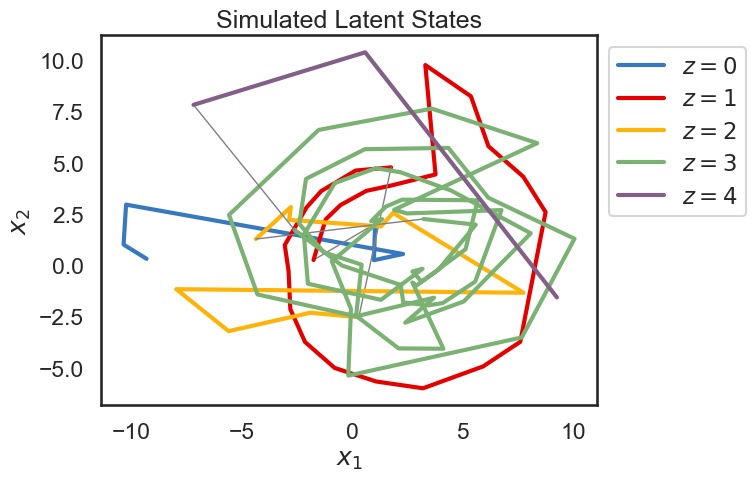

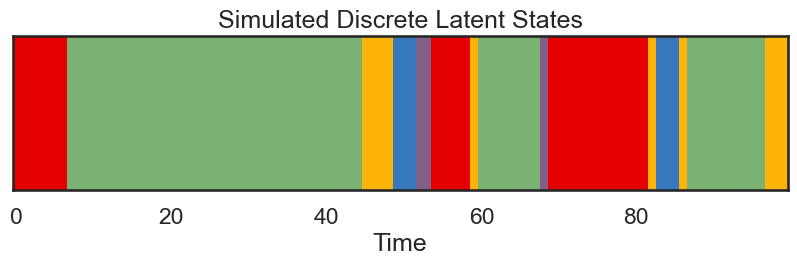

In [4]:
for k in range(n_disc_states):
    curr_states = states_x[states_z == k]
    plt.plot(curr_states[:,0],
             curr_states[:,1],
             '-',
             color=colors[k],
             lw=3,
             label="$z=%i$" % k)
    
    # Draw lines connecting the latent state between discrete state transitions,
    # so they don't show up as broken lines.
    next_states = states_x[states_z == k+1]
    if len(next_states) > 0 and len(curr_states) > 0:
        plt.plot((curr_states[-1,0], next_states[0,0]),
                 (curr_states[-1,1], next_states[0,1]),
                 '-',
                 color='gray',
                 lw=1)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

plt.figure(figsize=(10,2))
cmap_limited = ListedColormap(colors[0:n_disc_states])
plt.imshow(states_z[None,:],  aspect="auto", cmap=cmap_limited)
plt.title("Simulated Discrete Latent States")
plt.yticks([])
plt.xlabel("Time")
plt.show()

### 2.1 Visualize the Emissions
Below, we visualize the 10-dimensional emissions from our SLDS.

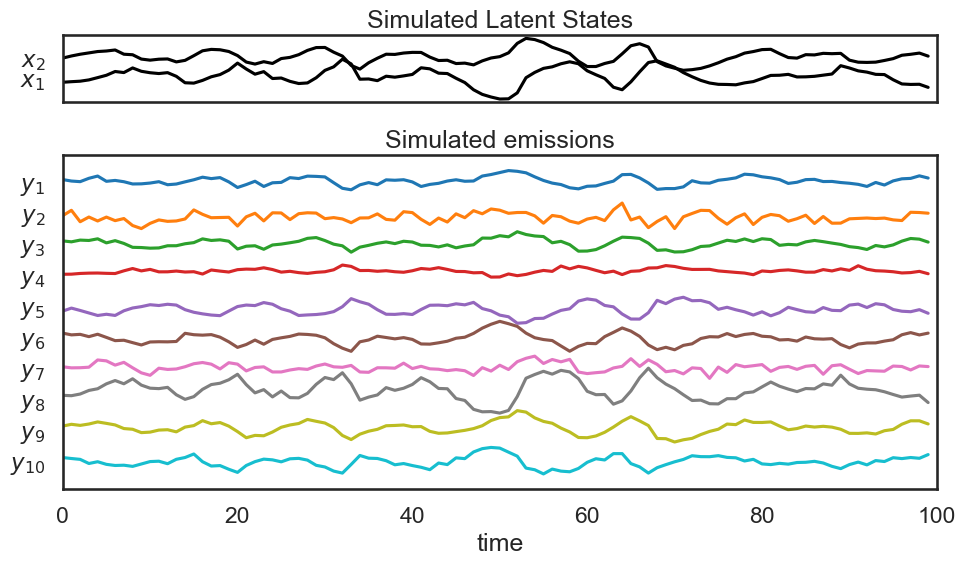

In [5]:
plt.figure(figsize=(10, 6))
gs = plt.GridSpec(2, 1, height_ratios=(1, emissions_dim/latent_dim))

# Plot the continuous latent states
lim = abs(states_x).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states_x[:, d] + lim * d, '-k')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(emissions).max()
plt.subplot(gs[1])
for n in range(emissions_dim):
    plt.plot(emissions[:, n] - lim * n, '-')
plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Simulated emissions")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_2.pdf")

## 3. Fit an SLDS From Data
SSM provides the capability to learn the parameters of an SLDS from data. In the above cells, we sampled from 100 time-steps in order to visualize the state trajectory.

In order to learn an SLDS, we'll need more data, so we start by sampling for a longer period. In the following cells, we'll treat our observations as a dataset, and demonstrate how to learn an SLDS using SSM.

In [6]:
# Sample again, for more time-bins
time_bins = 1000
states_z, states_x, emissions = true_slds.sample(time_bins)
data = emissions

### 3.1 Compare Fitting Methods

**Important Note:**  
 <span style="font-size:larger;">
Understanding the following section is not necessary to use SSM! _For practical purposes, it is almost always best to use the Laplace-EM method, which is the default._
</span>

**Parameter Learning for SLDS**  
Parameter learning in an SLDS requires approximate methods. SSM provides two approximate inference algorithms: Stochastic Variational Inference (`"svi"`), Laplace-Approximate EM (`"laplace_em"`). We don't have the space to describe these methods in detail here, but Stochastic Variational Inference was described in ["Stochastic Variational Inference"](http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf) by Hoffamn et al. The Laplace Approximation is described in several sources, but a good reference for the context of state-space models is ["Estimating State and Parameters in state-space models of Spike Trains,"](https://pdfs.semanticscholar.org/a71e/bf112cabd47cc67284dc8c12ab7644195d60.pdf) a book chapter by Macke et al.



**Approximate Posterior Distributions**
When using approximate methods, we must choose the form of the distribution we use to approximate the posterior. Here, SSM provides three options:
1. `variational_posterior="meanfield"`
The mean-field approximation uses a factorized distribution as the approximating posterior. Compatible with the SVI method.

2. `variational_posterior="tridiag"`
This approximates the posterior using a Gaussian with a block tridiagonal covariance matrix, which can be thought of as approximating the SLDS posterior with the posterior from an LDS. Compatible with the SVI method.

3. `variational_posterior="structured_meanfield"`
This assumes a posterior where the join distribution over the continuous and discrete latent states factors as follows. If $q(z,x \mid y)$ is the joint posterior of the discrete and continuous states given the data, we use the approximation $q(z,x \mid y) \approx q(z \mid y)q(x \mid y)$, where $q(z \mid y)$ is the posterior for a Markov chain. Compatible with the SVI and Laplace-EM methods.

**Calling the Fit function in SSM**  
All models in SSM share the same general syntax for fitting a model from data. Below, we call the fit function using three different methods and compare convergence. The syntax is as follows:
```python
elbos, posterior = slds.fit(data, method= "...",
                            variational_posterior="...",
                            num_iters= ...)
```
In the the call to `fit`, method should be one of {`"svi"`, `"laplace_em"`}.  
The `variational_posterior` argument should be one of {`"mf"`, `"structured_meanfield"`}. However, when using Laplace-EM _only_ structured mean field is supported.
Below, we fit using four methods, and compare convergence.

**Fit using BBVI and Mean-Field Posterior**

In [7]:
print("Fitting SLDS with BBVI and Mean-Field Posterior")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using BBVI with a mean field variational posterior
q_mf_elbos, q_mf = slds.fit(data, method="bbvi",
                            variational_posterior="mf",
                            num_iters=1000)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_mf_x, data)))
q_mf_z = slds.most_likely_states(q_mf_x, data)

# Smooth the data under the variational posterior
q_mf_y = slds.smooth(q_mf_x, data)

Fitting SLDS with BBVI and Mean-Field Posterior


  0%|                                                                                                               | 0/1 [00:00<?, ?it/s]

ARHMM Initialization restarts:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|                                                                                                              | 0/25 [00:00<?, ?it/s]

LP: -3736.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3736.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3604.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3512.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3464.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3433.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3417.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3407.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3401.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3398.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3395.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3393.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3390.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3386.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3383.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3381.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3375.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3367.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3361.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3357.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3355.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3354.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3353.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3353.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3352.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3352.8: 100%|███████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 250.41it/s]

ARHMM Initialization restarts: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]

ARHMM Initialization restarts: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]

  0%|                                                                                                            | 0/1000 [00:00<?, ?it/s]

LP: -15153.1:   0%|                                                                                              | 0/1000 [00:00<?, ?it/s]

ELBO: -15159.3:   0%|                                                                                            | 0/1000 [00:00<?, ?it/s]

ELBO: -15116.0:   0%|                                                                                    | 1/1000 [00:00<00:30, 33.20it/s]

ELBO: -15081.6:   0%|▏                                                                                   | 2/1000 [00:00<00:21, 46.35it/s]

ELBO: -15108.2:   0%|▎                                                                                   | 3/1000 [00:00<00:18, 53.58it/s]

ELBO: -15125.5:   0%|▎                                                                                   | 4/1000 [00:00<00:17, 58.01it/s]

ELBO: -15125.0:   0%|▍                                                                                   | 5/1000 [00:00<00:16, 61.06it/s]

ELBO: -15091.6:   1%|▌                                                                                   | 6/1000 [00:00<00:15, 63.24it/s]

ELBO: -15068.5:   1%|▌                                                                                   | 7/1000 [00:00<00:15, 65.06it/s]

ELBO: -15068.5:   1%|▋                                                                                   | 8/1000 [00:00<00:13, 74.19it/s]

ELBO: -15057.6:   2%|█▎                                                                                 | 16/1000 [00:00<00:13, 74.19it/s]

ELBO: -15081.8:   2%|█▍                                                                                 | 17/1000 [00:00<00:13, 74.19it/s]

ELBO: -15082.0:   2%|█▍                                                                                 | 18/1000 [00:00<00:13, 74.19it/s]

ELBO: -15100.0:   2%|█▌                                                                                 | 19/1000 [00:00<00:13, 74.19it/s]

ELBO: -15108.1:   2%|█▋                                                                                 | 20/1000 [00:00<00:13, 74.19it/s]

ELBO: -15108.1:   2%|█▋                                                                                | 21/1000 [00:00<00:09, 104.44it/s]

ELBO: -15017.3:   2%|█▋                                                                                | 21/1000 [00:00<00:09, 104.44it/s]

ELBO: -15038.6:   2%|█▊                                                                                | 22/1000 [00:00<00:09, 104.44it/s]

ELBO: -15035.5:   2%|█▉                                                                                | 23/1000 [00:00<00:09, 104.44it/s]

ELBO: -15029.4:   2%|█▉                                                                                | 24/1000 [00:00<00:09, 104.44it/s]

ELBO: -15002.8:   2%|██                                                                                | 25/1000 [00:00<00:09, 104.44it/s]

ELBO: -15040.6:   3%|██▏                                                                               | 26/1000 [00:00<00:09, 104.44it/s]

ELBO: -15006.6:   4%|███                                                                               | 38/1000 [00:00<00:09, 104.44it/s]

ELBO: -14963.9:   4%|███▏                                                                              | 39/1000 [00:00<00:09, 104.44it/s]

ELBO: -14963.9:   4%|███▎                                                                              | 40/1000 [00:00<00:06, 140.65it/s]

ELBO: -15027.7:   4%|███▎                                                                              | 40/1000 [00:00<00:06, 140.65it/s]

ELBO: -15008.7:   4%|███▎                                                                              | 41/1000 [00:00<00:06, 140.65it/s]

ELBO: -14962.5:   4%|███▍                                                                              | 42/1000 [00:00<00:06, 140.65it/s]

ELBO: -14964.4:   4%|███▌                                                                              | 43/1000 [00:00<00:06, 140.65it/s]

ELBO: -14945.4:   4%|███▌                                                                              | 44/1000 [00:00<00:06, 140.65it/s]

ELBO: -14969.1:   4%|███▋                                                                              | 45/1000 [00:00<00:06, 140.65it/s]

ELBO: -14983.2:   5%|███▊                                                                              | 46/1000 [00:00<00:06, 140.65it/s]

ELBO: -14963.0:   5%|███▊                                                                              | 47/1000 [00:00<00:06, 140.65it/s]

ELBO: -14961.7:   5%|███▉                                                                              | 48/1000 [00:00<00:06, 140.65it/s]

ELBO: -14872.1:   5%|████                                                                              | 49/1000 [00:00<00:06, 140.65it/s]

ELBO: -14890.9:   5%|████                                                                              | 50/1000 [00:00<00:06, 140.65it/s]

ELBO: -14932.4:   5%|████▏                                                                             | 51/1000 [00:00<00:06, 140.65it/s]

ELBO: -14797.0:   5%|████▎                                                                             | 52/1000 [00:00<00:06, 140.65it/s]

ELBO: -14924.9:   5%|████▎                                                                             | 53/1000 [00:00<00:06, 140.65it/s]

ELBO: -14926.1:   5%|████▍                                                                             | 54/1000 [00:00<00:06, 140.65it/s]

ELBO: -14926.1:   6%|████▌                                                                             | 55/1000 [00:00<00:08, 106.08it/s]

ELBO: -14881.8:   7%|█████▋                                                                            | 70/1000 [00:00<00:08, 106.08it/s]

ELBO: -14898.0:   7%|█████▊                                                                            | 71/1000 [00:00<00:08, 106.08it/s]

ELBO: -14840.6:   7%|█████▉                                                                            | 72/1000 [00:00<00:08, 106.08it/s]

ELBO: -14905.1:   7%|█████▉                                                                            | 73/1000 [00:00<00:08, 106.08it/s]

ELBO: -14824.9:   7%|██████                                                                            | 74/1000 [00:00<00:08, 106.08it/s]

ELBO: -14824.3:   8%|██████▏                                                                           | 75/1000 [00:00<00:08, 106.08it/s]

ELBO: -14863.3:   8%|██████▏                                                                           | 76/1000 [00:00<00:08, 106.08it/s]

ELBO: -14834.4:   8%|██████▎                                                                           | 77/1000 [00:00<00:08, 106.08it/s]

ELBO: -14834.4:   8%|██████▍                                                                           | 78/1000 [00:00<00:06, 140.56it/s]

ELBO: -14838.5:   8%|██████▍                                                                           | 78/1000 [00:00<00:06, 140.56it/s]

ELBO: -14803.6:   8%|██████▍                                                                           | 79/1000 [00:00<00:06, 140.56it/s]

ELBO: -14858.1:   8%|██████▌                                                                           | 80/1000 [00:00<00:06, 140.56it/s]

ELBO: -14803.9:   8%|██████▋                                                                           | 81/1000 [00:00<00:06, 140.56it/s]

ELBO: -14830.3:   8%|██████▋                                                                           | 82/1000 [00:00<00:06, 140.56it/s]

ELBO: -14831.9:   8%|██████▊                                                                           | 83/1000 [00:00<00:06, 140.56it/s]

ELBO: -14746.0:   8%|██████▉                                                                           | 84/1000 [00:00<00:06, 140.56it/s]

ELBO: -14809.0:   8%|██████▉                                                                           | 85/1000 [00:00<00:06, 140.56it/s]

ELBO: -14776.9:   9%|███████                                                                           | 86/1000 [00:00<00:06, 140.56it/s]

ELBO: -14811.6:   9%|███████▏                                                                          | 87/1000 [00:00<00:06, 140.56it/s]

ELBO: -14821.1:   9%|███████▏                                                                          | 88/1000 [00:00<00:06, 140.56it/s]

ELBO: -14774.6:   9%|███████▎                                                                          | 89/1000 [00:00<00:06, 140.56it/s]

ELBO: -14748.6:   9%|███████▍                                                                          | 90/1000 [00:00<00:06, 140.56it/s]

ELBO: -14757.6:   9%|███████▍                                                                          | 91/1000 [00:00<00:06, 140.56it/s]

ELBO: -14735.6:   9%|███████▌                                                                          | 92/1000 [00:00<00:06, 140.56it/s]

ELBO: -14766.4:   9%|███████▋                                                                          | 93/1000 [00:00<00:06, 140.56it/s]

ELBO: -14766.4:   9%|███████▋                                                                          | 94/1000 [00:00<00:08, 111.69it/s]

ELBO: -14735.6:   9%|███████▋                                                                          | 94/1000 [00:00<00:08, 111.69it/s]

ELBO: -14704.8:  10%|███████▊                                                                          | 95/1000 [00:00<00:08, 111.69it/s]

ELBO: -14739.9:  10%|███████▊                                                                          | 96/1000 [00:00<00:08, 111.69it/s]

ELBO: -14718.5:  10%|███████▉                                                                          | 97/1000 [00:00<00:08, 111.69it/s]

ELBO: -14719.9:  10%|████████                                                                          | 98/1000 [00:00<00:08, 111.69it/s]

ELBO: -14679.1:  10%|████████                                                                          | 99/1000 [00:00<00:08, 111.69it/s]

ELBO: -14634.1:  10%|████████                                                                         | 100/1000 [00:00<00:08, 111.69it/s]

ELBO: -14598.0:  10%|████████▏                                                                        | 101/1000 [00:00<00:08, 111.69it/s]

ELBO: -14598.0:  12%|█████████▎                                                                       | 115/1000 [00:00<00:06, 134.62it/s]

ELBO: -14664.3:  12%|█████████▎                                                                       | 115/1000 [00:00<00:06, 134.62it/s]

ELBO: -14686.6:  12%|█████████▍                                                                       | 116/1000 [00:00<00:06, 134.62it/s]

ELBO: -14687.4:  12%|█████████▍                                                                       | 117/1000 [00:00<00:06, 134.62it/s]

ELBO: -14640.2:  12%|█████████▌                                                                       | 118/1000 [00:00<00:06, 134.62it/s]

ELBO: -14610.8:  12%|█████████▋                                                                       | 119/1000 [00:00<00:06, 134.62it/s]

ELBO: -14613.4:  12%|█████████▋                                                                       | 120/1000 [00:01<00:06, 134.62it/s]

ELBO: -14615.4:  12%|█████████▊                                                                       | 121/1000 [00:01<00:06, 134.62it/s]

ELBO: -14611.4:  12%|█████████▉                                                                       | 122/1000 [00:01<00:06, 134.62it/s]

ELBO: -14629.3:  12%|█████████▉                                                                       | 123/1000 [00:01<00:06, 134.62it/s]

ELBO: -14609.2:  12%|██████████                                                                       | 124/1000 [00:01<00:06, 134.62it/s]

ELBO: -14584.5:  12%|██████████▏                                                                      | 125/1000 [00:01<00:06, 134.62it/s]

ELBO: -14606.8:  13%|██████████▏                                                                      | 126/1000 [00:01<00:06, 134.62it/s]

ELBO: -14571.7:  13%|██████████▎                                                                      | 127/1000 [00:01<00:06, 134.62it/s]

ELBO: -14541.4:  13%|██████████▎                                                                      | 128/1000 [00:01<00:06, 134.62it/s]

ELBO: -14598.7:  13%|██████████▍                                                                      | 129/1000 [00:01<00:06, 134.62it/s]

ELBO: -14520.2:  13%|██████████▌                                                                      | 130/1000 [00:01<00:06, 134.62it/s]

ELBO: -14520.2:  13%|██████████▌                                                                      | 131/1000 [00:01<00:08, 102.84it/s]

ELBO: -14599.3:  13%|██████████▌                                                                      | 131/1000 [00:01<00:08, 102.84it/s]

ELBO: -14623.3:  13%|██████████▋                                                                      | 132/1000 [00:01<00:08, 102.84it/s]

ELBO: -14528.7:  13%|██████████▊                                                                      | 133/1000 [00:01<00:08, 102.84it/s]

ELBO: -14547.7:  13%|██████████▊                                                                      | 134/1000 [00:01<00:08, 102.84it/s]

ELBO: -14565.0:  14%|██████████▉                                                                      | 135/1000 [00:01<00:08, 102.84it/s]

ELBO: -14492.1:  14%|███████████                                                                      | 136/1000 [00:01<00:08, 102.84it/s]

ELBO: -14516.8:  14%|███████████                                                                      | 137/1000 [00:01<00:08, 102.84it/s]

ELBO: -14483.0:  14%|███████████▏                                                                     | 138/1000 [00:01<00:08, 102.84it/s]

ELBO: -14492.3:  14%|███████████▎                                                                     | 139/1000 [00:01<00:08, 102.84it/s]

ELBO: -14509.5:  14%|███████████▎                                                                     | 140/1000 [00:01<00:08, 102.84it/s]

ELBO: -14493.1:  14%|███████████▍                                                                     | 141/1000 [00:01<00:08, 102.84it/s]

ELBO: -14498.9:  14%|███████████▌                                                                     | 142/1000 [00:01<00:08, 102.84it/s]

ELBO: -14526.0:  14%|███████████▌                                                                     | 143/1000 [00:01<00:08, 102.84it/s]

ELBO: -14526.0:  14%|███████████▊                                                                      | 144/1000 [00:01<00:09, 93.74it/s]

ELBO: -14499.1:  14%|███████████▊                                                                      | 144/1000 [00:01<00:09, 93.74it/s]

ELBO: -14459.0:  14%|███████████▉                                                                      | 145/1000 [00:01<00:09, 93.74it/s]

ELBO: -14514.7:  15%|███████████▉                                                                      | 146/1000 [00:01<00:09, 93.74it/s]

ELBO: -14468.4:  15%|████████████                                                                      | 147/1000 [00:01<00:09, 93.74it/s]

ELBO: -14448.5:  15%|████████████▏                                                                     | 148/1000 [00:01<00:09, 93.74it/s]

ELBO: -14461.6:  15%|████████████▏                                                                     | 149/1000 [00:01<00:09, 93.74it/s]

ELBO: -14365.7:  15%|████████████▎                                                                     | 150/1000 [00:01<00:09, 93.74it/s]

ELBO: -14401.6:  15%|████████████▍                                                                     | 151/1000 [00:01<00:09, 93.74it/s]

ELBO: -14389.8:  15%|████████████▍                                                                     | 152/1000 [00:01<00:09, 93.74it/s]

ELBO: -14407.9:  15%|████████████▌                                                                     | 153/1000 [00:01<00:09, 93.74it/s]

ELBO: -14415.1:  15%|████████████▋                                                                     | 154/1000 [00:01<00:09, 93.74it/s]

ELBO: -14415.1:  16%|████████████▋                                                                     | 155/1000 [00:01<00:09, 87.53it/s]

ELBO: -14371.7:  16%|████████████▋                                                                     | 155/1000 [00:01<00:09, 87.53it/s]

ELBO: -14395.6:  16%|████████████▊                                                                     | 156/1000 [00:01<00:09, 87.53it/s]

ELBO: -14395.7:  16%|████████████▊                                                                     | 157/1000 [00:01<00:09, 87.53it/s]

ELBO: -14415.9:  16%|████████████▉                                                                     | 158/1000 [00:01<00:09, 87.53it/s]

ELBO: -14362.3:  16%|█████████████                                                                     | 159/1000 [00:01<00:09, 87.53it/s]

ELBO: -14376.0:  16%|█████████████                                                                     | 160/1000 [00:01<00:09, 87.53it/s]

ELBO: -14482.2:  16%|█████████████▏                                                                    | 161/1000 [00:01<00:09, 87.53it/s]

ELBO: -14325.6:  16%|█████████████▎                                                                    | 162/1000 [00:01<00:09, 87.53it/s]

ELBO: -14304.4:  16%|█████████████▎                                                                    | 163/1000 [00:01<00:09, 87.53it/s]

ELBO: -14312.9:  16%|█████████████▍                                                                    | 164/1000 [00:01<00:09, 87.53it/s]

ELBO: -14312.9:  16%|█████████████▌                                                                    | 165/1000 [00:01<00:09, 84.54it/s]

ELBO: -14349.2:  16%|█████████████▌                                                                    | 165/1000 [00:01<00:09, 84.54it/s]

ELBO: -14345.3:  17%|█████████████▌                                                                    | 166/1000 [00:01<00:09, 84.54it/s]

ELBO: -14329.7:  17%|█████████████▋                                                                    | 167/1000 [00:01<00:09, 84.54it/s]

ELBO: -14374.9:  17%|█████████████▊                                                                    | 168/1000 [00:01<00:09, 84.54it/s]

ELBO: -14309.7:  17%|█████████████▊                                                                    | 169/1000 [00:01<00:09, 84.54it/s]

ELBO: -14290.9:  17%|█████████████▉                                                                    | 170/1000 [00:01<00:09, 84.54it/s]

ELBO: -14271.3:  17%|██████████████                                                                    | 171/1000 [00:01<00:09, 84.54it/s]

ELBO: -14280.5:  18%|██████████████▉                                                                   | 182/1000 [00:01<00:09, 84.54it/s]

ELBO: -14280.5:  18%|██████████████▊                                                                  | 183/1000 [00:01<00:07, 104.21it/s]

ELBO: -14239.0:  18%|██████████████▊                                                                  | 183/1000 [00:01<00:07, 104.21it/s]

ELBO: -14249.6:  18%|██████████████▉                                                                  | 184/1000 [00:01<00:07, 104.21it/s]

ELBO: -14244.5:  18%|██████████████▉                                                                  | 185/1000 [00:01<00:07, 104.21it/s]

ELBO: -14261.3:  19%|███████████████                                                                  | 186/1000 [00:01<00:07, 104.21it/s]

ELBO: -14294.2:  19%|███████████████▏                                                                 | 187/1000 [00:01<00:07, 104.21it/s]

ELBO: -14241.5:  19%|███████████████▏                                                                 | 188/1000 [00:01<00:07, 104.21it/s]

ELBO: -14252.0:  19%|███████████████▎                                                                 | 189/1000 [00:01<00:07, 104.21it/s]

ELBO: -14279.6:  19%|███████████████▍                                                                 | 190/1000 [00:01<00:07, 104.21it/s]

ELBO: -14220.5:  19%|███████████████▍                                                                 | 191/1000 [00:01<00:07, 104.21it/s]

ELBO: -14284.6:  19%|███████████████▌                                                                 | 192/1000 [00:01<00:07, 104.21it/s]

ELBO: -14193.0:  19%|███████████████▋                                                                 | 193/1000 [00:01<00:07, 104.21it/s]

ELBO: -14242.0:  19%|███████████████▋                                                                 | 194/1000 [00:01<00:07, 104.21it/s]

ELBO: -14242.0:  20%|███████████████▉                                                                  | 195/1000 [00:01<00:08, 95.20it/s]

ELBO: -14243.0:  20%|███████████████▉                                                                  | 195/1000 [00:01<00:08, 95.20it/s]

ELBO: -14221.8:  20%|████████████████                                                                  | 196/1000 [00:01<00:08, 95.20it/s]

ELBO: -14175.3:  20%|████████████████▏                                                                 | 197/1000 [00:01<00:08, 95.20it/s]

ELBO: -14192.5:  20%|████████████████▏                                                                 | 198/1000 [00:01<00:08, 95.20it/s]

ELBO: -14196.7:  20%|████████████████▎                                                                 | 199/1000 [00:01<00:08, 95.20it/s]

ELBO: -14201.7:  20%|████████████████▍                                                                 | 200/1000 [00:02<00:08, 95.20it/s]

ELBO: -14148.2:  20%|████████████████▍                                                                 | 201/1000 [00:02<00:08, 95.20it/s]

ELBO: -14155.8:  20%|████████████████▌                                                                 | 202/1000 [00:02<00:08, 95.20it/s]

ELBO: -14133.9:  20%|████████████████▋                                                                 | 203/1000 [00:02<00:08, 95.20it/s]

ELBO: -14114.9:  20%|████████████████▋                                                                 | 204/1000 [00:02<00:08, 95.20it/s]

ELBO: -14195.8:  20%|████████████████▊                                                                 | 205/1000 [00:02<00:08, 95.20it/s]

ELBO: -14195.8:  21%|████████████████▉                                                                 | 206/1000 [00:02<00:09, 83.16it/s]

ELBO: -14129.2:  21%|████████████████▉                                                                 | 206/1000 [00:02<00:09, 83.16it/s]

ELBO: -14128.4:  21%|████████████████▉                                                                 | 207/1000 [00:02<00:09, 83.16it/s]

ELBO: -14187.1:  21%|█████████████████                                                                 | 208/1000 [00:02<00:09, 83.16it/s]

ELBO: -14123.0:  21%|█████████████████▏                                                                | 209/1000 [00:02<00:09, 83.16it/s]

ELBO: -14133.2:  21%|█████████████████▏                                                                | 210/1000 [00:02<00:09, 83.16it/s]

ELBO: -14145.8:  21%|█████████████████▎                                                                | 211/1000 [00:02<00:09, 83.16it/s]

ELBO: -14088.9:  21%|█████████████████▍                                                                | 212/1000 [00:02<00:09, 83.16it/s]

ELBO: -14037.3:  21%|█████████████████▍                                                                | 213/1000 [00:02<00:09, 83.16it/s]

ELBO: -14106.5:  21%|█████████████████▌                                                                | 214/1000 [00:02<00:09, 83.16it/s]

ELBO: -14098.4:  22%|█████████████████▋                                                                | 215/1000 [00:02<00:09, 83.16it/s]

ELBO: -14098.4:  22%|█████████████████▋                                                                | 216/1000 [00:02<00:09, 81.38it/s]

ELBO: -14124.6:  22%|█████████████████▋                                                                | 216/1000 [00:02<00:09, 81.38it/s]

ELBO: -14029.5:  22%|█████████████████▊                                                                | 217/1000 [00:02<00:09, 81.38it/s]

ELBO: -14035.9:  22%|█████████████████▉                                                                | 218/1000 [00:02<00:09, 81.38it/s]

ELBO: -14066.5:  22%|█████████████████▉                                                                | 219/1000 [00:02<00:09, 81.38it/s]

ELBO: -14039.2:  22%|██████████████████                                                                | 220/1000 [00:02<00:09, 81.38it/s]

ELBO: -14046.0:  22%|██████████████████                                                                | 221/1000 [00:02<00:09, 81.38it/s]

ELBO: -14010.9:  22%|██████████████████▏                                                               | 222/1000 [00:02<00:09, 81.38it/s]

ELBO: -14038.5:  22%|██████████████████▎                                                               | 223/1000 [00:02<00:09, 81.38it/s]

ELBO: -14013.6:  22%|██████████████████▎                                                               | 224/1000 [00:02<00:09, 81.38it/s]

ELBO: -14013.6:  22%|██████████████████▍                                                               | 225/1000 [00:02<00:09, 80.07it/s]

ELBO: -14016.0:  22%|██████████████████▍                                                               | 225/1000 [00:02<00:09, 80.07it/s]

ELBO: -13999.4:  23%|██████████████████▌                                                               | 226/1000 [00:02<00:09, 80.07it/s]

ELBO: -14031.8:  23%|██████████████████▌                                                               | 227/1000 [00:02<00:09, 80.07it/s]

ELBO: -13926.3:  23%|██████████████████▋                                                               | 228/1000 [00:02<00:09, 80.07it/s]

ELBO: -14013.3:  23%|██████████████████▊                                                               | 229/1000 [00:02<00:09, 80.07it/s]

ELBO: -13976.8:  23%|██████████████████▊                                                               | 230/1000 [00:02<00:09, 80.07it/s]

ELBO: -13929.8:  24%|███████████████████▋                                                              | 240/1000 [00:02<00:09, 80.07it/s]

ELBO: -13923.9:  24%|███████████████████▊                                                              | 241/1000 [00:02<00:09, 80.07it/s]

ELBO: -13923.9:  24%|███████████████████▌                                                             | 242/1000 [00:02<00:07, 100.35it/s]

ELBO: -13953.0:  24%|███████████████████▌                                                             | 242/1000 [00:02<00:07, 100.35it/s]

ELBO: -13943.4:  24%|███████████████████▋                                                             | 243/1000 [00:02<00:07, 100.35it/s]

ELBO: -13924.6:  24%|███████████████████▊                                                             | 244/1000 [00:02<00:07, 100.35it/s]

ELBO: -13881.0:  24%|███████████████████▊                                                             | 245/1000 [00:02<00:07, 100.35it/s]

ELBO: -13920.5:  25%|███████████████████▉                                                             | 246/1000 [00:02<00:07, 100.35it/s]

ELBO: -13911.5:  25%|████████████████████                                                             | 247/1000 [00:02<00:07, 100.35it/s]

ELBO: -13939.1:  25%|████████████████████                                                             | 248/1000 [00:02<00:07, 100.35it/s]

ELBO: -13930.2:  25%|████████████████████▏                                                            | 249/1000 [00:02<00:07, 100.35it/s]

ELBO: -13963.1:  25%|████████████████████▎                                                            | 250/1000 [00:02<00:07, 100.35it/s]

ELBO: -13946.1:  25%|████████████████████▎                                                            | 251/1000 [00:02<00:07, 100.35it/s]

ELBO: -13909.5:  25%|████████████████████▍                                                            | 252/1000 [00:02<00:07, 100.35it/s]

ELBO: -13909.5:  25%|████████████████████▋                                                             | 253/1000 [00:02<00:08, 92.25it/s]

ELBO: -13960.0:  25%|████████████████████▋                                                             | 253/1000 [00:02<00:08, 92.25it/s]

ELBO: -13937.3:  25%|████████████████████▊                                                             | 254/1000 [00:02<00:08, 92.25it/s]

ELBO: -13889.2:  26%|████████████████████▉                                                             | 255/1000 [00:02<00:08, 92.25it/s]

ELBO: -13821.9:  26%|████████████████████▉                                                             | 256/1000 [00:02<00:08, 92.25it/s]

ELBO: -13884.4:  26%|█████████████████████                                                             | 257/1000 [00:02<00:08, 92.25it/s]

ELBO: -13917.6:  26%|█████████████████████▏                                                            | 258/1000 [00:02<00:08, 92.25it/s]

ELBO: -13860.8:  26%|█████████████████████▏                                                            | 259/1000 [00:02<00:08, 92.25it/s]

ELBO: -13851.4:  26%|█████████████████████▎                                                            | 260/1000 [00:02<00:08, 92.25it/s]

ELBO: -13865.2:  26%|█████████████████████▍                                                            | 261/1000 [00:02<00:08, 92.25it/s]

ELBO: -13835.5:  26%|█████████████████████▍                                                            | 262/1000 [00:02<00:07, 92.25it/s]

ELBO: -13835.5:  26%|█████████████████████▌                                                            | 263/1000 [00:02<00:08, 87.78it/s]

ELBO: -13843.1:  26%|█████████████████████▌                                                            | 263/1000 [00:02<00:08, 87.78it/s]

ELBO: -13793.2:  26%|█████████████████████▋                                                            | 264/1000 [00:02<00:08, 87.78it/s]

ELBO: -13807.5:  26%|█████████████████████▋                                                            | 265/1000 [00:02<00:08, 87.78it/s]

ELBO: -13815.4:  27%|█████████████████████▊                                                            | 266/1000 [00:02<00:08, 87.78it/s]

ELBO: -13740.7:  27%|█████████████████████▉                                                            | 267/1000 [00:02<00:08, 87.78it/s]

ELBO: -13811.6:  27%|█████████████████████▉                                                            | 268/1000 [00:02<00:08, 87.78it/s]

ELBO: -13788.4:  27%|██████████████████████                                                            | 269/1000 [00:02<00:08, 87.78it/s]

ELBO: -13792.3:  27%|██████████████████████▏                                                           | 270/1000 [00:02<00:08, 87.78it/s]

ELBO: -13797.7:  27%|██████████████████████▏                                                           | 271/1000 [00:02<00:08, 87.78it/s]

ELBO: -13800.7:  27%|██████████████████████▎                                                           | 272/1000 [00:02<00:08, 87.78it/s]

ELBO: -13800.7:  27%|██████████████████████▍                                                           | 273/1000 [00:02<00:09, 77.84it/s]

ELBO: -13762.7:  27%|██████████████████████▍                                                           | 273/1000 [00:02<00:09, 77.84it/s]

ELBO: -13746.5:  27%|██████████████████████▍                                                           | 274/1000 [00:02<00:09, 77.84it/s]

ELBO: -13772.2:  28%|██████████████████████▌                                                           | 275/1000 [00:02<00:09, 77.84it/s]

ELBO: -13768.0:  28%|██████████████████████▋                                                           | 276/1000 [00:02<00:09, 77.84it/s]

ELBO: -13751.9:  28%|██████████████████████▋                                                           | 277/1000 [00:02<00:09, 77.84it/s]

ELBO: -13780.9:  28%|██████████████████████▊                                                           | 278/1000 [00:02<00:09, 77.84it/s]

ELBO: -13718.5:  28%|██████████████████████▉                                                           | 279/1000 [00:02<00:09, 77.84it/s]

ELBO: -13750.8:  28%|██████████████████████▉                                                           | 280/1000 [00:02<00:09, 77.84it/s]

ELBO: -13800.8:  28%|███████████████████████                                                           | 281/1000 [00:02<00:09, 77.84it/s]

ELBO: -13800.8:  28%|███████████████████████                                                           | 282/1000 [00:02<00:09, 77.56it/s]

ELBO: -13751.2:  28%|███████████████████████                                                           | 282/1000 [00:02<00:09, 77.56it/s]

ELBO: -13696.7:  28%|███████████████████████▏                                                          | 283/1000 [00:03<00:09, 77.56it/s]

ELBO: -13758.9:  28%|███████████████████████▎                                                          | 284/1000 [00:03<00:09, 77.56it/s]

ELBO: -13665.2:  28%|███████████████████████▎                                                          | 285/1000 [00:03<00:09, 77.56it/s]

ELBO: -13638.7:  29%|███████████████████████▍                                                          | 286/1000 [00:03<00:09, 77.56it/s]

ELBO: -13675.7:  29%|███████████████████████▌                                                          | 287/1000 [00:03<00:09, 77.56it/s]

ELBO: -13642.4:  29%|███████████████████████▌                                                          | 288/1000 [00:03<00:09, 77.56it/s]

ELBO: -13669.3:  29%|███████████████████████▋                                                          | 289/1000 [00:03<00:09, 77.56it/s]

ELBO: -13702.0:  29%|███████████████████████▊                                                          | 290/1000 [00:03<00:09, 77.56it/s]

ELBO: -13702.0:  29%|███████████████████████▊                                                          | 291/1000 [00:03<00:09, 77.06it/s]

ELBO: -13669.0:  29%|███████████████████████▊                                                          | 291/1000 [00:03<00:09, 77.06it/s]

ELBO: -13664.0:  29%|███████████████████████▉                                                          | 292/1000 [00:03<00:09, 77.06it/s]

ELBO: -13602.8:  29%|████████████████████████                                                          | 293/1000 [00:03<00:09, 77.06it/s]

ELBO: -13619.7:  29%|████████████████████████                                                          | 294/1000 [00:03<00:09, 77.06it/s]

ELBO: -13624.5:  30%|████████████████████████▏                                                         | 295/1000 [00:03<00:09, 77.06it/s]

ELBO: -13635.7:  30%|████████████████████████▎                                                         | 296/1000 [00:03<00:09, 77.06it/s]

ELBO: -13596.5:  30%|████████████████████████▎                                                         | 297/1000 [00:03<00:09, 77.06it/s]

ELBO: -13578.4:  30%|████████████████████████▍                                                         | 298/1000 [00:03<00:09, 77.06it/s]

ELBO: -13578.4:  30%|████████████████████████▌                                                         | 299/1000 [00:03<00:09, 76.90it/s]

ELBO: -13632.5:  31%|█████████████████████████▏                                                        | 307/1000 [00:03<00:09, 76.90it/s]

ELBO: -13603.8:  31%|█████████████████████████▎                                                        | 308/1000 [00:03<00:08, 76.90it/s]

ELBO: -13575.6:  31%|█████████████████████████▎                                                        | 309/1000 [00:03<00:08, 76.90it/s]

ELBO: -13646.7:  31%|█████████████████████████▍                                                        | 310/1000 [00:03<00:08, 76.90it/s]

ELBO: -13574.9:  31%|█████████████████████████▌                                                        | 311/1000 [00:03<00:08, 76.90it/s]

ELBO: -13582.2:  31%|█████████████████████████▌                                                        | 312/1000 [00:03<00:08, 76.90it/s]

ELBO: -13610.3:  31%|█████████████████████████▋                                                        | 313/1000 [00:03<00:08, 76.90it/s]

ELBO: -13560.9:  31%|█████████████████████████▋                                                        | 314/1000 [00:03<00:08, 76.90it/s]

ELBO: -13560.9:  32%|█████████████████████████▊                                                        | 315/1000 [00:03<00:07, 97.43it/s]

ELBO: -13552.7:  32%|█████████████████████████▊                                                        | 315/1000 [00:03<00:07, 97.43it/s]

ELBO: -13566.0:  32%|█████████████████████████▉                                                        | 316/1000 [00:03<00:07, 97.43it/s]

ELBO: -13537.7:  32%|█████████████████████████▉                                                        | 317/1000 [00:03<00:07, 97.43it/s]

ELBO: -13571.3:  32%|██████████████████████████                                                        | 318/1000 [00:03<00:06, 97.43it/s]

ELBO: -13520.3:  32%|██████████████████████████▏                                                       | 319/1000 [00:03<00:06, 97.43it/s]

ELBO: -13562.1:  32%|██████████████████████████▏                                                       | 320/1000 [00:03<00:06, 97.43it/s]

ELBO: -13547.8:  32%|██████████████████████████▎                                                       | 321/1000 [00:03<00:06, 97.43it/s]

ELBO: -13498.8:  32%|██████████████████████████▍                                                       | 322/1000 [00:03<00:06, 97.43it/s]

ELBO: -13521.0:  32%|██████████████████████████▍                                                       | 323/1000 [00:03<00:06, 97.43it/s]

ELBO: -13501.0:  32%|██████████████████████████▌                                                       | 324/1000 [00:03<00:06, 97.43it/s]

ELBO: -13489.7:  32%|██████████████████████████▋                                                       | 325/1000 [00:03<00:06, 97.43it/s]

ELBO: -13489.7:  33%|██████████████████████████▋                                                       | 326/1000 [00:03<00:07, 90.32it/s]

ELBO: -13481.6:  33%|██████████████████████████▋                                                       | 326/1000 [00:03<00:07, 90.32it/s]

ELBO: -13490.4:  33%|██████████████████████████▊                                                       | 327/1000 [00:03<00:07, 90.32it/s]

ELBO: -13425.3:  33%|██████████████████████████▉                                                       | 328/1000 [00:03<00:07, 90.32it/s]

ELBO: -13472.7:  33%|██████████████████████████▉                                                       | 329/1000 [00:03<00:07, 90.32it/s]

ELBO: -13504.0:  33%|███████████████████████████                                                       | 330/1000 [00:03<00:07, 90.32it/s]

ELBO: -13433.6:  33%|███████████████████████████▏                                                      | 331/1000 [00:03<00:07, 90.32it/s]

ELBO: -13424.4:  33%|███████████████████████████▏                                                      | 332/1000 [00:03<00:07, 90.32it/s]

ELBO: -13438.6:  33%|███████████████████████████▎                                                      | 333/1000 [00:03<00:07, 90.32it/s]

ELBO: -13432.2:  33%|███████████████████████████▍                                                      | 334/1000 [00:03<00:07, 90.32it/s]

ELBO: -13457.4:  34%|███████████████████████████▍                                                      | 335/1000 [00:03<00:07, 90.32it/s]

ELBO: -13457.4:  34%|███████████████████████████▌                                                      | 336/1000 [00:03<00:07, 85.61it/s]

ELBO: -13449.2:  34%|███████████████████████████▌                                                      | 336/1000 [00:03<00:07, 85.61it/s]

ELBO: -13434.3:  34%|███████████████████████████▋                                                      | 337/1000 [00:03<00:07, 85.61it/s]

ELBO: -13394.9:  34%|███████████████████████████▋                                                      | 338/1000 [00:03<00:07, 85.61it/s]

ELBO: -13420.2:  34%|███████████████████████████▊                                                      | 339/1000 [00:03<00:07, 85.61it/s]

ELBO: -13431.4:  34%|███████████████████████████▉                                                      | 340/1000 [00:03<00:07, 85.61it/s]

ELBO: -13407.8:  34%|███████████████████████████▉                                                      | 341/1000 [00:03<00:07, 85.61it/s]

ELBO: -13390.0:  34%|████████████████████████████                                                      | 342/1000 [00:03<00:07, 85.61it/s]

ELBO: -13389.0:  34%|████████████████████████████▏                                                     | 343/1000 [00:03<00:07, 85.61it/s]

ELBO: -13368.9:  34%|████████████████████████████▏                                                     | 344/1000 [00:03<00:07, 85.61it/s]

ELBO: -13368.9:  34%|████████████████████████████▎                                                     | 345/1000 [00:03<00:08, 76.22it/s]

ELBO: -13434.8:  34%|████████████████████████████▎                                                     | 345/1000 [00:03<00:08, 76.22it/s]

ELBO: -13409.6:  35%|████████████████████████████▎                                                     | 346/1000 [00:03<00:08, 76.22it/s]

ELBO: -13382.4:  35%|████████████████████████████▍                                                     | 347/1000 [00:03<00:08, 76.22it/s]

ELBO: -13347.5:  35%|████████████████████████████▌                                                     | 348/1000 [00:03<00:08, 76.22it/s]

ELBO: -13377.0:  35%|████████████████████████████▌                                                     | 349/1000 [00:03<00:08, 76.22it/s]

ELBO: -13342.1:  35%|████████████████████████████▋                                                     | 350/1000 [00:03<00:08, 76.22it/s]

ELBO: -13328.7:  35%|████████████████████████████▊                                                     | 351/1000 [00:03<00:08, 76.22it/s]

ELBO: -13287.2:  35%|████████████████████████████▊                                                     | 352/1000 [00:03<00:08, 76.22it/s]

ELBO: -13287.2:  35%|████████████████████████████▉                                                     | 353/1000 [00:03<00:08, 76.34it/s]

ELBO: -13376.1:  35%|████████████████████████████▉                                                     | 353/1000 [00:03<00:08, 76.34it/s]

ELBO: -13395.4:  35%|█████████████████████████████                                                     | 354/1000 [00:03<00:08, 76.34it/s]

ELBO: -13346.6:  36%|█████████████████████████████                                                     | 355/1000 [00:03<00:08, 76.34it/s]

ELBO: -13262.6:  36%|█████████████████████████████▏                                                    | 356/1000 [00:03<00:08, 76.34it/s]

ELBO: -13357.4:  36%|█████████████████████████████▎                                                    | 357/1000 [00:03<00:08, 76.34it/s]

ELBO: -13310.0:  36%|█████████████████████████████▎                                                    | 358/1000 [00:03<00:08, 76.34it/s]

ELBO: -13310.2:  36%|█████████████████████████████▍                                                    | 359/1000 [00:03<00:08, 76.34it/s]

ELBO: -13293.0:  36%|█████████████████████████████▌                                                    | 360/1000 [00:03<00:08, 76.34it/s]

ELBO: -13293.0:  36%|█████████████████████████████▌                                                    | 361/1000 [00:03<00:08, 76.44it/s]

ELBO: -13313.0:  36%|█████████████████████████████▌                                                    | 361/1000 [00:03<00:08, 76.44it/s]

ELBO: -13295.3:  36%|█████████████████████████████▋                                                    | 362/1000 [00:03<00:08, 76.44it/s]

ELBO: -13291.2:  36%|█████████████████████████████▊                                                    | 363/1000 [00:03<00:08, 76.44it/s]

ELBO: -13250.6:  36%|█████████████████████████████▊                                                    | 364/1000 [00:04<00:08, 76.44it/s]

ELBO: -13294.6:  36%|█████████████████████████████▉                                                    | 365/1000 [00:04<00:08, 76.44it/s]

ELBO: -13265.6:  37%|██████████████████████████████                                                    | 366/1000 [00:04<00:08, 76.44it/s]

ELBO: -13184.6:  37%|██████████████████████████████                                                    | 367/1000 [00:04<00:08, 76.44it/s]

ELBO: -13252.8:  37%|██████████████████████████████▏                                                   | 368/1000 [00:04<00:08, 76.44it/s]

ELBO: -13252.8:  37%|██████████████████████████████▎                                                   | 369/1000 [00:04<00:08, 76.40it/s]

ELBO: -13266.8:  37%|██████████████████████████████▎                                                   | 369/1000 [00:04<00:08, 76.40it/s]

ELBO: -13179.4:  37%|██████████████████████████████▎                                                   | 370/1000 [00:04<00:08, 76.40it/s]

ELBO: -13246.3:  37%|██████████████████████████████▍                                                   | 371/1000 [00:04<00:08, 76.40it/s]

ELBO: -13221.8:  37%|██████████████████████████████▌                                                   | 372/1000 [00:04<00:08, 76.40it/s]

ELBO: -13212.1:  37%|██████████████████████████████▌                                                   | 373/1000 [00:04<00:08, 76.40it/s]

ELBO: -13245.6:  37%|██████████████████████████████▋                                                   | 374/1000 [00:04<00:08, 76.40it/s]

ELBO: -13206.9:  38%|██████████████████████████████▊                                                   | 375/1000 [00:04<00:08, 76.40it/s]

ELBO: -13196.7:  38%|██████████████████████████████▊                                                   | 376/1000 [00:04<00:08, 76.40it/s]

ELBO: -13196.7:  38%|██████████████████████████████▉                                                   | 377/1000 [00:04<00:08, 76.34it/s]

ELBO: -13164.0:  38%|██████████████████████████████▉                                                   | 377/1000 [00:04<00:08, 76.34it/s]

ELBO: -13171.4:  38%|██████████████████████████████▉                                                   | 378/1000 [00:04<00:08, 76.34it/s]

ELBO: -13161.5:  38%|███████████████████████████████                                                   | 379/1000 [00:04<00:08, 76.34it/s]

ELBO: -13144.4:  38%|███████████████████████████████▏                                                  | 380/1000 [00:04<00:08, 76.34it/s]

ELBO: -13153.9:  39%|███████████████████████████████▉                                                  | 389/1000 [00:04<00:08, 76.34it/s]

ELBO: -13173.7:  39%|███████████████████████████████▉                                                  | 390/1000 [00:04<00:07, 76.34it/s]

ELBO: -13153.6:  39%|████████████████████████████████                                                  | 391/1000 [00:04<00:07, 76.34it/s]

ELBO: -13155.1:  39%|████████████████████████████████▏                                                 | 392/1000 [00:04<00:07, 76.34it/s]

ELBO: -13155.1:  39%|████████████████████████████████▏                                                 | 393/1000 [00:04<00:06, 98.47it/s]

ELBO: -13164.0:  39%|████████████████████████████████▏                                                 | 393/1000 [00:04<00:06, 98.47it/s]

ELBO: -13137.4:  39%|████████████████████████████████▎                                                 | 394/1000 [00:04<00:06, 98.47it/s]

ELBO: -13104.9:  40%|████████████████████████████████▍                                                 | 395/1000 [00:04<00:06, 98.47it/s]

ELBO: -13127.0:  40%|████████████████████████████████▍                                                 | 396/1000 [00:04<00:06, 98.47it/s]

ELBO: -13164.3:  40%|████████████████████████████████▌                                                 | 397/1000 [00:04<00:06, 98.47it/s]

ELBO: -13028.4:  40%|████████████████████████████████▋                                                 | 398/1000 [00:04<00:06, 98.47it/s]

ELBO: -13099.7:  40%|████████████████████████████████▋                                                 | 399/1000 [00:04<00:06, 98.47it/s]

ELBO: -13121.1:  40%|████████████████████████████████▊                                                 | 400/1000 [00:04<00:06, 98.47it/s]

ELBO: -13123.8:  40%|████████████████████████████████▉                                                 | 401/1000 [00:04<00:06, 98.47it/s]

ELBO: -13011.3:  40%|████████████████████████████████▉                                                 | 402/1000 [00:04<00:06, 98.47it/s]

ELBO: -13115.9:  40%|█████████████████████████████████                                                 | 403/1000 [00:04<00:06, 98.47it/s]

ELBO: -13115.9:  40%|█████████████████████████████████▏                                                | 404/1000 [00:04<00:06, 90.41it/s]

ELBO: -13060.8:  40%|█████████████████████████████████▏                                                | 404/1000 [00:04<00:06, 90.41it/s]

ELBO: -13122.5:  40%|█████████████████████████████████▏                                                | 405/1000 [00:04<00:06, 90.41it/s]

ELBO: -13051.1:  41%|█████████████████████████████████▎                                                | 406/1000 [00:04<00:06, 90.41it/s]

ELBO: -13067.5:  41%|█████████████████████████████████▎                                                | 407/1000 [00:04<00:06, 90.41it/s]

ELBO: -13039.3:  41%|█████████████████████████████████▍                                                | 408/1000 [00:04<00:06, 90.41it/s]

ELBO: -13091.5:  41%|█████████████████████████████████▌                                                | 409/1000 [00:04<00:06, 90.41it/s]

ELBO: -13024.5:  41%|█████████████████████████████████▌                                                | 410/1000 [00:04<00:06, 90.41it/s]

ELBO: -13025.9:  41%|█████████████████████████████████▋                                                | 411/1000 [00:04<00:06, 90.41it/s]

ELBO: -13042.7:  41%|█████████████████████████████████▊                                                | 412/1000 [00:04<00:06, 90.41it/s]

ELBO: -13022.2:  41%|█████████████████████████████████▊                                                | 413/1000 [00:04<00:06, 90.41it/s]

ELBO: -13022.2:  41%|█████████████████████████████████▉                                                | 414/1000 [00:04<00:06, 86.08it/s]

ELBO: -12969.0:  41%|█████████████████████████████████▉                                                | 414/1000 [00:04<00:06, 86.08it/s]

ELBO: -13010.1:  42%|██████████████████████████████████                                                | 415/1000 [00:04<00:06, 86.08it/s]

ELBO: -12983.4:  42%|██████████████████████████████████                                                | 416/1000 [00:04<00:06, 86.08it/s]

ELBO: -12966.1:  42%|██████████████████████████████████▏                                               | 417/1000 [00:04<00:06, 86.08it/s]

ELBO: -13011.0:  42%|██████████████████████████████████▎                                               | 418/1000 [00:04<00:06, 86.08it/s]

ELBO: -12921.7:  42%|██████████████████████████████████▎                                               | 419/1000 [00:04<00:06, 86.08it/s]

ELBO: -13015.6:  42%|██████████████████████████████████▍                                               | 420/1000 [00:04<00:06, 86.08it/s]

ELBO: -12960.9:  42%|██████████████████████████████████▌                                               | 421/1000 [00:04<00:06, 86.08it/s]

ELBO: -13024.2:  42%|██████████████████████████████████▌                                               | 422/1000 [00:04<00:06, 86.08it/s]

ELBO: -13024.2:  42%|██████████████████████████████████▋                                               | 423/1000 [00:04<00:07, 76.22it/s]

ELBO: -13031.9:  42%|██████████████████████████████████▋                                               | 423/1000 [00:04<00:07, 76.22it/s]

ELBO: -12976.1:  42%|██████████████████████████████████▊                                               | 424/1000 [00:04<00:07, 76.22it/s]

ELBO: -12965.2:  42%|██████████████████████████████████▊                                               | 425/1000 [00:04<00:07, 76.22it/s]

ELBO: -12970.1:  43%|██████████████████████████████████▉                                               | 426/1000 [00:04<00:07, 76.22it/s]

ELBO: -12954.8:  43%|███████████████████████████████████                                               | 427/1000 [00:04<00:07, 76.22it/s]

ELBO: -12944.7:  43%|███████████████████████████████████                                               | 428/1000 [00:04<00:07, 76.22it/s]

ELBO: -12951.5:  43%|███████████████████████████████████▏                                              | 429/1000 [00:04<00:07, 76.22it/s]

ELBO: -12909.8:  43%|███████████████████████████████████▎                                              | 430/1000 [00:04<00:07, 76.22it/s]

ELBO: -12909.8:  43%|███████████████████████████████████▎                                              | 431/1000 [00:04<00:07, 76.30it/s]

ELBO: -12934.6:  43%|███████████████████████████████████▎                                              | 431/1000 [00:04<00:07, 76.30it/s]

ELBO: -12917.0:  43%|███████████████████████████████████▍                                              | 432/1000 [00:04<00:07, 76.30it/s]

ELBO: -12950.5:  43%|███████████████████████████████████▌                                              | 433/1000 [00:04<00:07, 76.30it/s]

ELBO: -12890.2:  43%|███████████████████████████████████▌                                              | 434/1000 [00:04<00:07, 76.30it/s]

ELBO: -12866.9:  44%|███████████████████████████████████▋                                              | 435/1000 [00:04<00:07, 76.30it/s]

ELBO: -12866.8:  44%|███████████████████████████████████▊                                              | 436/1000 [00:04<00:07, 76.30it/s]

ELBO: -12914.7:  44%|███████████████████████████████████▊                                              | 437/1000 [00:04<00:07, 76.30it/s]

ELBO: -12887.6:  44%|███████████████████████████████████▉                                              | 438/1000 [00:04<00:07, 76.30it/s]

ELBO: -12887.6:  44%|███████████████████████████████████▉                                              | 439/1000 [00:04<00:07, 76.35it/s]

ELBO: -12881.1:  44%|███████████████████████████████████▉                                              | 439/1000 [00:04<00:07, 76.35it/s]

ELBO: -12920.0:  44%|████████████████████████████████████                                              | 440/1000 [00:04<00:07, 76.35it/s]

ELBO: -12925.0:  44%|████████████████████████████████████▏                                             | 441/1000 [00:04<00:07, 76.35it/s]

ELBO: -12888.8:  44%|████████████████████████████████████▏                                             | 442/1000 [00:04<00:07, 76.35it/s]

ELBO: -12860.6:  44%|████████████████████████████████████▎                                             | 443/1000 [00:04<00:07, 76.35it/s]

ELBO: -12891.8:  44%|████████████████████████████████████▍                                             | 444/1000 [00:04<00:07, 76.35it/s]

ELBO: -12799.5:  44%|████████████████████████████████████▍                                             | 445/1000 [00:04<00:07, 76.35it/s]

ELBO: -12852.1:  45%|████████████████████████████████████▌                                             | 446/1000 [00:05<00:07, 76.35it/s]

ELBO: -12852.1:  45%|████████████████████████████████████▋                                             | 447/1000 [00:05<00:07, 76.37it/s]

ELBO: -12845.3:  45%|████████████████████████████████████▋                                             | 447/1000 [00:05<00:07, 76.37it/s]

ELBO: -12817.0:  45%|████████████████████████████████████▋                                             | 448/1000 [00:05<00:07, 76.37it/s]

ELBO: -12767.6:  45%|████████████████████████████████████▊                                             | 449/1000 [00:05<00:07, 76.37it/s]

ELBO: -12842.9:  45%|████████████████████████████████████▉                                             | 450/1000 [00:05<00:07, 76.37it/s]

ELBO: -12799.8:  45%|████████████████████████████████████▉                                             | 451/1000 [00:05<00:07, 76.37it/s]

ELBO: -12829.1:  45%|█████████████████████████████████████                                             | 452/1000 [00:05<00:07, 76.37it/s]

ELBO: -12790.8:  45%|█████████████████████████████████████▏                                            | 453/1000 [00:05<00:07, 76.37it/s]

ELBO: -12850.6:  45%|█████████████████████████████████████▏                                            | 454/1000 [00:05<00:07, 76.37it/s]

ELBO: -12850.6:  46%|█████████████████████████████████████▎                                            | 455/1000 [00:05<00:07, 76.24it/s]

ELBO: -12770.5:  46%|█████████████████████████████████████▎                                            | 455/1000 [00:05<00:07, 76.24it/s]

ELBO: -12790.5:  46%|█████████████████████████████████████▍                                            | 456/1000 [00:05<00:07, 76.24it/s]

ELBO: -12783.1:  46%|█████████████████████████████████████▍                                            | 457/1000 [00:05<00:07, 76.24it/s]

ELBO: -12823.1:  46%|█████████████████████████████████████▌                                            | 458/1000 [00:05<00:07, 76.24it/s]

ELBO: -12795.5:  46%|█████████████████████████████████████▋                                            | 459/1000 [00:05<00:07, 76.24it/s]

ELBO: -12799.6:  46%|█████████████████████████████████████▋                                            | 460/1000 [00:05<00:07, 76.24it/s]

ELBO: -12787.8:  46%|█████████████████████████████████████▊                                            | 461/1000 [00:05<00:07, 76.24it/s]

ELBO: -12774.1:  46%|█████████████████████████████████████▉                                            | 462/1000 [00:05<00:07, 76.24it/s]

ELBO: -12774.1:  46%|█████████████████████████████████████▉                                            | 463/1000 [00:05<00:07, 76.11it/s]

ELBO: -12720.5:  46%|█████████████████████████████████████▉                                            | 463/1000 [00:05<00:07, 76.11it/s]

ELBO: -12796.4:  46%|██████████████████████████████████████                                            | 464/1000 [00:05<00:07, 76.11it/s]

ELBO: -12736.7:  46%|██████████████████████████████████████▏                                           | 465/1000 [00:05<00:07, 76.11it/s]

ELBO: -12744.1:  47%|██████████████████████████████████████▏                                           | 466/1000 [00:05<00:07, 76.11it/s]

ELBO: -12737.0:  48%|██████████████████████████████████████▉                                           | 475/1000 [00:05<00:06, 76.11it/s]

ELBO: -12743.9:  48%|███████████████████████████████████████                                           | 476/1000 [00:05<00:06, 76.11it/s]

ELBO: -12701.7:  48%|███████████████████████████████████████                                           | 477/1000 [00:05<00:06, 76.11it/s]

ELBO: -12677.5:  48%|███████████████████████████████████████▏                                          | 478/1000 [00:05<00:06, 76.11it/s]

ELBO: -12677.5:  48%|███████████████████████████████████████▎                                          | 479/1000 [00:05<00:05, 98.59it/s]

ELBO: -12674.7:  48%|███████████████████████████████████████▎                                          | 479/1000 [00:05<00:05, 98.59it/s]

ELBO: -12692.3:  48%|███████████████████████████████████████▎                                          | 480/1000 [00:05<00:05, 98.59it/s]

ELBO: -12764.8:  48%|███████████████████████████████████████▍                                          | 481/1000 [00:05<00:05, 98.59it/s]

ELBO: -12735.9:  48%|███████████████████████████████████████▌                                          | 482/1000 [00:05<00:05, 98.59it/s]

ELBO: -12724.7:  48%|███████████████████████████████████████▌                                          | 483/1000 [00:05<00:05, 98.59it/s]

ELBO: -12705.3:  48%|███████████████████████████████████████▋                                          | 484/1000 [00:05<00:05, 98.59it/s]

ELBO: -12711.0:  48%|███████████████████████████████████████▊                                          | 485/1000 [00:05<00:05, 98.59it/s]

ELBO: -12744.3:  49%|███████████████████████████████████████▊                                          | 486/1000 [00:05<00:05, 98.59it/s]

ELBO: -12699.9:  49%|███████████████████████████████████████▉                                          | 487/1000 [00:05<00:05, 98.59it/s]

ELBO: -12625.8:  49%|████████████████████████████████████████                                          | 488/1000 [00:05<00:05, 98.59it/s]

ELBO: -12625.8:  49%|████████████████████████████████████████                                          | 489/1000 [00:05<00:06, 82.94it/s]

ELBO: -12688.7:  49%|████████████████████████████████████████                                          | 489/1000 [00:05<00:06, 82.94it/s]

ELBO: -12672.1:  49%|████████████████████████████████████████▏                                         | 490/1000 [00:05<00:06, 82.94it/s]

ELBO: -12647.7:  49%|████████████████████████████████████████▎                                         | 491/1000 [00:05<00:06, 82.94it/s]

ELBO: -12662.1:  49%|████████████████████████████████████████▎                                         | 492/1000 [00:05<00:06, 82.94it/s]

ELBO: -12647.3:  49%|████████████████████████████████████████▍                                         | 493/1000 [00:05<00:06, 82.94it/s]

ELBO: -12627.4:  49%|████████████████████████████████████████▌                                         | 494/1000 [00:05<00:06, 82.94it/s]

ELBO: -12634.4:  50%|████████████████████████████████████████▌                                         | 495/1000 [00:05<00:06, 82.94it/s]

ELBO: -12625.3:  50%|████████████████████████████████████████▋                                         | 496/1000 [00:05<00:06, 82.94it/s]

ELBO: -12534.4:  50%|████████████████████████████████████████▊                                         | 497/1000 [00:05<00:06, 82.94it/s]

ELBO: -12534.4:  50%|████████████████████████████████████████▊                                         | 498/1000 [00:05<00:06, 81.23it/s]

ELBO: -12621.5:  50%|████████████████████████████████████████▊                                         | 498/1000 [00:05<00:06, 81.23it/s]

ELBO: -12630.8:  50%|████████████████████████████████████████▉                                         | 499/1000 [00:05<00:06, 81.23it/s]

ELBO: -12709.4:  50%|█████████████████████████████████████████                                         | 500/1000 [00:05<00:06, 81.23it/s]

ELBO: -12627.5:  50%|█████████████████████████████████████████                                         | 501/1000 [00:05<00:06, 81.23it/s]

ELBO: -12631.8:  50%|█████████████████████████████████████████▏                                        | 502/1000 [00:05<00:06, 81.23it/s]

ELBO: -12603.3:  50%|█████████████████████████████████████████▏                                        | 503/1000 [00:05<00:06, 81.23it/s]

ELBO: -12577.9:  50%|█████████████████████████████████████████▎                                        | 504/1000 [00:05<00:06, 81.23it/s]

ELBO: -12637.7:  50%|█████████████████████████████████████████▍                                        | 505/1000 [00:05<00:06, 81.23it/s]

ELBO: -12607.3:  51%|█████████████████████████████████████████▍                                        | 506/1000 [00:05<00:06, 81.23it/s]

ELBO: -12607.3:  51%|█████████████████████████████████████████▌                                        | 507/1000 [00:05<00:06, 79.84it/s]

ELBO: -12619.0:  51%|█████████████████████████████████████████▌                                        | 507/1000 [00:05<00:06, 79.84it/s]

ELBO: -12606.8:  51%|█████████████████████████████████████████▋                                        | 508/1000 [00:05<00:06, 79.84it/s]

ELBO: -12575.1:  51%|█████████████████████████████████████████▋                                        | 509/1000 [00:05<00:06, 79.84it/s]

ELBO: -12560.0:  51%|█████████████████████████████████████████▊                                        | 510/1000 [00:05<00:06, 79.84it/s]

ELBO: -12522.1:  51%|█████████████████████████████████████████▉                                        | 511/1000 [00:05<00:06, 79.84it/s]

ELBO: -12536.2:  51%|█████████████████████████████████████████▉                                        | 512/1000 [00:05<00:06, 79.84it/s]

ELBO: -12549.9:  51%|██████████████████████████████████████████                                        | 513/1000 [00:05<00:06, 79.84it/s]

ELBO: -12545.7:  51%|██████████████████████████████████████████▏                                       | 514/1000 [00:05<00:06, 79.84it/s]

ELBO: -12556.1:  52%|██████████████████████████████████████████▏                                       | 515/1000 [00:05<00:06, 79.84it/s]

ELBO: -12556.1:  52%|██████████████████████████████████████████▎                                       | 516/1000 [00:05<00:06, 78.87it/s]

ELBO: -12525.5:  52%|██████████████████████████████████████████▎                                       | 516/1000 [00:05<00:06, 78.87it/s]

ELBO: -12593.7:  52%|██████████████████████████████████████████▍                                       | 517/1000 [00:05<00:06, 78.87it/s]

ELBO: -12492.0:  52%|██████████████████████████████████████████▍                                       | 518/1000 [00:05<00:06, 78.87it/s]

ELBO: -12525.0:  52%|██████████████████████████████████████████▌                                       | 519/1000 [00:05<00:06, 78.87it/s]

ELBO: -12548.6:  52%|██████████████████████████████████████████▋                                       | 520/1000 [00:05<00:06, 78.87it/s]

ELBO: -12524.9:  52%|██████████████████████████████████████████▋                                       | 521/1000 [00:05<00:06, 78.87it/s]

ELBO: -12529.5:  52%|██████████████████████████████████████████▊                                       | 522/1000 [00:05<00:06, 78.87it/s]

ELBO: -12537.9:  52%|██████████████████████████████████████████▉                                       | 523/1000 [00:05<00:06, 78.87it/s]

ELBO: -12505.4:  52%|██████████████████████████████████████████▉                                       | 524/1000 [00:05<00:06, 78.87it/s]

ELBO: -12505.4:  52%|███████████████████████████████████████████                                       | 525/1000 [00:05<00:06, 78.36it/s]

ELBO: -12504.3:  52%|███████████████████████████████████████████                                       | 525/1000 [00:05<00:06, 78.36it/s]

ELBO: -12522.2:  53%|███████████████████████████████████████████▏                                      | 526/1000 [00:05<00:06, 78.36it/s]

ELBO: -12475.7:  53%|███████████████████████████████████████████▏                                      | 527/1000 [00:05<00:06, 78.36it/s]

ELBO: -12544.3:  53%|███████████████████████████████████████████▎                                      | 528/1000 [00:06<00:06, 78.36it/s]

ELBO: -12458.8:  53%|███████████████████████████████████████████▍                                      | 529/1000 [00:06<00:06, 78.36it/s]

ELBO: -12469.3:  53%|███████████████████████████████████████████▍                                      | 530/1000 [00:06<00:05, 78.36it/s]

ELBO: -12492.9:  53%|███████████████████████████████████████████▌                                      | 531/1000 [00:06<00:05, 78.36it/s]

ELBO: -12472.6:  53%|███████████████████████████████████████████▌                                      | 532/1000 [00:06<00:05, 78.36it/s]

ELBO: -12472.6:  53%|███████████████████████████████████████████▋                                      | 533/1000 [00:06<00:05, 77.93it/s]

ELBO: -12451.9:  53%|███████████████████████████████████████████▋                                      | 533/1000 [00:06<00:05, 77.93it/s]

ELBO: -12477.9:  53%|███████████████████████████████████████████▊                                      | 534/1000 [00:06<00:05, 77.93it/s]

ELBO: -12475.5:  54%|███████████████████████████████████████████▊                                      | 535/1000 [00:06<00:05, 77.93it/s]

ELBO: -12485.1:  54%|███████████████████████████████████████████▉                                      | 536/1000 [00:06<00:05, 77.93it/s]

ELBO: -12418.3:  54%|████████████████████████████████████████████                                      | 537/1000 [00:06<00:05, 77.93it/s]

ELBO: -12465.6:  54%|████████████████████████████████████████████                                      | 538/1000 [00:06<00:05, 77.93it/s]

ELBO: -12437.9:  54%|████████████████████████████████████████████▏                                     | 539/1000 [00:06<00:05, 77.93it/s]

ELBO: -12434.1:  54%|████████████████████████████████████████████▎                                     | 540/1000 [00:06<00:05, 77.93it/s]

ELBO: -12434.1:  54%|████████████████████████████████████████████▎                                     | 541/1000 [00:06<00:05, 78.00it/s]

ELBO: -12455.6:  54%|████████████████████████████████████████████▎                                     | 541/1000 [00:06<00:05, 78.00it/s]

ELBO: -12410.6:  54%|████████████████████████████████████████████▍                                     | 542/1000 [00:06<00:05, 78.00it/s]

ELBO: -12410.1:  54%|████████████████████████████████████████████▌                                     | 543/1000 [00:06<00:05, 78.00it/s]

ELBO: -12414.2:  54%|████████████████████████████████████████████▌                                     | 544/1000 [00:06<00:05, 78.00it/s]

ELBO: -12386.3:  55%|████████████████████████████████████████████▋                                     | 545/1000 [00:06<00:05, 78.00it/s]

ELBO: -12405.6:  55%|████████████████████████████████████████████▊                                     | 546/1000 [00:06<00:05, 78.00it/s]

ELBO: -12361.8:  55%|████████████████████████████████████████████▊                                     | 547/1000 [00:06<00:05, 78.00it/s]

ELBO: -12407.3:  55%|████████████████████████████████████████████▉                                     | 548/1000 [00:06<00:05, 78.00it/s]

ELBO: -12407.3:  55%|█████████████████████████████████████████████                                     | 549/1000 [00:06<00:05, 77.64it/s]

ELBO: -12395.3:  55%|█████████████████████████████████████████████                                     | 549/1000 [00:06<00:05, 77.64it/s]

ELBO: -12306.7:  55%|█████████████████████████████████████████████                                     | 550/1000 [00:06<00:05, 77.64it/s]

ELBO: -12394.9:  55%|█████████████████████████████████████████████▏                                    | 551/1000 [00:06<00:05, 77.64it/s]

ELBO: -12396.2:  55%|█████████████████████████████████████████████▎                                    | 552/1000 [00:06<00:05, 77.64it/s]

ELBO: -12389.7:  55%|█████████████████████████████████████████████▎                                    | 553/1000 [00:06<00:05, 77.64it/s]

ELBO: -12395.1:  55%|█████████████████████████████████████████████▍                                    | 554/1000 [00:06<00:05, 77.64it/s]

ELBO: -12374.7:  56%|█████████████████████████████████████████████▌                                    | 555/1000 [00:06<00:05, 77.64it/s]

ELBO: -12326.4:  56%|█████████████████████████████████████████████▌                                    | 556/1000 [00:06<00:05, 77.64it/s]

ELBO: -12326.4:  56%|█████████████████████████████████████████████▋                                    | 557/1000 [00:06<00:06, 70.07it/s]

ELBO: -12356.8:  56%|█████████████████████████████████████████████▋                                    | 557/1000 [00:06<00:06, 70.07it/s]

ELBO: -12359.3:  56%|█████████████████████████████████████████████▊                                    | 558/1000 [00:06<00:06, 70.07it/s]

ELBO: -12384.5:  56%|█████████████████████████████████████████████▊                                    | 559/1000 [00:06<00:06, 70.07it/s]

ELBO: -12382.5:  56%|█████████████████████████████████████████████▉                                    | 560/1000 [00:06<00:06, 70.07it/s]

ELBO: -12355.9:  57%|██████████████████████████████████████████████▋                                   | 569/1000 [00:06<00:06, 70.07it/s]

ELBO: -12341.8:  57%|██████████████████████████████████████████████▋                                   | 570/1000 [00:06<00:06, 70.07it/s]

ELBO: -12285.0:  57%|██████████████████████████████████████████████▊                                   | 571/1000 [00:06<00:06, 70.07it/s]

ELBO: -12318.4:  57%|██████████████████████████████████████████████▉                                   | 572/1000 [00:06<00:06, 70.07it/s]

ELBO: -12318.4:  57%|██████████████████████████████████████████████▉                                   | 573/1000 [00:06<00:04, 92.48it/s]

ELBO: -12343.6:  57%|██████████████████████████████████████████████▉                                   | 573/1000 [00:06<00:04, 92.48it/s]

ELBO: -12321.9:  57%|███████████████████████████████████████████████                                   | 574/1000 [00:06<00:04, 92.48it/s]

ELBO: -12286.5:  57%|███████████████████████████████████████████████▏                                  | 575/1000 [00:06<00:04, 92.48it/s]

ELBO: -12355.7:  58%|███████████████████████████████████████████████▏                                  | 576/1000 [00:06<00:04, 92.48it/s]

ELBO: -12280.7:  58%|███████████████████████████████████████████████▎                                  | 577/1000 [00:06<00:04, 92.48it/s]

ELBO: -12314.2:  58%|███████████████████████████████████████████████▍                                  | 578/1000 [00:06<00:04, 92.48it/s]

ELBO: -12291.6:  58%|███████████████████████████████████████████████▍                                  | 579/1000 [00:06<00:04, 92.48it/s]

ELBO: -12304.0:  58%|███████████████████████████████████████████████▌                                  | 580/1000 [00:06<00:04, 92.48it/s]

ELBO: -12252.1:  58%|███████████████████████████████████████████████▋                                  | 581/1000 [00:06<00:04, 92.48it/s]

ELBO: -12284.0:  58%|███████████████████████████████████████████████▋                                  | 582/1000 [00:06<00:04, 92.48it/s]

ELBO: -12284.0:  58%|███████████████████████████████████████████████▊                                  | 583/1000 [00:06<00:04, 87.41it/s]

ELBO: -12277.2:  58%|███████████████████████████████████████████████▊                                  | 583/1000 [00:06<00:04, 87.41it/s]

ELBO: -12286.8:  58%|███████████████████████████████████████████████▉                                  | 584/1000 [00:06<00:04, 87.41it/s]

ELBO: -12328.6:  58%|███████████████████████████████████████████████▉                                  | 585/1000 [00:06<00:04, 87.41it/s]

ELBO: -12249.1:  59%|████████████████████████████████████████████████                                  | 586/1000 [00:06<00:04, 87.41it/s]

ELBO: -12299.8:  59%|████████████████████████████████████████████████▏                                 | 587/1000 [00:06<00:04, 87.41it/s]

ELBO: -12264.2:  59%|████████████████████████████████████████████████▏                                 | 588/1000 [00:06<00:04, 87.41it/s]

ELBO: -12285.0:  59%|████████████████████████████████████████████████▎                                 | 589/1000 [00:06<00:04, 87.41it/s]

ELBO: -12315.5:  59%|████████████████████████████████████████████████▍                                 | 590/1000 [00:06<00:04, 87.41it/s]

ELBO: -12240.8:  59%|████████████████████████████████████████████████▍                                 | 591/1000 [00:06<00:04, 87.41it/s]

ELBO: -12240.8:  59%|████████████████████████████████████████████████▌                                 | 592/1000 [00:06<00:04, 83.96it/s]

ELBO: -12226.5:  59%|████████████████████████████████████████████████▌                                 | 592/1000 [00:06<00:04, 83.96it/s]

ELBO: -12198.6:  59%|████████████████████████████████████████████████▋                                 | 593/1000 [00:06<00:04, 83.96it/s]

ELBO: -12246.6:  59%|████████████████████████████████████████████████▋                                 | 594/1000 [00:06<00:04, 83.96it/s]

ELBO: -12227.7:  60%|████████████████████████████████████████████████▊                                 | 595/1000 [00:06<00:04, 83.96it/s]

ELBO: -12250.8:  60%|████████████████████████████████████████████████▊                                 | 596/1000 [00:06<00:04, 83.96it/s]

ELBO: -12264.6:  60%|████████████████████████████████████████████████▉                                 | 597/1000 [00:06<00:04, 83.96it/s]

ELBO: -12268.9:  60%|█████████████████████████████████████████████████                                 | 598/1000 [00:06<00:04, 83.96it/s]

ELBO: -12193.7:  60%|█████████████████████████████████████████████████                                 | 599/1000 [00:06<00:04, 83.96it/s]

ELBO: -12237.2:  60%|█████████████████████████████████████████████████▏                                | 600/1000 [00:06<00:04, 83.96it/s]

ELBO: -12237.2:  60%|█████████████████████████████████████████████████▎                                | 601/1000 [00:06<00:04, 82.23it/s]

ELBO: -12170.6:  60%|█████████████████████████████████████████████████▎                                | 601/1000 [00:06<00:04, 82.23it/s]

ELBO: -12208.7:  60%|█████████████████████████████████████████████████▎                                | 602/1000 [00:06<00:04, 82.23it/s]

ELBO: -12245.9:  60%|█████████████████████████████████████████████████▍                                | 603/1000 [00:06<00:04, 82.23it/s]

ELBO: -12248.5:  60%|█████████████████████████████████████████████████▌                                | 604/1000 [00:06<00:04, 82.23it/s]

ELBO: -12253.6:  60%|█████████████████████████████████████████████████▌                                | 605/1000 [00:06<00:04, 82.23it/s]

ELBO: -12188.5:  61%|█████████████████████████████████████████████████▋                                | 606/1000 [00:06<00:04, 82.23it/s]

ELBO: -12202.1:  61%|█████████████████████████████████████████████████▊                                | 607/1000 [00:06<00:04, 82.23it/s]

ELBO: -12217.3:  61%|█████████████████████████████████████████████████▊                                | 608/1000 [00:06<00:04, 82.23it/s]

ELBO: -12198.9:  61%|█████████████████████████████████████████████████▉                                | 609/1000 [00:06<00:04, 82.23it/s]

ELBO: -12198.9:  61%|██████████████████████████████████████████████████                                | 610/1000 [00:06<00:04, 80.93it/s]

ELBO: -12218.8:  61%|██████████████████████████████████████████████████                                | 610/1000 [00:07<00:04, 80.93it/s]

ELBO: -12231.5:  61%|██████████████████████████████████████████████████                                | 611/1000 [00:07<00:04, 80.93it/s]

ELBO: -12131.9:  61%|██████████████████████████████████████████████████▏                               | 612/1000 [00:07<00:04, 80.93it/s]

ELBO: -12140.5:  61%|██████████████████████████████████████████████████▎                               | 613/1000 [00:07<00:04, 80.93it/s]

ELBO: -12173.6:  61%|██████████████████████████████████████████████████▎                               | 614/1000 [00:07<00:04, 80.93it/s]

ELBO: -12146.4:  62%|██████████████████████████████████████████████████▍                               | 615/1000 [00:07<00:04, 80.93it/s]

ELBO: -12140.6:  62%|██████████████████████████████████████████████████▌                               | 616/1000 [00:07<00:04, 80.93it/s]

ELBO: -12154.4:  62%|██████████████████████████████████████████████████▌                               | 617/1000 [00:07<00:04, 80.93it/s]

ELBO: -12173.5:  62%|██████████████████████████████████████████████████▋                               | 618/1000 [00:07<00:04, 80.93it/s]

ELBO: -12173.5:  62%|██████████████████████████████████████████████████▊                               | 619/1000 [00:07<00:04, 79.90it/s]

ELBO: -12150.3:  62%|██████████████████████████████████████████████████▊                               | 619/1000 [00:07<00:04, 79.90it/s]

ELBO: -12148.6:  62%|██████████████████████████████████████████████████▊                               | 620/1000 [00:07<00:04, 79.90it/s]

ELBO: -12149.1:  62%|██████████████████████████████████████████████████▉                               | 621/1000 [00:07<00:04, 79.90it/s]

ELBO: -12169.4:  62%|███████████████████████████████████████████████████                               | 622/1000 [00:07<00:04, 79.90it/s]

ELBO: -12142.1:  62%|███████████████████████████████████████████████████                               | 623/1000 [00:07<00:04, 79.90it/s]

ELBO: -12134.3:  62%|███████████████████████████████████████████████████▏                              | 624/1000 [00:07<00:04, 79.90it/s]

ELBO: -12166.7:  62%|███████████████████████████████████████████████████▎                              | 625/1000 [00:07<00:04, 79.90it/s]

ELBO: -12147.4:  63%|███████████████████████████████████████████████████▎                              | 626/1000 [00:07<00:04, 79.90it/s]

ELBO: -12129.0:  63%|███████████████████████████████████████████████████▍                              | 627/1000 [00:07<00:04, 79.90it/s]

ELBO: -12129.0:  63%|███████████████████████████████████████████████████▍                              | 628/1000 [00:07<00:05, 72.55it/s]

ELBO: -12128.6:  63%|███████████████████████████████████████████████████▍                              | 628/1000 [00:07<00:05, 72.55it/s]

ELBO: -12134.3:  63%|███████████████████████████████████████████████████▌                              | 629/1000 [00:07<00:05, 72.55it/s]

ELBO: -12137.2:  63%|███████████████████████████████████████████████████▋                              | 630/1000 [00:07<00:05, 72.55it/s]

ELBO: -12096.1:  63%|███████████████████████████████████████████████████▋                              | 631/1000 [00:07<00:05, 72.55it/s]

ELBO: -12125.9:  63%|███████████████████████████████████████████████████▊                              | 632/1000 [00:07<00:05, 72.55it/s]

ELBO: -12102.0:  63%|███████████████████████████████████████████████████▉                              | 633/1000 [00:07<00:05, 72.55it/s]

ELBO: -12091.7:  63%|███████████████████████████████████████████████████▉                              | 634/1000 [00:07<00:05, 72.55it/s]

ELBO: -12075.9:  64%|████████████████████████████████████████████████████                              | 635/1000 [00:07<00:05, 72.55it/s]

ELBO: -12075.9:  64%|████████████████████████████████████████████████████▏                             | 636/1000 [00:07<00:04, 72.87it/s]

ELBO: -12116.0:  64%|████████████████████████████████████████████████████▏                             | 636/1000 [00:07<00:04, 72.87it/s]

ELBO: -12071.4:  64%|████████████████████████████████████████████████████▏                             | 637/1000 [00:07<00:04, 72.87it/s]

ELBO: -12111.5:  64%|████████████████████████████████████████████████████▎                             | 638/1000 [00:07<00:04, 72.87it/s]

ELBO: -12104.3:  64%|████████████████████████████████████████████████████▍                             | 639/1000 [00:07<00:04, 72.87it/s]

ELBO: -12063.2:  64%|████████████████████████████████████████████████████▍                             | 640/1000 [00:07<00:04, 72.87it/s]

ELBO: -12061.7:  64%|████████████████████████████████████████████████████▌                             | 641/1000 [00:07<00:04, 72.87it/s]

ELBO: -12112.5:  64%|████████████████████████████████████████████████████▋                             | 642/1000 [00:07<00:04, 72.87it/s]

ELBO: -12031.5:  64%|████████████████████████████████████████████████████▋                             | 643/1000 [00:07<00:04, 72.87it/s]

ELBO: -12031.5:  64%|████████████████████████████████████████████████████▊                             | 644/1000 [00:07<00:04, 74.11it/s]

ELBO: -12091.1:  64%|████████████████████████████████████████████████████▊                             | 644/1000 [00:07<00:04, 74.11it/s]

ELBO: -12076.6:  64%|████████████████████████████████████████████████████▉                             | 645/1000 [00:07<00:04, 74.11it/s]

ELBO: -12072.9:  65%|████████████████████████████████████████████████████▉                             | 646/1000 [00:07<00:04, 74.11it/s]

ELBO: -12057.6:  65%|█████████████████████████████████████████████████████                             | 647/1000 [00:07<00:04, 74.11it/s]

ELBO: -12084.7:  65%|█████████████████████████████████████████████████████▏                            | 648/1000 [00:07<00:04, 74.11it/s]

ELBO: -12041.8:  65%|█████████████████████████████████████████████████████▏                            | 649/1000 [00:07<00:04, 74.11it/s]

ELBO: -12039.7:  65%|█████████████████████████████████████████████████████▎                            | 650/1000 [00:07<00:04, 74.11it/s]

ELBO: -12035.1:  65%|█████████████████████████████████████████████████████▍                            | 651/1000 [00:07<00:04, 74.11it/s]

ELBO: -12035.1:  65%|█████████████████████████████████████████████████████▍                            | 652/1000 [00:07<00:04, 75.06it/s]

ELBO: -12057.0:  65%|█████████████████████████████████████████████████████▍                            | 652/1000 [00:07<00:04, 75.06it/s]

ELBO: -12084.4:  65%|█████████████████████████████████████████████████████▌                            | 653/1000 [00:07<00:04, 75.06it/s]

ELBO: -12045.8:  65%|█████████████████████████████████████████████████████▋                            | 654/1000 [00:07<00:04, 75.06it/s]

ELBO: -12016.8:  66%|█████████████████████████████████████████████████████▋                            | 655/1000 [00:07<00:04, 75.06it/s]

ELBO: -12048.4:  66%|█████████████████████████████████████████████████████▊                            | 656/1000 [00:07<00:04, 75.06it/s]

ELBO: -12049.3:  66%|█████████████████████████████████████████████████████▊                            | 657/1000 [00:07<00:04, 75.06it/s]

ELBO: -11984.3:  66%|█████████████████████████████████████████████████████▉                            | 658/1000 [00:07<00:04, 75.06it/s]

ELBO: -12012.8:  66%|██████████████████████████████████████████████████████                            | 659/1000 [00:07<00:04, 75.06it/s]

ELBO: -12012.8:  66%|██████████████████████████████████████████████████████                            | 660/1000 [00:07<00:04, 75.95it/s]

ELBO: -12042.2:  66%|██████████████████████████████████████████████████████                            | 660/1000 [00:07<00:04, 75.95it/s]

ELBO: -12058.2:  66%|██████████████████████████████████████████████████████▏                           | 661/1000 [00:07<00:04, 75.95it/s]

ELBO: -12016.5:  66%|██████████████████████████████████████████████████████▎                           | 662/1000 [00:07<00:04, 75.95it/s]

ELBO: -12015.0:  67%|███████████████████████████████████████████████████████                           | 671/1000 [00:07<00:04, 75.95it/s]

ELBO: -12059.5:  67%|███████████████████████████████████████████████████████                           | 672/1000 [00:07<00:04, 75.95it/s]

ELBO: -12027.0:  67%|███████████████████████████████████████████████████████▏                          | 673/1000 [00:07<00:04, 75.95it/s]

ELBO: -11997.5:  67%|███████████████████████████████████████████████████████▎                          | 674/1000 [00:07<00:04, 75.95it/s]

ELBO: -12014.9:  68%|███████████████████████████████████████████████████████▎                          | 675/1000 [00:07<00:04, 75.95it/s]

ELBO: -12014.9:  68%|███████████████████████████████████████████████████████▍                          | 676/1000 [00:07<00:03, 96.95it/s]

ELBO: -11965.0:  68%|███████████████████████████████████████████████████████▍                          | 676/1000 [00:07<00:03, 96.95it/s]

ELBO: -11975.7:  68%|███████████████████████████████████████████████████████▌                          | 677/1000 [00:07<00:03, 96.95it/s]

ELBO: -11986.4:  68%|███████████████████████████████████████████████████████▌                          | 678/1000 [00:07<00:03, 96.95it/s]

ELBO: -11990.6:  68%|███████████████████████████████████████████████████████▋                          | 679/1000 [00:07<00:03, 96.95it/s]

ELBO: -11984.5:  68%|███████████████████████████████████████████████████████▊                          | 680/1000 [00:07<00:03, 96.95it/s]

ELBO: -12006.2:  68%|███████████████████████████████████████████████████████▊                          | 681/1000 [00:07<00:03, 96.95it/s]

ELBO: -11983.0:  68%|███████████████████████████████████████████████████████▉                          | 682/1000 [00:07<00:03, 96.95it/s]

ELBO: -11946.0:  68%|████████████████████████████████████████████████████████                          | 683/1000 [00:07<00:03, 96.95it/s]

ELBO: -11959.0:  68%|████████████████████████████████████████████████████████                          | 684/1000 [00:07<00:03, 96.95it/s]

ELBO: -11984.0:  68%|████████████████████████████████████████████████████████▏                         | 685/1000 [00:07<00:03, 96.95it/s]

ELBO: -11984.0:  69%|████████████████████████████████████████████████████████▎                         | 686/1000 [00:07<00:03, 90.71it/s]

ELBO: -11972.7:  69%|████████████████████████████████████████████████████████▎                         | 686/1000 [00:07<00:03, 90.71it/s]

ELBO: -11952.0:  69%|████████████████████████████████████████████████████████▎                         | 687/1000 [00:07<00:03, 90.71it/s]

ELBO: -11924.5:  69%|████████████████████████████████████████████████████████▍                         | 688/1000 [00:07<00:03, 90.71it/s]

ELBO: -11987.6:  69%|████████████████████████████████████████████████████████▍                         | 689/1000 [00:07<00:03, 90.71it/s]

ELBO: -11960.6:  69%|████████████████████████████████████████████████████████▌                         | 690/1000 [00:07<00:03, 90.71it/s]

ELBO: -11945.1:  69%|████████████████████████████████████████████████████████▋                         | 691/1000 [00:07<00:03, 90.71it/s]

ELBO: -11953.5:  69%|████████████████████████████████████████████████████████▋                         | 692/1000 [00:08<00:03, 90.71it/s]

ELBO: -11913.1:  69%|████████████████████████████████████████████████████████▊                         | 693/1000 [00:08<00:03, 90.71it/s]

ELBO: -11913.6:  69%|████████████████████████████████████████████████████████▉                         | 694/1000 [00:08<00:03, 90.71it/s]

ELBO: -11921.9:  70%|████████████████████████████████████████████████████████▉                         | 695/1000 [00:08<00:03, 90.71it/s]

ELBO: -11921.9:  70%|█████████████████████████████████████████████████████████                         | 696/1000 [00:08<00:03, 86.34it/s]

ELBO: -11962.6:  70%|█████████████████████████████████████████████████████████                         | 696/1000 [00:08<00:03, 86.34it/s]

ELBO: -11926.7:  70%|█████████████████████████████████████████████████████████▏                        | 697/1000 [00:08<00:03, 86.34it/s]

ELBO: -11974.8:  70%|█████████████████████████████████████████████████████████▏                        | 698/1000 [00:08<00:03, 86.34it/s]

ELBO: -11886.7:  70%|█████████████████████████████████████████████████████████▎                        | 699/1000 [00:08<00:03, 86.34it/s]

ELBO: -11940.0:  70%|█████████████████████████████████████████████████████████▍                        | 700/1000 [00:08<00:03, 86.34it/s]

ELBO: -11924.9:  70%|█████████████████████████████████████████████████████████▍                        | 701/1000 [00:08<00:03, 86.34it/s]

ELBO: -11927.8:  70%|█████████████████████████████████████████████████████████▌                        | 702/1000 [00:08<00:03, 86.34it/s]

ELBO: -11855.8:  70%|█████████████████████████████████████████████████████████▋                        | 703/1000 [00:08<00:03, 86.34it/s]

ELBO: -11920.8:  70%|█████████████████████████████████████████████████████████▋                        | 704/1000 [00:08<00:03, 86.34it/s]

ELBO: -11920.8:  70%|█████████████████████████████████████████████████████████▊                        | 705/1000 [00:08<00:03, 76.96it/s]

ELBO: -11868.5:  70%|█████████████████████████████████████████████████████████▊                        | 705/1000 [00:08<00:03, 76.96it/s]

ELBO: -11896.2:  71%|█████████████████████████████████████████████████████████▉                        | 706/1000 [00:08<00:03, 76.96it/s]

ELBO: -11966.3:  71%|█████████████████████████████████████████████████████████▉                        | 707/1000 [00:08<00:03, 76.96it/s]

ELBO: -11886.7:  71%|██████████████████████████████████████████████████████████                        | 708/1000 [00:08<00:03, 76.96it/s]

ELBO: -11905.2:  71%|██████████████████████████████████████████████████████████▏                       | 709/1000 [00:08<00:03, 76.96it/s]

ELBO: -11878.3:  71%|██████████████████████████████████████████████████████████▏                       | 710/1000 [00:08<00:03, 76.96it/s]

ELBO: -11936.8:  71%|██████████████████████████████████████████████████████████▎                       | 711/1000 [00:08<00:03, 76.96it/s]

ELBO: -11904.2:  71%|██████████████████████████████████████████████████████████▍                       | 712/1000 [00:08<00:03, 76.96it/s]

ELBO: -11904.2:  71%|██████████████████████████████████████████████████████████▍                       | 713/1000 [00:08<00:03, 77.27it/s]

ELBO: -11922.4:  71%|██████████████████████████████████████████████████████████▍                       | 713/1000 [00:08<00:03, 77.27it/s]

ELBO: -11914.3:  71%|██████████████████████████████████████████████████████████▌                       | 714/1000 [00:08<00:03, 77.27it/s]

ELBO: -11879.0:  72%|██████████████████████████████████████████████████████████▋                       | 715/1000 [00:08<00:03, 77.27it/s]

ELBO: -11906.9:  72%|██████████████████████████████████████████████████████████▋                       | 716/1000 [00:08<00:03, 77.27it/s]

ELBO: -11908.2:  72%|██████████████████████████████████████████████████████████▊                       | 717/1000 [00:08<00:03, 77.27it/s]

ELBO: -11851.5:  72%|██████████████████████████████████████████████████████████▉                       | 718/1000 [00:08<00:03, 77.27it/s]

ELBO: -11909.4:  72%|██████████████████████████████████████████████████████████▉                       | 719/1000 [00:08<00:03, 77.27it/s]

ELBO: -11912.9:  72%|███████████████████████████████████████████████████████████                       | 720/1000 [00:08<00:03, 77.27it/s]

ELBO: -11912.9:  72%|███████████████████████████████████████████████████████████                       | 721/1000 [00:08<00:03, 77.53it/s]

ELBO: -11863.0:  72%|███████████████████████████████████████████████████████████                       | 721/1000 [00:08<00:03, 77.53it/s]

ELBO: -11778.9:  72%|███████████████████████████████████████████████████████████▏                      | 722/1000 [00:08<00:03, 77.53it/s]

ELBO: -11876.4:  72%|███████████████████████████████████████████████████████████▎                      | 723/1000 [00:08<00:03, 77.53it/s]

ELBO: -11884.5:  72%|███████████████████████████████████████████████████████████▎                      | 724/1000 [00:08<00:03, 77.53it/s]

ELBO: -11841.7:  72%|███████████████████████████████████████████████████████████▍                      | 725/1000 [00:08<00:03, 77.53it/s]

ELBO: -11821.2:  73%|███████████████████████████████████████████████████████████▌                      | 726/1000 [00:08<00:03, 77.53it/s]

ELBO: -11873.2:  73%|███████████████████████████████████████████████████████████▌                      | 727/1000 [00:08<00:03, 77.53it/s]

ELBO: -11842.5:  73%|███████████████████████████████████████████████████████████▋                      | 728/1000 [00:08<00:03, 77.53it/s]

ELBO: -11842.5:  73%|███████████████████████████████████████████████████████████▊                      | 729/1000 [00:08<00:03, 77.53it/s]

ELBO: -11843.4:  73%|███████████████████████████████████████████████████████████▊                      | 729/1000 [00:08<00:03, 77.53it/s]

ELBO: -11838.8:  73%|███████████████████████████████████████████████████████████▊                      | 730/1000 [00:08<00:03, 77.53it/s]

ELBO: -11821.1:  73%|███████████████████████████████████████████████████████████▉                      | 731/1000 [00:08<00:03, 77.53it/s]

ELBO: -11875.5:  73%|████████████████████████████████████████████████████████████                      | 732/1000 [00:08<00:03, 77.53it/s]

ELBO: -11821.4:  73%|████████████████████████████████████████████████████████████                      | 733/1000 [00:08<00:03, 77.53it/s]

ELBO: -11862.0:  73%|████████████████████████████████████████████████████████████▏                     | 734/1000 [00:08<00:03, 77.53it/s]

ELBO: -11861.2:  74%|████████████████████████████████████████████████████████████▎                     | 735/1000 [00:08<00:03, 77.53it/s]

ELBO: -11872.2:  74%|████████████████████████████████████████████████████████████▎                     | 736/1000 [00:08<00:03, 77.53it/s]

ELBO: -11872.2:  74%|████████████████████████████████████████████████████████████▍                     | 737/1000 [00:08<00:03, 76.29it/s]

ELBO: -11836.0:  74%|████████████████████████████████████████████████████████████▍                     | 737/1000 [00:08<00:03, 76.29it/s]

ELBO: -11820.8:  74%|████████████████████████████████████████████████████████████▌                     | 738/1000 [00:08<00:03, 76.29it/s]

ELBO: -11837.0:  74%|████████████████████████████████████████████████████████████▌                     | 739/1000 [00:08<00:03, 76.29it/s]

ELBO: -11814.2:  74%|████████████████████████████████████████████████████████████▋                     | 740/1000 [00:08<00:03, 76.29it/s]

ELBO: -11860.9:  74%|████████████████████████████████████████████████████████████▊                     | 741/1000 [00:08<00:03, 76.29it/s]

ELBO: -11834.2:  74%|████████████████████████████████████████████████████████████▊                     | 742/1000 [00:08<00:03, 76.29it/s]

ELBO: -11745.6:  74%|████████████████████████████████████████████████████████████▉                     | 743/1000 [00:08<00:03, 76.29it/s]

ELBO: -11831.0:  74%|█████████████████████████████████████████████████████████████                     | 744/1000 [00:08<00:03, 76.29it/s]

ELBO: -11831.0:  74%|█████████████████████████████████████████████████████████████                     | 745/1000 [00:08<00:03, 76.80it/s]

ELBO: -11809.7:  74%|█████████████████████████████████████████████████████████████                     | 745/1000 [00:08<00:03, 76.80it/s]

ELBO: -11845.7:  75%|█████████████████████████████████████████████████████████████▏                    | 746/1000 [00:08<00:03, 76.80it/s]

ELBO: -11803.5:  75%|█████████████████████████████████████████████████████████████▎                    | 747/1000 [00:08<00:03, 76.80it/s]

ELBO: -11773.4:  75%|█████████████████████████████████████████████████████████████▎                    | 748/1000 [00:08<00:03, 76.80it/s]

ELBO: -11789.4:  75%|█████████████████████████████████████████████████████████████▍                    | 749/1000 [00:08<00:03, 76.80it/s]

ELBO: -11810.3:  75%|█████████████████████████████████████████████████████████████▌                    | 750/1000 [00:08<00:03, 76.80it/s]

ELBO: -11807.5:  75%|█████████████████████████████████████████████████████████████▌                    | 751/1000 [00:08<00:03, 76.80it/s]

ELBO: -11804.3:  75%|█████████████████████████████████████████████████████████████▋                    | 752/1000 [00:08<00:03, 76.80it/s]

ELBO: -11804.3:  75%|█████████████████████████████████████████████████████████████▋                    | 753/1000 [00:08<00:03, 77.30it/s]

ELBO: -11740.8:  75%|█████████████████████████████████████████████████████████████▋                    | 753/1000 [00:08<00:03, 77.30it/s]

ELBO: -11779.6:  75%|█████████████████████████████████████████████████████████████▊                    | 754/1000 [00:08<00:03, 77.30it/s]

ELBO: -11760.6:  76%|█████████████████████████████████████████████████████████████▉                    | 755/1000 [00:08<00:03, 77.30it/s]

ELBO: -11799.7:  76%|█████████████████████████████████████████████████████████████▉                    | 756/1000 [00:08<00:03, 77.30it/s]

ELBO: -11805.3:  76%|██████████████████████████████████████████████████████████████                    | 757/1000 [00:08<00:03, 77.30it/s]

ELBO: -11789.6:  76%|██████████████████████████████████████████████████████████████▏                   | 758/1000 [00:08<00:03, 77.30it/s]

ELBO: -11771.0:  76%|██████████████████████████████████████████████████████████████▏                   | 759/1000 [00:08<00:03, 77.30it/s]

ELBO: -11782.4:  76%|██████████████████████████████████████████████████████████████▎                   | 760/1000 [00:08<00:03, 77.30it/s]

ELBO: -11782.4:  76%|██████████████████████████████████████████████████████████████▍                   | 761/1000 [00:08<00:03, 77.52it/s]

ELBO: -11763.6:  76%|██████████████████████████████████████████████████████████████▍                   | 761/1000 [00:08<00:03, 77.52it/s]

ELBO: -11751.8:  76%|██████████████████████████████████████████████████████████████▍                   | 762/1000 [00:08<00:03, 77.52it/s]

ELBO: -11735.9:  76%|██████████████████████████████████████████████████████████████▌                   | 763/1000 [00:08<00:03, 77.52it/s]

ELBO: -11809.6:  76%|██████████████████████████████████████████████████████████████▋                   | 764/1000 [00:09<00:03, 77.52it/s]

ELBO: -11792.8:  76%|██████████████████████████████████████████████████████████████▋                   | 765/1000 [00:09<00:03, 77.52it/s]

ELBO: -11772.0:  77%|██████████████████████████████████████████████████████████████▊                   | 766/1000 [00:09<00:03, 77.52it/s]

ELBO: -11759.6:  77%|██████████████████████████████████████████████████████████████▉                   | 767/1000 [00:09<00:03, 77.52it/s]

ELBO: -11738.3:  77%|██████████████████████████████████████████████████████████████▉                   | 768/1000 [00:09<00:02, 77.52it/s]

ELBO: -11738.3:  77%|███████████████████████████████████████████████████████████████                   | 769/1000 [00:09<00:03, 70.55it/s]

ELBO: -11761.7:  77%|███████████████████████████████████████████████████████████████                   | 769/1000 [00:09<00:03, 70.55it/s]

ELBO: -11776.5:  77%|███████████████████████████████████████████████████████████████▏                  | 770/1000 [00:09<00:03, 70.55it/s]

ELBO: -11740.5:  77%|███████████████████████████████████████████████████████████████▏                  | 771/1000 [00:09<00:03, 70.55it/s]

ELBO: -11736.2:  77%|███████████████████████████████████████████████████████████████▎                  | 772/1000 [00:09<00:03, 70.55it/s]

ELBO: -11749.8:  77%|███████████████████████████████████████████████████████████████▍                  | 773/1000 [00:09<00:03, 70.55it/s]

ELBO: -11755.5:  78%|████████████████████████████████████████████████████████████████                  | 782/1000 [00:09<00:03, 70.55it/s]

ELBO: -11710.3:  78%|████████████████████████████████████████████████████████████████▏                 | 783/1000 [00:09<00:03, 70.55it/s]

ELBO: -11704.5:  78%|████████████████████████████████████████████████████████████████▎                 | 784/1000 [00:09<00:03, 70.55it/s]

ELBO: -11704.5:  78%|████████████████████████████████████████████████████████████████▎                 | 785/1000 [00:09<00:02, 94.28it/s]

ELBO: -11720.1:  78%|████████████████████████████████████████████████████████████████▎                 | 785/1000 [00:09<00:02, 94.28it/s]

ELBO: -11707.8:  79%|████████████████████████████████████████████████████████████████▍                 | 786/1000 [00:09<00:02, 94.28it/s]

ELBO: -11679.0:  79%|████████████████████████████████████████████████████████████████▌                 | 787/1000 [00:09<00:02, 94.28it/s]

ELBO: -11753.2:  79%|████████████████████████████████████████████████████████████████▌                 | 788/1000 [00:09<00:02, 94.28it/s]

ELBO: -11730.2:  79%|████████████████████████████████████████████████████████████████▋                 | 789/1000 [00:09<00:02, 94.28it/s]

ELBO: -11751.0:  79%|████████████████████████████████████████████████████████████████▊                 | 790/1000 [00:09<00:02, 94.28it/s]

ELBO: -11698.6:  79%|████████████████████████████████████████████████████████████████▊                 | 791/1000 [00:09<00:02, 94.28it/s]

ELBO: -11739.5:  79%|████████████████████████████████████████████████████████████████▉                 | 792/1000 [00:09<00:02, 94.28it/s]

ELBO: -11728.0:  79%|█████████████████████████████████████████████████████████████████                 | 793/1000 [00:09<00:02, 94.28it/s]

ELBO: -11727.5:  79%|█████████████████████████████████████████████████████████████████                 | 794/1000 [00:09<00:02, 94.28it/s]

ELBO: -11727.5:  80%|█████████████████████████████████████████████████████████████████▏                | 795/1000 [00:09<00:02, 89.10it/s]

ELBO: -11730.0:  80%|█████████████████████████████████████████████████████████████████▏                | 795/1000 [00:09<00:02, 89.10it/s]

ELBO: -11671.0:  80%|█████████████████████████████████████████████████████████████████▎                | 796/1000 [00:09<00:02, 89.10it/s]

ELBO: -11690.9:  80%|█████████████████████████████████████████████████████████████████▎                | 797/1000 [00:09<00:02, 89.10it/s]

ELBO: -11689.8:  80%|█████████████████████████████████████████████████████████████████▍                | 798/1000 [00:09<00:02, 89.10it/s]

ELBO: -11670.0:  80%|█████████████████████████████████████████████████████████████████▌                | 799/1000 [00:09<00:02, 89.10it/s]

ELBO: -11626.4:  80%|█████████████████████████████████████████████████████████████████▌                | 800/1000 [00:09<00:02, 89.10it/s]

ELBO: -11714.5:  80%|█████████████████████████████████████████████████████████████████▋                | 801/1000 [00:09<00:02, 89.10it/s]

ELBO: -11675.0:  80%|█████████████████████████████████████████████████████████████████▊                | 802/1000 [00:09<00:02, 89.10it/s]

ELBO: -11708.2:  80%|█████████████████████████████████████████████████████████████████▊                | 803/1000 [00:09<00:02, 89.10it/s]

ELBO: -11653.3:  80%|█████████████████████████████████████████████████████████████████▉                | 804/1000 [00:09<00:02, 89.10it/s]

ELBO: -11653.3:  80%|██████████████████████████████████████████████████████████████████                | 805/1000 [00:09<00:02, 85.67it/s]

ELBO: -11688.5:  80%|██████████████████████████████████████████████████████████████████                | 805/1000 [00:09<00:02, 85.67it/s]

ELBO: -11706.5:  81%|██████████████████████████████████████████████████████████████████                | 806/1000 [00:09<00:02, 85.67it/s]

ELBO: -11660.3:  81%|██████████████████████████████████████████████████████████████████▏               | 807/1000 [00:09<00:02, 85.67it/s]

ELBO: -11683.0:  81%|██████████████████████████████████████████████████████████████████▎               | 808/1000 [00:09<00:02, 85.67it/s]

ELBO: -11667.6:  81%|██████████████████████████████████████████████████████████████████▎               | 809/1000 [00:09<00:02, 85.67it/s]

ELBO: -11705.7:  81%|██████████████████████████████████████████████████████████████████▍               | 810/1000 [00:09<00:02, 85.67it/s]

ELBO: -11693.0:  81%|██████████████████████████████████████████████████████████████████▌               | 811/1000 [00:09<00:02, 85.67it/s]

ELBO: -11653.7:  81%|██████████████████████████████████████████████████████████████████▌               | 812/1000 [00:09<00:02, 85.67it/s]

ELBO: -11642.7:  81%|██████████████████████████████████████████████████████████████████▋               | 813/1000 [00:09<00:02, 85.67it/s]

ELBO: -11642.7:  81%|██████████████████████████████████████████████████████████████████▋               | 814/1000 [00:09<00:02, 83.18it/s]

ELBO: -11631.9:  81%|██████████████████████████████████████████████████████████████████▋               | 814/1000 [00:09<00:02, 83.18it/s]

ELBO: -11666.3:  82%|██████████████████████████████████████████████████████████████████▊               | 815/1000 [00:09<00:02, 83.18it/s]

ELBO: -11642.0:  82%|██████████████████████████████████████████████████████████████████▉               | 816/1000 [00:09<00:02, 83.18it/s]

ELBO: -11706.9:  82%|██████████████████████████████████████████████████████████████████▉               | 817/1000 [00:09<00:02, 83.18it/s]

ELBO: -11665.7:  82%|███████████████████████████████████████████████████████████████████               | 818/1000 [00:09<00:02, 83.18it/s]

ELBO: -11657.0:  82%|███████████████████████████████████████████████████████████████████▏              | 819/1000 [00:09<00:02, 83.18it/s]

ELBO: -11615.0:  82%|███████████████████████████████████████████████████████████████████▏              | 820/1000 [00:09<00:02, 83.18it/s]

ELBO: -11645.6:  82%|███████████████████████████████████████████████████████████████████▎              | 821/1000 [00:09<00:02, 83.18it/s]

ELBO: -11655.6:  82%|███████████████████████████████████████████████████████████████████▍              | 822/1000 [00:09<00:02, 83.18it/s]

ELBO: -11655.6:  82%|███████████████████████████████████████████████████████████████████▍              | 823/1000 [00:09<00:02, 81.63it/s]

ELBO: -11629.1:  82%|███████████████████████████████████████████████████████████████████▍              | 823/1000 [00:09<00:02, 81.63it/s]

ELBO: -11650.5:  82%|███████████████████████████████████████████████████████████████████▌              | 824/1000 [00:09<00:02, 81.63it/s]

ELBO: -11656.8:  82%|███████████████████████████████████████████████████████████████████▋              | 825/1000 [00:09<00:02, 81.63it/s]

ELBO: -11642.5:  83%|███████████████████████████████████████████████████████████████████▋              | 826/1000 [00:09<00:02, 81.63it/s]

ELBO: -11631.5:  83%|███████████████████████████████████████████████████████████████████▊              | 827/1000 [00:09<00:02, 81.63it/s]

ELBO: -11638.6:  83%|███████████████████████████████████████████████████████████████████▉              | 828/1000 [00:09<00:02, 81.63it/s]

ELBO: -11645.4:  83%|███████████████████████████████████████████████████████████████████▉              | 829/1000 [00:09<00:02, 81.63it/s]

ELBO: -11655.5:  83%|████████████████████████████████████████████████████████████████████              | 830/1000 [00:09<00:02, 81.63it/s]

ELBO: -11633.9:  83%|████████████████████████████████████████████████████████████████████▏             | 831/1000 [00:09<00:02, 81.63it/s]

ELBO: -11633.9:  83%|████████████████████████████████████████████████████████████████████▏             | 832/1000 [00:09<00:02, 80.42it/s]

ELBO: -11626.7:  83%|████████████████████████████████████████████████████████████████████▏             | 832/1000 [00:09<00:02, 80.42it/s]

ELBO: -11639.1:  83%|████████████████████████████████████████████████████████████████████▎             | 833/1000 [00:09<00:02, 80.42it/s]

ELBO: -11588.0:  83%|████████████████████████████████████████████████████████████████████▍             | 834/1000 [00:09<00:02, 80.42it/s]

ELBO: -11612.6:  84%|████████████████████████████████████████████████████████████████████▍             | 835/1000 [00:09<00:02, 80.42it/s]

ELBO: -11576.1:  84%|████████████████████████████████████████████████████████████████████▌             | 836/1000 [00:09<00:02, 80.42it/s]

ELBO: -11642.6:  84%|████████████████████████████████████████████████████████████████████▋             | 837/1000 [00:09<00:02, 80.42it/s]

ELBO: -11602.0:  84%|████████████████████████████████████████████████████████████████████▋             | 838/1000 [00:09<00:02, 80.42it/s]

ELBO: -11577.1:  84%|████████████████████████████████████████████████████████████████████▊             | 839/1000 [00:09<00:02, 80.42it/s]

ELBO: -11592.1:  84%|████████████████████████████████████████████████████████████████████▉             | 840/1000 [00:09<00:01, 80.42it/s]

ELBO: -11592.1:  84%|████████████████████████████████████████████████████████████████████▉             | 841/1000 [00:09<00:02, 73.12it/s]

ELBO: -11578.0:  84%|████████████████████████████████████████████████████████████████████▉             | 841/1000 [00:09<00:02, 73.12it/s]

ELBO: -11595.4:  84%|█████████████████████████████████████████████████████████████████████             | 842/1000 [00:09<00:02, 73.12it/s]

ELBO: -11575.6:  84%|█████████████████████████████████████████████████████████████████████▏            | 843/1000 [00:09<00:02, 73.12it/s]

ELBO: -11613.4:  84%|█████████████████████████████████████████████████████████████████████▏            | 844/1000 [00:09<00:02, 73.12it/s]

ELBO: -11624.6:  84%|█████████████████████████████████████████████████████████████████████▎            | 845/1000 [00:09<00:02, 73.12it/s]

ELBO: -11589.3:  85%|█████████████████████████████████████████████████████████████████████▎            | 846/1000 [00:09<00:02, 73.12it/s]

ELBO: -11656.2:  85%|█████████████████████████████████████████████████████████████████████▍            | 847/1000 [00:10<00:02, 73.12it/s]

ELBO: -11594.1:  85%|█████████████████████████████████████████████████████████████████████▌            | 848/1000 [00:10<00:02, 73.12it/s]

ELBO: -11594.1:  85%|█████████████████████████████████████████████████████████████████████▌            | 849/1000 [00:10<00:02, 73.34it/s]

ELBO: -11566.7:  85%|█████████████████████████████████████████████████████████████████████▌            | 849/1000 [00:10<00:02, 73.34it/s]

ELBO: -11588.2:  85%|█████████████████████████████████████████████████████████████████████▋            | 850/1000 [00:10<00:02, 73.34it/s]

ELBO: -11571.9:  85%|█████████████████████████████████████████████████████████████████████▊            | 851/1000 [00:10<00:02, 73.34it/s]

ELBO: -11585.2:  85%|█████████████████████████████████████████████████████████████████████▊            | 852/1000 [00:10<00:02, 73.34it/s]

ELBO: -11555.2:  85%|█████████████████████████████████████████████████████████████████████▉            | 853/1000 [00:10<00:02, 73.34it/s]

ELBO: -11573.6:  85%|██████████████████████████████████████████████████████████████████████            | 854/1000 [00:10<00:01, 73.34it/s]

ELBO: -11591.8:  86%|██████████████████████████████████████████████████████████████████████            | 855/1000 [00:10<00:01, 73.34it/s]

ELBO: -11563.8:  86%|██████████████████████████████████████████████████████████████████████▏           | 856/1000 [00:10<00:01, 73.34it/s]

ELBO: -11563.8:  86%|██████████████████████████████████████████████████████████████████████▎           | 857/1000 [00:10<00:01, 73.39it/s]

ELBO: -11588.7:  86%|██████████████████████████████████████████████████████████████████████▎           | 857/1000 [00:10<00:01, 73.39it/s]

ELBO: -11572.6:  86%|██████████████████████████████████████████████████████████████████████▎           | 858/1000 [00:10<00:01, 73.39it/s]

ELBO: -11611.1:  86%|██████████████████████████████████████████████████████████████████████▍           | 859/1000 [00:10<00:01, 73.39it/s]

ELBO: -11540.8:  86%|██████████████████████████████████████████████████████████████████████▌           | 860/1000 [00:10<00:01, 73.39it/s]

ELBO: -11554.1:  86%|██████████████████████████████████████████████████████████████████████▌           | 861/1000 [00:10<00:01, 73.39it/s]

ELBO: -11557.3:  86%|██████████████████████████████████████████████████████████████████████▋           | 862/1000 [00:10<00:01, 73.39it/s]

ELBO: -11527.9:  86%|██████████████████████████████████████████████████████████████████████▊           | 863/1000 [00:10<00:01, 73.39it/s]

ELBO: -11552.8:  86%|██████████████████████████████████████████████████████████████████████▊           | 864/1000 [00:10<00:01, 73.39it/s]

ELBO: -11552.8:  86%|██████████████████████████████████████████████████████████████████████▉           | 865/1000 [00:10<00:01, 74.48it/s]

ELBO: -11609.9:  86%|██████████████████████████████████████████████████████████████████████▉           | 865/1000 [00:10<00:01, 74.48it/s]

ELBO: -11539.3:  87%|███████████████████████████████████████████████████████████████████████           | 866/1000 [00:10<00:01, 74.48it/s]

ELBO: -11557.6:  87%|███████████████████████████████████████████████████████████████████████           | 867/1000 [00:10<00:01, 74.48it/s]

ELBO: -11539.2:  87%|███████████████████████████████████████████████████████████████████████▏          | 868/1000 [00:10<00:01, 74.48it/s]

ELBO: -11561.1:  87%|███████████████████████████████████████████████████████████████████████▎          | 869/1000 [00:10<00:01, 74.48it/s]

ELBO: -11542.4:  87%|███████████████████████████████████████████████████████████████████████▎          | 870/1000 [00:10<00:01, 74.48it/s]

ELBO: -11514.3:  87%|███████████████████████████████████████████████████████████████████████▍          | 871/1000 [00:10<00:01, 74.48it/s]

ELBO: -11564.7:  87%|███████████████████████████████████████████████████████████████████████▌          | 872/1000 [00:10<00:01, 74.48it/s]

ELBO: -11564.7:  87%|███████████████████████████████████████████████████████████████████████▌          | 873/1000 [00:10<00:01, 75.54it/s]

ELBO: -11554.3:  87%|███████████████████████████████████████████████████████████████████████▌          | 873/1000 [00:10<00:01, 75.54it/s]

ELBO: -11505.5:  87%|███████████████████████████████████████████████████████████████████████▋          | 874/1000 [00:10<00:01, 75.54it/s]

ELBO: -11565.1:  88%|███████████████████████████████████████████████████████████████████████▊          | 875/1000 [00:10<00:01, 75.54it/s]

ELBO: -11534.2:  88%|███████████████████████████████████████████████████████████████████████▊          | 876/1000 [00:10<00:01, 75.54it/s]

ELBO: -11576.1:  88%|███████████████████████████████████████████████████████████████████████▉          | 877/1000 [00:10<00:01, 75.54it/s]

ELBO: -11500.3:  88%|███████████████████████████████████████████████████████████████████████▉          | 878/1000 [00:10<00:01, 75.54it/s]

ELBO: -11520.5:  88%|████████████████████████████████████████████████████████████████████████          | 879/1000 [00:10<00:01, 75.54it/s]

ELBO: -11534.7:  88%|████████████████████████████████████████████████████████████████████████▏         | 880/1000 [00:10<00:01, 75.54it/s]

ELBO: -11534.7:  88%|████████████████████████████████████████████████████████████████████████▏         | 881/1000 [00:10<00:01, 76.40it/s]

ELBO: -11502.7:  88%|████████████████████████████████████████████████████████████████████████▏         | 881/1000 [00:10<00:01, 76.40it/s]

ELBO: -11463.8:  88%|████████████████████████████████████████████████████████████████████████▎         | 882/1000 [00:10<00:01, 76.40it/s]

ELBO: -11574.3:  88%|████████████████████████████████████████████████████████████████████████▍         | 883/1000 [00:10<00:01, 76.40it/s]

ELBO: -11533.9:  88%|████████████████████████████████████████████████████████████████████████▍         | 884/1000 [00:10<00:01, 76.40it/s]

ELBO: -11543.7:  88%|████████████████████████████████████████████████████████████████████████▌         | 885/1000 [00:10<00:01, 76.40it/s]

ELBO: -11532.4:  89%|████████████████████████████████████████████████████████████████████████▋         | 886/1000 [00:10<00:01, 76.40it/s]

ELBO: -11525.2:  89%|████████████████████████████████████████████████████████████████████████▋         | 887/1000 [00:10<00:01, 76.40it/s]

ELBO: -11546.5:  89%|████████████████████████████████████████████████████████████████████████▊         | 888/1000 [00:10<00:01, 76.40it/s]

ELBO: -11546.5:  89%|████████████████████████████████████████████████████████████████████████▉         | 889/1000 [00:10<00:01, 76.67it/s]

ELBO: -11481.2:  89%|████████████████████████████████████████████████████████████████████████▉         | 889/1000 [00:10<00:01, 76.67it/s]

ELBO: -11551.4:  89%|████████████████████████████████████████████████████████████████████████▉         | 890/1000 [00:10<00:01, 76.67it/s]

ELBO: -11557.7:  90%|█████████████████████████████████████████████████████████████████████████▋        | 899/1000 [00:10<00:01, 76.67it/s]

ELBO: -11436.6:  90%|█████████████████████████████████████████████████████████████████████████▊        | 900/1000 [00:10<00:01, 76.67it/s]

ELBO: -11492.4:  90%|█████████████████████████████████████████████████████████████████████████▉        | 901/1000 [00:10<00:01, 76.67it/s]

ELBO: -11487.4:  90%|█████████████████████████████████████████████████████████████████████████▉        | 902/1000 [00:10<00:01, 76.67it/s]

ELBO: -11455.3:  90%|██████████████████████████████████████████████████████████████████████████        | 903/1000 [00:10<00:01, 76.67it/s]

ELBO: -11482.3:  90%|██████████████████████████████████████████████████████████████████████████▏       | 904/1000 [00:10<00:01, 76.67it/s]

ELBO: -11482.3:  90%|██████████████████████████████████████████████████████████████████████████▏       | 905/1000 [00:10<00:00, 99.95it/s]

ELBO: -11444.4:  90%|██████████████████████████████████████████████████████████████████████████▏       | 905/1000 [00:10<00:00, 99.95it/s]

ELBO: -11469.2:  91%|██████████████████████████████████████████████████████████████████████████▎       | 906/1000 [00:10<00:00, 99.95it/s]

ELBO: -11491.3:  91%|██████████████████████████████████████████████████████████████████████████▎       | 907/1000 [00:10<00:00, 99.95it/s]

ELBO: -11465.5:  91%|██████████████████████████████████████████████████████████████████████████▍       | 908/1000 [00:10<00:00, 99.95it/s]

ELBO: -11437.1:  91%|██████████████████████████████████████████████████████████████████████████▌       | 909/1000 [00:10<00:00, 99.95it/s]

ELBO: -11481.0:  91%|██████████████████████████████████████████████████████████████████████████▌       | 910/1000 [00:10<00:00, 99.95it/s]

ELBO: -11448.5:  91%|██████████████████████████████████████████████████████████████████████████▋       | 911/1000 [00:10<00:00, 99.95it/s]

ELBO: -11471.3:  91%|██████████████████████████████████████████████████████████████████████████▊       | 912/1000 [00:10<00:00, 99.95it/s]

ELBO: -11462.7:  91%|██████████████████████████████████████████████████████████████████████████▊       | 913/1000 [00:10<00:00, 99.95it/s]

ELBO: -11468.7:  91%|██████████████████████████████████████████████████████████████████████████▉       | 914/1000 [00:10<00:00, 99.95it/s]

ELBO: -11485.3:  92%|███████████████████████████████████████████████████████████████████████████       | 915/1000 [00:10<00:00, 99.95it/s]

ELBO: -11485.3:  92%|███████████████████████████████████████████████████████████████████████████       | 916/1000 [00:10<00:00, 84.26it/s]

ELBO: -11479.0:  92%|███████████████████████████████████████████████████████████████████████████       | 916/1000 [00:10<00:00, 84.26it/s]

ELBO: -11493.3:  92%|███████████████████████████████████████████████████████████████████████████▏      | 917/1000 [00:10<00:00, 84.26it/s]

ELBO: -11494.2:  92%|███████████████████████████████████████████████████████████████████████████▎      | 918/1000 [00:10<00:00, 84.26it/s]

ELBO: -11464.1:  92%|███████████████████████████████████████████████████████████████████████████▎      | 919/1000 [00:10<00:00, 84.26it/s]

ELBO: -11451.4:  92%|███████████████████████████████████████████████████████████████████████████▍      | 920/1000 [00:10<00:00, 84.26it/s]

ELBO: -11487.8:  92%|███████████████████████████████████████████████████████████████████████████▌      | 921/1000 [00:10<00:00, 84.26it/s]

ELBO: -11438.3:  92%|███████████████████████████████████████████████████████████████████████████▌      | 922/1000 [00:10<00:00, 84.26it/s]

ELBO: -11433.2:  92%|███████████████████████████████████████████████████████████████████████████▋      | 923/1000 [00:10<00:00, 84.26it/s]

ELBO: -11429.1:  92%|███████████████████████████████████████████████████████████████████████████▊      | 924/1000 [00:10<00:00, 84.26it/s]

ELBO: -11429.1:  92%|███████████████████████████████████████████████████████████████████████████▊      | 925/1000 [00:10<00:00, 82.55it/s]

ELBO: -11499.9:  92%|███████████████████████████████████████████████████████████████████████████▊      | 925/1000 [00:10<00:00, 82.55it/s]

ELBO: -11466.4:  93%|███████████████████████████████████████████████████████████████████████████▉      | 926/1000 [00:10<00:00, 82.55it/s]

ELBO: -11445.5:  93%|████████████████████████████████████████████████████████████████████████████      | 927/1000 [00:10<00:00, 82.55it/s]

ELBO: -11463.7:  93%|████████████████████████████████████████████████████████████████████████████      | 928/1000 [00:10<00:00, 82.55it/s]

ELBO: -11403.7:  93%|████████████████████████████████████████████████████████████████████████████▏     | 929/1000 [00:10<00:00, 82.55it/s]

ELBO: -11473.5:  93%|████████████████████████████████████████████████████████████████████████████▎     | 930/1000 [00:11<00:00, 82.55it/s]

ELBO: -11449.7:  93%|████████████████████████████████████████████████████████████████████████████▎     | 931/1000 [00:11<00:00, 82.55it/s]

ELBO: -11457.0:  93%|████████████████████████████████████████████████████████████████████████████▍     | 932/1000 [00:11<00:00, 82.55it/s]

ELBO: -11448.7:  93%|████████████████████████████████████████████████████████████████████████████▌     | 933/1000 [00:11<00:00, 82.55it/s]

ELBO: -11448.7:  93%|████████████████████████████████████████████████████████████████████████████▌     | 934/1000 [00:11<00:00, 81.32it/s]

ELBO: -11484.9:  93%|████████████████████████████████████████████████████████████████████████████▌     | 934/1000 [00:11<00:00, 81.32it/s]

ELBO: -11494.8:  94%|████████████████████████████████████████████████████████████████████████████▋     | 935/1000 [00:11<00:00, 81.32it/s]

ELBO: -11404.2:  94%|████████████████████████████████████████████████████████████████████████████▊     | 936/1000 [00:11<00:00, 81.32it/s]

ELBO: -11385.0:  94%|████████████████████████████████████████████████████████████████████████████▊     | 937/1000 [00:11<00:00, 81.32it/s]

ELBO: -11403.9:  94%|████████████████████████████████████████████████████████████████████████████▉     | 938/1000 [00:11<00:00, 81.32it/s]

ELBO: -11401.4:  94%|████████████████████████████████████████████████████████████████████████████▉     | 939/1000 [00:11<00:00, 81.32it/s]

ELBO: -11436.3:  94%|█████████████████████████████████████████████████████████████████████████████     | 940/1000 [00:11<00:00, 81.32it/s]

ELBO: -11468.6:  94%|█████████████████████████████████████████████████████████████████████████████▏    | 941/1000 [00:11<00:00, 81.32it/s]

ELBO: -11433.0:  94%|█████████████████████████████████████████████████████████████████████████████▏    | 942/1000 [00:11<00:00, 81.32it/s]

ELBO: -11433.0:  94%|█████████████████████████████████████████████████████████████████████████████▎    | 943/1000 [00:11<00:00, 80.51it/s]

ELBO: -11415.7:  94%|█████████████████████████████████████████████████████████████████████████████▎    | 943/1000 [00:11<00:00, 80.51it/s]

ELBO: -11433.5:  94%|█████████████████████████████████████████████████████████████████████████████▍    | 944/1000 [00:11<00:00, 80.51it/s]

ELBO: -11449.4:  94%|█████████████████████████████████████████████████████████████████████████████▍    | 945/1000 [00:11<00:00, 80.51it/s]

ELBO: -11425.0:  95%|█████████████████████████████████████████████████████████████████████████████▌    | 946/1000 [00:11<00:00, 80.51it/s]

ELBO: -11416.8:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 947/1000 [00:11<00:00, 80.51it/s]

ELBO: -11405.8:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 948/1000 [00:11<00:00, 80.51it/s]

ELBO: -11455.4:  95%|█████████████████████████████████████████████████████████████████████████████▊    | 949/1000 [00:11<00:00, 80.51it/s]

ELBO: -11437.4:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 950/1000 [00:11<00:00, 80.51it/s]

ELBO: -11380.3:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 951/1000 [00:11<00:00, 80.51it/s]

ELBO: -11380.3:  95%|██████████████████████████████████████████████████████████████████████████████    | 952/1000 [00:11<00:00, 79.78it/s]

ELBO: -11380.9:  95%|██████████████████████████████████████████████████████████████████████████████    | 952/1000 [00:11<00:00, 79.78it/s]

ELBO: -11405.8:  95%|██████████████████████████████████████████████████████████████████████████████▏   | 953/1000 [00:11<00:00, 79.78it/s]

ELBO: -11424.6:  95%|██████████████████████████████████████████████████████████████████████████████▏   | 954/1000 [00:11<00:00, 79.78it/s]

ELBO: -11400.5:  96%|██████████████████████████████████████████████████████████████████████████████▎   | 955/1000 [00:11<00:00, 79.78it/s]

ELBO: -11371.3:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [00:11<00:00, 79.78it/s]

ELBO: -11401.6:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 957/1000 [00:11<00:00, 79.78it/s]

ELBO: -11370.6:  96%|██████████████████████████████████████████████████████████████████████████████▌   | 958/1000 [00:11<00:00, 79.78it/s]

ELBO: -11359.4:  96%|██████████████████████████████████████████████████████████████████████████████▋   | 959/1000 [00:11<00:00, 79.78it/s]

ELBO: -11364.7:  96%|██████████████████████████████████████████████████████████████████████████████▋   | 960/1000 [00:11<00:00, 79.78it/s]

ELBO: -11364.7:  96%|██████████████████████████████████████████████████████████████████████████████▊   | 961/1000 [00:11<00:00, 79.29it/s]

ELBO: -11375.5:  96%|██████████████████████████████████████████████████████████████████████████████▊   | 961/1000 [00:11<00:00, 79.29it/s]

ELBO: -11373.8:  96%|██████████████████████████████████████████████████████████████████████████████▉   | 962/1000 [00:11<00:00, 79.29it/s]

ELBO: -11413.8:  96%|██████████████████████████████████████████████████████████████████████████████▉   | 963/1000 [00:11<00:00, 79.29it/s]

ELBO: -11369.9:  96%|███████████████████████████████████████████████████████████████████████████████   | 964/1000 [00:11<00:00, 79.29it/s]

ELBO: -11382.1:  96%|███████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [00:11<00:00, 79.29it/s]

ELBO: -11391.2:  97%|███████████████████████████████████████████████████████████████████████████████▏  | 966/1000 [00:11<00:00, 79.29it/s]

ELBO: -11352.2:  97%|███████████████████████████████████████████████████████████████████████████████▎  | 967/1000 [00:11<00:00, 79.29it/s]

ELBO: -11415.4:  97%|███████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [00:11<00:00, 79.29it/s]

ELBO: -11438.9:  97%|███████████████████████████████████████████████████████████████████████████████▍  | 969/1000 [00:11<00:00, 79.29it/s]

ELBO: -11438.9:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [00:11<00:00, 78.76it/s]

ELBO: -11364.1:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [00:11<00:00, 78.76it/s]

ELBO: -11390.6:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 971/1000 [00:11<00:00, 78.76it/s]

ELBO: -11337.8:  97%|███████████████████████████████████████████████████████████████████████████████▋  | 972/1000 [00:11<00:00, 78.76it/s]

ELBO: -11359.2:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [00:11<00:00, 78.76it/s]

ELBO: -11349.1:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 974/1000 [00:11<00:00, 78.76it/s]

ELBO: -11352.6:  98%|███████████████████████████████████████████████████████████████████████████████▉  | 975/1000 [00:11<00:00, 78.76it/s]

ELBO: -11382.5:  98%|████████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:11<00:00, 78.76it/s]

ELBO: -11379.0:  98%|████████████████████████████████████████████████████████████████████████████████  | 977/1000 [00:11<00:00, 78.76it/s]

ELBO: -11379.0:  98%|████████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [00:11<00:00, 71.90it/s]

ELBO: -11404.4:  98%|████████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [00:11<00:00, 71.90it/s]

ELBO: -11311.9:  98%|████████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [00:11<00:00, 71.90it/s]

ELBO: -11386.5:  98%|████████████████████████████████████████████████████████████████████████████████▎ | 980/1000 [00:11<00:00, 71.90it/s]

ELBO: -11378.8:  98%|████████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [00:11<00:00, 71.90it/s]

ELBO: -11358.1:  98%|████████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [00:11<00:00, 71.90it/s]

ELBO: -11327.7:  98%|████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [00:11<00:00, 71.90it/s]

ELBO: -11326.3:  98%|████████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [00:11<00:00, 71.90it/s]

ELBO: -11340.8:  98%|████████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [00:11<00:00, 71.90it/s]

ELBO: -11340.8:  99%|████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [00:11<00:00, 73.53it/s]

ELBO: -11349.7:  99%|████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [00:11<00:00, 73.53it/s]

ELBO: -11274.9:  99%|████████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [00:11<00:00, 73.53it/s]

ELBO: -11330.1:  99%|█████████████████████████████████████████████████████████████████████████████████ | 988/1000 [00:11<00:00, 73.53it/s]

ELBO: -11334.4:  99%|█████████████████████████████████████████████████████████████████████████████████ | 989/1000 [00:11<00:00, 73.53it/s]

ELBO: -11318.7:  99%|█████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:11<00:00, 73.53it/s]

ELBO: -11329.3:  99%|█████████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:11<00:00, 73.53it/s]

ELBO: -11312.6:  99%|█████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:11<00:00, 73.53it/s]

ELBO: -11295.7:  99%|█████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [00:11<00:00, 73.53it/s]

ELBO: -11295.7:  99%|█████████████████████████████████████████████████████████████████████████████████▌| 994/1000 [00:11<00:00, 74.76it/s]

ELBO: -11350.5:  99%|█████████████████████████████████████████████████████████████████████████████████▌| 994/1000 [00:11<00:00, 74.76it/s]

ELBO: -11311.1: 100%|█████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [00:11<00:00, 74.76it/s]

ELBO: -11335.9: 100%|█████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:11<00:00, 74.76it/s]

ELBO: -11348.3: 100%|█████████████████████████████████████████████████████████████████████████████████▊| 997/1000 [00:11<00:00, 74.76it/s]

ELBO: -11327.2: 100%|█████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:11<00:00, 74.76it/s]

ELBO: -11312.7: 100%|█████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:11<00:00, 74.76it/s]

ELBO: -11364.3: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 74.76it/s]

ELBO: -11361.5: : 1001it [00:11, 74.76it/s]                                                                                               

ELBO: -11361.5: : 1002it [00:11, 75.68it/s]

ELBO: -11309.3: : 1002it [00:11, 75.68it/s]

ELBO: -11357.0: : 1003it [00:11, 75.68it/s]

ELBO: -11338.4: : 1004it [00:11, 75.68it/s]

ELBO: -11297.7: : 1005it [00:12, 75.68it/s]

ELBO: -11321.7: : 1006it [00:12, 75.68it/s]

ELBO: -11293.2: : 1007it [00:12, 75.68it/s]

ELBO: -11319.5: : 1008it [00:12, 75.68it/s]

ELBO: -11308.4: : 1009it [00:12, 75.68it/s]

ELBO: -11308.4: : 1010it [00:12, 76.45it/s]

ELBO: -11315.4: : 1010it [00:12, 76.45it/s]

ELBO: -11331.6: : 1011it [00:12, 76.45it/s]

ELBO: -11339.8: : 1012it [00:12, 76.45it/s]

ELBO: -11298.8: : 1013it [00:12, 76.45it/s]

ELBO: -11339.0: : 1014it [00:12, 76.45it/s]

ELBO: -11309.8: : 1015it [00:12, 76.45it/s]

ELBO: -11270.9: : 1016it [00:12, 76.45it/s]

ELBO: -11297.7: : 1017it [00:12, 76.45it/s]

ELBO: -11297.7: : 1018it [00:12, 76.94it/s]

ELBO: -11306.3: : 1018it [00:12, 76.94it/s]

ELBO: -11323.0: : 1027it [00:12, 76.94it/s]

ELBO: -11284.0: : 1028it [00:12, 76.94it/s]

ELBO: -11245.3: : 1029it [00:12, 76.94it/s]

ELBO: -11316.3: : 1030it [00:12, 76.94it/s]

ELBO: -11327.6: : 1031it [00:12, 76.94it/s]

ELBO: -11296.6: : 1032it [00:12, 76.94it/s]

ELBO: -11290.9: : 1033it [00:12, 76.94it/s]

ELBO: -11290.9: : 1034it [00:12, 98.23it/s]

ELBO: -11304.0: : 1034it [00:12, 98.23it/s]

ELBO: -11289.1: : 1035it [00:12, 98.23it/s]

ELBO: -11300.6: : 1036it [00:12, 98.23it/s]

ELBO: -11280.7: : 1037it [00:12, 98.23it/s]

ELBO: -11321.5: : 1038it [00:12, 98.23it/s]

ELBO: -11304.4: : 1039it [00:12, 98.23it/s]

ELBO: -11243.4: : 1040it [00:12, 98.23it/s]

ELBO: -11273.1: : 1041it [00:12, 98.23it/s]

ELBO: -11250.9: : 1042it [00:12, 98.23it/s]

ELBO: -11295.8: : 1043it [00:12, 98.23it/s]

ELBO: -11295.8: : 1044it [00:12, 91.49it/s]

ELBO: -11283.5: : 1044it [00:12, 91.49it/s]

ELBO: -11244.8: : 1045it [00:12, 91.49it/s]

ELBO: -11296.5: : 1046it [00:12, 91.49it/s]

ELBO: -11289.1: : 1047it [00:12, 91.49it/s]

ELBO: -11246.9: : 1048it [00:12, 91.49it/s]

ELBO: -11266.6: : 1049it [00:12, 91.49it/s]

ELBO: -11266.5: : 1050it [00:12, 91.49it/s]

ELBO: -11245.2: : 1051it [00:12, 91.49it/s]

ELBO: -11243.4: : 1052it [00:12, 91.49it/s]

ELBO: -11231.4: : 1053it [00:12, 91.49it/s]

ELBO: -11231.4: : 1054it [00:12, 80.04it/s]

ELBO: -11248.2: : 1054it [00:12, 80.04it/s]

ELBO: -11290.4: : 1055it [00:12, 80.04it/s]

ELBO: -11218.7: : 1056it [00:12, 80.04it/s]

ELBO: -11264.5: : 1057it [00:12, 80.04it/s]

ELBO: -11276.3: : 1058it [00:12, 80.04it/s]

ELBO: -11272.1: : 1059it [00:12, 80.04it/s]

ELBO: -11285.6: : 1060it [00:12, 80.04it/s]

ELBO: -11214.9: : 1061it [00:12, 80.04it/s]

ELBO: -11285.8: : 1062it [00:12, 80.04it/s]

ELBO: -11285.8: : 1063it [00:12, 79.79it/s]

ELBO: -11245.7: : 1063it [00:12, 79.79it/s]

ELBO: -11237.2: : 1064it [00:12, 79.79it/s]

ELBO: -11241.9: : 1065it [00:12, 79.79it/s]

ELBO: -11257.4: : 1066it [00:12, 79.79it/s]

ELBO: -11304.9: : 1067it [00:12, 79.79it/s]

ELBO: -11204.6: : 1068it [00:12, 79.79it/s]

ELBO: -11250.7: : 1069it [00:12, 79.79it/s]

ELBO: -11219.6: : 1070it [00:12, 79.79it/s]

ELBO: -11230.5: : 1071it [00:12, 79.79it/s]

ELBO: -11230.5: : 1072it [00:12, 79.37it/s]

ELBO: -11194.7: : 1072it [00:12, 79.37it/s]

ELBO: -11196.1: : 1073it [00:12, 79.37it/s]

ELBO: -11252.4: : 1074it [00:12, 79.37it/s]

ELBO: -11166.5: : 1075it [00:12, 79.37it/s]

ELBO: -11237.5: : 1076it [00:12, 79.37it/s]

ELBO: -11200.4: : 1077it [00:12, 79.37it/s]

ELBO: -11249.7: : 1078it [00:12, 79.37it/s]

ELBO: -11256.5: : 1079it [00:12, 79.37it/s]

ELBO: -11192.3: : 1080it [00:12, 79.37it/s]

ELBO: -11192.3: : 1081it [00:12, 79.11it/s]

ELBO: -11185.8: : 1081it [00:12, 79.11it/s]

ELBO: -11214.3: : 1082it [00:12, 79.11it/s]

ELBO: -11232.0: : 1083it [00:12, 79.11it/s]

ELBO: -11199.0: : 1084it [00:12, 79.11it/s]

ELBO: -11219.3: : 1085it [00:12, 79.11it/s]

ELBO: -11210.4: : 1086it [00:12, 79.11it/s]

ELBO: -11230.8: : 1087it [00:12, 79.11it/s]

ELBO: -11238.0: : 1088it [00:13, 79.11it/s]

ELBO: -11184.8: : 1089it [00:13, 79.11it/s]

ELBO: -11184.8: : 1090it [00:13, 78.92it/s]

ELBO: -11207.2: : 1090it [00:13, 78.92it/s]

ELBO: -11210.6: : 1091it [00:13, 78.92it/s]

ELBO: -11185.9: : 1092it [00:13, 78.92it/s]

ELBO: -11201.4: : 1093it [00:13, 78.92it/s]

ELBO: -11205.8: : 1094it [00:13, 78.92it/s]

ELBO: -11223.7: : 1095it [00:13, 78.92it/s]

ELBO: -11190.8: : 1096it [00:13, 78.92it/s]

ELBO: -11216.4: : 1097it [00:13, 78.92it/s]

ELBO: -11216.4: : 1098it [00:13, 78.79it/s]

ELBO: -11223.2: : 1098it [00:13, 78.79it/s]

ELBO: -11158.1: : 1099it [00:13, 78.79it/s]

ELBO: -11243.5: : 1100it [00:13, 78.79it/s]

ELBO: -11213.9: : 1101it [00:13, 78.79it/s]

ELBO: -11184.5: : 1102it [00:13, 78.79it/s]

ELBO: -11213.4: : 1103it [00:13, 78.79it/s]

ELBO: -11142.3: : 1104it [00:13, 78.79it/s]

ELBO: -11225.9: : 1105it [00:13, 78.79it/s]

ELBO: -11225.9: : 1106it [00:13, 78.68it/s]

ELBO: -11156.1: : 1106it [00:13, 78.68it/s]

ELBO: -11204.0: : 1107it [00:13, 78.68it/s]

ELBO: -11209.0: : 1108it [00:13, 78.68it/s]

ELBO: -11176.2: : 1109it [00:13, 78.68it/s]

ELBO: -11121.2: : 1110it [00:13, 78.68it/s]

ELBO: -11157.4: : 1111it [00:13, 78.68it/s]

ELBO: -11153.7: : 1112it [00:13, 78.68it/s]

ELBO: -11144.4: : 1113it [00:13, 78.68it/s]

ELBO: -11144.4: : 1114it [00:13, 71.64it/s]

ELBO: -11161.8: : 1114it [00:13, 71.64it/s]

ELBO: -11182.0: : 1115it [00:13, 71.64it/s]

ELBO: -11179.5: : 1116it [00:13, 71.64it/s]

ELBO: -11150.4: : 1117it [00:13, 71.64it/s]

ELBO: -11195.7: : 1118it [00:13, 71.64it/s]

ELBO: -11172.7: : 1119it [00:13, 71.64it/s]

ELBO: -11156.7: : 1120it [00:13, 71.64it/s]

ELBO: -11175.0: : 1121it [00:13, 71.64it/s]

ELBO: -11175.0: : 1122it [00:13, 73.49it/s]

ELBO: -11130.0: : 1122it [00:13, 73.49it/s]

ELBO: -11190.7: : 1123it [00:13, 73.49it/s]

ELBO: -11166.2: : 1124it [00:13, 73.49it/s]

ELBO: -11140.2: : 1125it [00:13, 73.49it/s]

ELBO: -11170.4: : 1126it [00:13, 73.49it/s]

ELBO: -11188.7: : 1127it [00:13, 73.49it/s]

ELBO: -11106.8: : 1128it [00:13, 73.49it/s]

ELBO: -11137.9: : 1129it [00:13, 73.49it/s]

ELBO: -11137.9: : 1130it [00:13, 73.77it/s]

ELBO: -11137.9: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.69it/s]

**Fit using BBVI and Structured Variational Posterior**

In [8]:
print("Fitting SLDS with BBVI using structured variational posterior")
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using SVI with a structured variational posterior
q_struct_elbos, q_struct = slds.fit(data, method="bbvi",
                               variational_posterior="tridiag",
                               num_iters = 1000)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_struct_x, data)))
q_struct_z = slds.most_likely_states(q_struct_x, data)

# Smooth the data under the variational posterior
q_struct_y = slds.smooth(q_struct_x, data)

Fitting SLDS with BBVI using structured variational posterior


  0%|                                                                                                               | 0/1 [00:00<?, ?it/s]

ARHMM Initialization restarts:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|                                                                                                              | 0/25 [00:00<?, ?it/s]

LP: -3719.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3719.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3619.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3489.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3419.0:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3394.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3387.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3384.7:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3383.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3381.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3380.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3379.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3379.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3379.0:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.7:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3378.1: 100%|███████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 270.48it/s]


ARHMM Initialization restarts: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]

  0%|                                                                                                            | 0/1000 [00:00<?, ?it/s]

LP: -15172.9:   0%|                                                                                              | 0/1000 [00:00<?, ?it/s]

ELBO: -15149.0:   0%|                                                                                            | 0/1000 [00:00<?, ?it/s]

ELBO: -15112.5:   0%|                                                                                    | 1/1000 [00:00<00:37, 26.88it/s]

ELBO: -15200.1:   0%|▏                                                                                   | 2/1000 [00:00<00:27, 36.05it/s]

ELBO: -15136.6:   0%|▎                                                                                   | 3/1000 [00:00<00:24, 40.58it/s]

ELBO: -15090.9:   0%|▎                                                                                   | 4/1000 [00:00<00:22, 43.42it/s]

ELBO: -15125.3:   0%|▍                                                                                   | 5/1000 [00:00<00:21, 45.29it/s]

ELBO: -15125.3:   1%|▌                                                                                   | 6/1000 [00:00<00:18, 54.21it/s]

ELBO: -15117.6:   1%|▉                                                                                  | 12/1000 [00:00<00:18, 54.21it/s]

ELBO: -15106.8:   1%|█                                                                                  | 13/1000 [00:00<00:18, 54.21it/s]

ELBO: -15118.3:   1%|█▏                                                                                 | 14/1000 [00:00<00:18, 54.21it/s]

ELBO: -15021.3:   2%|█▏                                                                                 | 15/1000 [00:00<00:18, 54.21it/s]

ELBO: -15103.2:   2%|█▎                                                                                 | 16/1000 [00:00<00:18, 54.21it/s]

ELBO: -15055.0:   2%|█▍                                                                                 | 17/1000 [00:00<00:18, 54.21it/s]

ELBO: -15055.0:   2%|█▍                                                                                 | 18/1000 [00:00<00:11, 83.28it/s]

ELBO: -15066.4:   2%|█▍                                                                                 | 18/1000 [00:00<00:11, 83.28it/s]

ELBO: -15031.7:   2%|█▌                                                                                 | 19/1000 [00:00<00:11, 83.28it/s]

ELBO: -15108.9:   2%|█▋                                                                                 | 20/1000 [00:00<00:11, 83.28it/s]

ELBO: -15000.7:   3%|██▍                                                                                | 30/1000 [00:00<00:11, 83.28it/s]

ELBO: -15041.3:   3%|██▌                                                                                | 31/1000 [00:00<00:11, 83.28it/s]

ELBO: -15035.3:   3%|██▋                                                                                | 32/1000 [00:00<00:11, 83.28it/s]

ELBO: -15035.3:   3%|██▋                                                                               | 33/1000 [00:00<00:09, 106.65it/s]

ELBO: -14985.6:   3%|██▋                                                                               | 33/1000 [00:00<00:09, 106.65it/s]

ELBO: -14996.7:   3%|██▊                                                                               | 34/1000 [00:00<00:09, 106.65it/s]

ELBO: -14998.0:   4%|██▊                                                                               | 35/1000 [00:00<00:09, 106.65it/s]

ELBO: -14949.1:   4%|██▉                                                                               | 36/1000 [00:00<00:09, 106.65it/s]

ELBO: -14938.7:   4%|███                                                                               | 37/1000 [00:00<00:09, 106.65it/s]

ELBO: -14987.3:   4%|███                                                                               | 38/1000 [00:00<00:09, 106.65it/s]

ELBO: -14976.7:   4%|███▏                                                                              | 39/1000 [00:00<00:09, 106.65it/s]

ELBO: -14993.4:   4%|███▎                                                                              | 40/1000 [00:00<00:09, 106.65it/s]

ELBO: -14995.5:   4%|███▎                                                                              | 41/1000 [00:00<00:08, 106.65it/s]

ELBO: -14973.1:   4%|███▍                                                                              | 42/1000 [00:00<00:08, 106.65it/s]

ELBO: -14980.7:   4%|███▌                                                                              | 43/1000 [00:00<00:08, 106.65it/s]

ELBO: -14980.7:   4%|███▋                                                                               | 44/1000 [00:00<00:13, 71.80it/s]

ELBO: -14978.6:   6%|████▌                                                                              | 55/1000 [00:00<00:13, 71.80it/s]

ELBO: -14956.1:   6%|████▋                                                                              | 56/1000 [00:00<00:13, 71.80it/s]

ELBO: -14977.2:   6%|████▋                                                                              | 57/1000 [00:00<00:13, 71.80it/s]

ELBO: -14910.0:   6%|████▊                                                                              | 58/1000 [00:00<00:13, 71.80it/s]

ELBO: -14897.6:   6%|████▉                                                                              | 59/1000 [00:00<00:13, 71.80it/s]

ELBO: -14928.5:   6%|████▉                                                                              | 60/1000 [00:00<00:13, 71.80it/s]

ELBO: -14928.5:   6%|█████                                                                              | 61/1000 [00:00<00:09, 94.73it/s]

ELBO: -14891.8:   6%|█████                                                                              | 61/1000 [00:00<00:09, 94.73it/s]

ELBO: -14853.5:   6%|█████▏                                                                             | 62/1000 [00:00<00:09, 94.73it/s]

ELBO: -14889.3:   6%|█████▏                                                                             | 63/1000 [00:00<00:09, 94.73it/s]

ELBO: -14925.4:   6%|█████▎                                                                             | 64/1000 [00:00<00:09, 94.73it/s]

ELBO: -14929.2:   6%|█████▍                                                                             | 65/1000 [00:00<00:09, 94.73it/s]

ELBO: -14827.5:   7%|█████▍                                                                             | 66/1000 [00:00<00:09, 94.73it/s]

ELBO: -14850.3:   7%|█████▌                                                                             | 67/1000 [00:00<00:09, 94.73it/s]

ELBO: -14892.1:   7%|█████▋                                                                             | 68/1000 [00:00<00:09, 94.73it/s]

ELBO: -14888.7:   7%|█████▋                                                                             | 69/1000 [00:00<00:09, 94.73it/s]

ELBO: -14839.9:   7%|█████▊                                                                             | 70/1000 [00:00<00:09, 94.73it/s]

ELBO: -14826.2:   7%|█████▉                                                                             | 71/1000 [00:00<00:09, 94.73it/s]

ELBO: -14826.2:   7%|█████▉                                                                             | 72/1000 [00:00<00:11, 77.81it/s]

ELBO: -14854.3:   7%|█████▉                                                                             | 72/1000 [00:00<00:11, 77.81it/s]

ELBO: -14839.0:   7%|██████                                                                             | 73/1000 [00:00<00:11, 77.81it/s]

ELBO: -14888.7:   7%|██████▏                                                                            | 74/1000 [00:00<00:11, 77.81it/s]

ELBO: -14847.6:   8%|██████▏                                                                            | 75/1000 [00:00<00:11, 77.81it/s]

ELBO: -14836.9:   8%|██████▎                                                                            | 76/1000 [00:00<00:11, 77.81it/s]

ELBO: -14803.9:   8%|██████▍                                                                            | 77/1000 [00:00<00:11, 77.81it/s]

ELBO: -14860.3:   8%|██████▍                                                                            | 78/1000 [00:01<00:11, 77.81it/s]

ELBO: -14778.1:   8%|██████▌                                                                            | 79/1000 [00:01<00:11, 77.81it/s]

ELBO: -14778.1:   9%|███████▍                                                                           | 90/1000 [00:01<00:09, 91.55it/s]

ELBO: -14781.4:   9%|███████▍                                                                           | 90/1000 [00:01<00:09, 91.55it/s]

ELBO: -14732.3:   9%|███████▌                                                                           | 91/1000 [00:01<00:09, 91.55it/s]

ELBO: -14758.9:   9%|███████▋                                                                           | 92/1000 [00:01<00:09, 91.55it/s]

ELBO: -14792.8:   9%|███████▋                                                                           | 93/1000 [00:01<00:09, 91.55it/s]

ELBO: -14767.5:   9%|███████▊                                                                           | 94/1000 [00:01<00:09, 91.55it/s]

ELBO: -14779.7:  10%|███████▉                                                                           | 95/1000 [00:01<00:09, 91.55it/s]

ELBO: -14796.2:  10%|███████▉                                                                           | 96/1000 [00:01<00:09, 91.55it/s]

ELBO: -14765.4:  10%|████████                                                                           | 97/1000 [00:01<00:09, 91.55it/s]

ELBO: -14719.6:  10%|████████▏                                                                          | 98/1000 [00:01<00:09, 91.55it/s]

ELBO: -14721.6:  10%|████████▏                                                                          | 99/1000 [00:01<00:09, 91.55it/s]

ELBO: -14714.1:  10%|████████▏                                                                         | 100/1000 [00:01<00:09, 91.55it/s]

ELBO: -14714.1:  10%|████████▎                                                                         | 101/1000 [00:01<00:12, 73.04it/s]

ELBO: -14772.1:  10%|████████▎                                                                         | 101/1000 [00:01<00:12, 73.04it/s]

ELBO: -14758.1:  10%|████████▎                                                                         | 102/1000 [00:01<00:12, 73.04it/s]

ELBO: -14684.5:  10%|████████▍                                                                         | 103/1000 [00:01<00:12, 73.04it/s]

ELBO: -14712.7:  10%|████████▌                                                                         | 104/1000 [00:01<00:12, 73.04it/s]

ELBO: -14717.9:  10%|████████▌                                                                         | 105/1000 [00:01<00:12, 73.04it/s]

ELBO: -14689.1:  11%|████████▋                                                                         | 106/1000 [00:01<00:12, 73.04it/s]

ELBO: -14719.0:  11%|████████▊                                                                         | 107/1000 [00:01<00:12, 73.04it/s]

ELBO: -14699.2:  11%|████████▊                                                                         | 108/1000 [00:01<00:12, 73.04it/s]

ELBO: -14631.6:  11%|████████▉                                                                         | 109/1000 [00:01<00:12, 73.04it/s]

ELBO: -14631.6:  11%|█████████                                                                         | 110/1000 [00:01<00:13, 67.76it/s]

ELBO: -14702.6:  11%|█████████                                                                         | 110/1000 [00:01<00:13, 67.76it/s]

ELBO: -14662.2:  11%|█████████                                                                         | 111/1000 [00:01<00:13, 67.76it/s]

ELBO: -14665.0:  11%|█████████▏                                                                        | 112/1000 [00:01<00:13, 67.76it/s]

ELBO: -14644.1:  11%|█████████▎                                                                        | 113/1000 [00:01<00:13, 67.76it/s]

ELBO: -14639.7:  11%|█████████▎                                                                        | 114/1000 [00:01<00:13, 67.76it/s]

ELBO: -14620.8:  12%|█████████▍                                                                        | 115/1000 [00:01<00:13, 67.76it/s]

ELBO: -14612.5:  12%|█████████▌                                                                        | 116/1000 [00:01<00:13, 67.76it/s]

ELBO: -14630.8:  12%|█████████▌                                                                        | 117/1000 [00:01<00:13, 67.76it/s]

ELBO: -14630.8:  12%|█████████▋                                                                        | 118/1000 [00:01<00:13, 64.24it/s]

ELBO: -14624.2:  12%|█████████▋                                                                        | 118/1000 [00:01<00:13, 64.24it/s]

ELBO: -14575.7:  12%|█████████▊                                                                        | 119/1000 [00:01<00:13, 64.24it/s]

ELBO: -14561.1:  12%|█████████▊                                                                        | 120/1000 [00:01<00:13, 64.24it/s]

ELBO: -14629.2:  12%|█████████▉                                                                        | 121/1000 [00:01<00:13, 64.24it/s]

ELBO: -14636.0:  12%|██████████                                                                        | 122/1000 [00:01<00:13, 64.24it/s]

ELBO: -14602.6:  12%|██████████                                                                        | 123/1000 [00:01<00:13, 64.24it/s]

ELBO: -14591.1:  12%|██████████▏                                                                       | 124/1000 [00:01<00:13, 64.24it/s]

ELBO: -14591.1:  12%|██████████▎                                                                       | 125/1000 [00:01<00:14, 61.94it/s]

ELBO: -14551.6:  12%|██████████▎                                                                       | 125/1000 [00:01<00:14, 61.94it/s]

ELBO: -14612.0:  13%|██████████▎                                                                       | 126/1000 [00:01<00:14, 61.94it/s]

ELBO: -14573.0:  13%|██████████▍                                                                       | 127/1000 [00:01<00:14, 61.94it/s]

ELBO: -14516.6:  13%|██████████▍                                                                       | 128/1000 [00:01<00:14, 61.94it/s]

ELBO: -14570.5:  13%|██████████▌                                                                       | 129/1000 [00:01<00:14, 61.94it/s]

ELBO: -14477.4:  13%|██████████▋                                                                       | 130/1000 [00:01<00:14, 61.94it/s]

ELBO: -14527.4:  13%|██████████▋                                                                       | 131/1000 [00:01<00:14, 61.94it/s]

ELBO: -14527.4:  13%|██████████▊                                                                       | 132/1000 [00:01<00:14, 60.00it/s]

ELBO: -14520.8:  13%|██████████▊                                                                       | 132/1000 [00:01<00:14, 60.00it/s]

ELBO: -14548.6:  14%|███████████▍                                                                      | 140/1000 [00:01<00:14, 60.00it/s]

ELBO: -14501.5:  14%|███████████▌                                                                      | 141/1000 [00:01<00:14, 60.00it/s]

ELBO: -14464.7:  14%|███████████▋                                                                      | 142/1000 [00:01<00:14, 60.00it/s]

ELBO: -14464.7:  14%|███████████▋                                                                      | 143/1000 [00:01<00:12, 70.19it/s]

ELBO: -14507.4:  14%|███████████▋                                                                      | 143/1000 [00:01<00:12, 70.19it/s]

ELBO: -14522.3:  14%|███████████▊                                                                      | 144/1000 [00:01<00:12, 70.19it/s]

ELBO: -14470.1:  14%|███████████▉                                                                      | 145/1000 [00:01<00:12, 70.19it/s]

ELBO: -14546.0:  15%|███████████▉                                                                      | 146/1000 [00:02<00:12, 70.19it/s]

ELBO: -14526.1:  15%|████████████                                                                      | 147/1000 [00:02<00:12, 70.19it/s]

ELBO: -14427.8:  15%|████████████▏                                                                     | 148/1000 [00:02<00:12, 70.19it/s]

ELBO: -14463.5:  15%|████████████▏                                                                     | 149/1000 [00:02<00:12, 70.19it/s]

ELBO: -14496.8:  15%|████████████▎                                                                     | 150/1000 [00:02<00:12, 70.19it/s]

ELBO: -14496.8:  15%|████████████▍                                                                     | 151/1000 [00:02<00:13, 65.29it/s]

ELBO: -14475.3:  15%|████████████▍                                                                     | 151/1000 [00:02<00:13, 65.29it/s]

ELBO: -14443.5:  15%|████████████▍                                                                     | 152/1000 [00:02<00:12, 65.29it/s]

ELBO: -14445.7:  15%|████████████▌                                                                     | 153/1000 [00:02<00:12, 65.29it/s]

ELBO: -14439.2:  15%|████████████▋                                                                     | 154/1000 [00:02<00:12, 65.29it/s]

ELBO: -14463.1:  16%|████████████▋                                                                     | 155/1000 [00:02<00:12, 65.29it/s]

ELBO: -14488.6:  16%|████████████▊                                                                     | 156/1000 [00:02<00:12, 65.29it/s]

ELBO: -14446.8:  16%|████████████▊                                                                     | 157/1000 [00:02<00:12, 65.29it/s]

ELBO: -14446.8:  16%|████████████▉                                                                     | 158/1000 [00:02<00:13, 62.31it/s]

ELBO: -14387.6:  16%|████████████▉                                                                     | 158/1000 [00:02<00:13, 62.31it/s]

ELBO: -14384.3:  16%|█████████████                                                                     | 159/1000 [00:02<00:13, 62.31it/s]

ELBO: -14409.5:  16%|█████████████                                                                     | 160/1000 [00:02<00:13, 62.31it/s]

ELBO: -14399.7:  16%|█████████████▏                                                                    | 161/1000 [00:02<00:13, 62.31it/s]

ELBO: -14439.4:  16%|█████████████▎                                                                    | 162/1000 [00:02<00:13, 62.31it/s]

ELBO: -14357.9:  16%|█████████████▎                                                                    | 163/1000 [00:02<00:13, 62.31it/s]

ELBO: -14379.8:  16%|█████████████▍                                                                    | 164/1000 [00:02<00:13, 62.31it/s]

ELBO: -14379.8:  16%|█████████████▌                                                                    | 165/1000 [00:02<00:13, 60.07it/s]

ELBO: -14395.6:  16%|█████████████▌                                                                    | 165/1000 [00:02<00:13, 60.07it/s]

ELBO: -14312.2:  17%|█████████████▌                                                                    | 166/1000 [00:02<00:13, 60.07it/s]

ELBO: -14375.6:  17%|█████████████▋                                                                    | 167/1000 [00:02<00:13, 60.07it/s]

ELBO: -14349.8:  17%|█████████████▊                                                                    | 168/1000 [00:02<00:13, 60.07it/s]

ELBO: -14304.3:  17%|█████████████▊                                                                    | 169/1000 [00:02<00:13, 60.07it/s]

ELBO: -14400.4:  17%|█████████████▉                                                                    | 170/1000 [00:02<00:13, 60.07it/s]

ELBO: -14356.0:  17%|██████████████                                                                    | 171/1000 [00:02<00:13, 60.07it/s]

ELBO: -14356.0:  17%|██████████████                                                                    | 172/1000 [00:02<00:14, 58.55it/s]

ELBO: -14400.7:  17%|██████████████                                                                    | 172/1000 [00:02<00:14, 58.55it/s]

ELBO: -14307.8:  17%|██████████████▏                                                                   | 173/1000 [00:02<00:14, 58.55it/s]

ELBO: -14295.9:  17%|██████████████▎                                                                   | 174/1000 [00:02<00:14, 58.55it/s]

ELBO: -14323.7:  18%|██████████████▎                                                                   | 175/1000 [00:02<00:14, 58.55it/s]

ELBO: -14352.7:  18%|██████████████▍                                                                   | 176/1000 [00:02<00:14, 58.55it/s]

ELBO: -14321.2:  18%|██████████████▌                                                                   | 177/1000 [00:02<00:14, 58.55it/s]

ELBO: -14321.2:  18%|██████████████▌                                                                   | 178/1000 [00:02<00:15, 52.96it/s]

ELBO: -14274.4:  18%|██████████████▌                                                                   | 178/1000 [00:02<00:15, 52.96it/s]

ELBO: -14280.5:  18%|██████████████▋                                                                   | 179/1000 [00:02<00:15, 52.96it/s]

ELBO: -14278.1:  18%|██████████████▊                                                                   | 180/1000 [00:02<00:15, 52.96it/s]

ELBO: -14273.2:  19%|███████████████▎                                                                  | 187/1000 [00:02<00:15, 52.96it/s]

ELBO: -14281.0:  19%|███████████████▍                                                                  | 188/1000 [00:02<00:15, 52.96it/s]

ELBO: -14216.4:  19%|███████████████▍                                                                  | 189/1000 [00:02<00:15, 52.96it/s]

ELBO: -14216.4:  19%|███████████████▌                                                                  | 190/1000 [00:02<00:11, 67.61it/s]

ELBO: -14256.6:  19%|███████████████▌                                                                  | 190/1000 [00:02<00:11, 67.61it/s]

ELBO: -14238.9:  19%|███████████████▋                                                                  | 191/1000 [00:02<00:11, 67.61it/s]

ELBO: -14287.8:  19%|███████████████▋                                                                  | 192/1000 [00:02<00:11, 67.61it/s]

ELBO: -14269.1:  19%|███████████████▊                                                                  | 193/1000 [00:02<00:11, 67.61it/s]

ELBO: -14298.6:  19%|███████████████▉                                                                  | 194/1000 [00:02<00:11, 67.61it/s]

ELBO: -14214.7:  20%|███████████████▉                                                                  | 195/1000 [00:02<00:11, 67.61it/s]

ELBO: -14217.3:  20%|████████████████                                                                  | 196/1000 [00:02<00:11, 67.61it/s]

ELBO: -14284.4:  20%|████████████████▏                                                                 | 197/1000 [00:02<00:11, 67.61it/s]

ELBO: -14284.4:  20%|████████████████▏                                                                 | 198/1000 [00:02<00:12, 63.46it/s]

ELBO: -14179.6:  20%|████████████████▏                                                                 | 198/1000 [00:02<00:12, 63.46it/s]

ELBO: -14223.0:  20%|████████████████▎                                                                 | 199/1000 [00:02<00:12, 63.46it/s]

ELBO: -14219.2:  20%|████████████████▍                                                                 | 200/1000 [00:02<00:12, 63.46it/s]

ELBO: -14198.3:  20%|████████████████▍                                                                 | 201/1000 [00:02<00:12, 63.46it/s]

ELBO: -14222.2:  20%|████████████████▌                                                                 | 202/1000 [00:02<00:12, 63.46it/s]

ELBO: -14152.0:  20%|████████████████▋                                                                 | 203/1000 [00:02<00:12, 63.46it/s]

ELBO: -14197.1:  20%|████████████████▋                                                                 | 204/1000 [00:03<00:12, 63.46it/s]

ELBO: -14197.1:  20%|████████████████▊                                                                 | 205/1000 [00:03<00:13, 60.81it/s]

ELBO: -14203.1:  20%|████████████████▊                                                                 | 205/1000 [00:03<00:13, 60.81it/s]

ELBO: -14163.6:  21%|████████████████▉                                                                 | 206/1000 [00:03<00:13, 60.81it/s]

ELBO: -14169.5:  21%|████████████████▉                                                                 | 207/1000 [00:03<00:13, 60.81it/s]

ELBO: -14129.8:  21%|█████████████████                                                                 | 208/1000 [00:03<00:13, 60.81it/s]

ELBO: -14168.3:  21%|█████████████████▏                                                                | 209/1000 [00:03<00:13, 60.81it/s]

ELBO: -14211.9:  21%|█████████████████▏                                                                | 210/1000 [00:03<00:12, 60.81it/s]

ELBO: -14088.6:  21%|█████████████████▎                                                                | 211/1000 [00:03<00:12, 60.81it/s]

ELBO: -14088.6:  21%|█████████████████▍                                                                | 212/1000 [00:03<00:13, 59.07it/s]

ELBO: -14103.6:  21%|█████████████████▍                                                                | 212/1000 [00:03<00:13, 59.07it/s]

ELBO: -14178.1:  21%|█████████████████▍                                                                | 213/1000 [00:03<00:13, 59.07it/s]

ELBO: -14068.9:  21%|█████████████████▌                                                                | 214/1000 [00:03<00:13, 59.07it/s]

ELBO: -14075.2:  22%|█████████████████▋                                                                | 215/1000 [00:03<00:13, 59.07it/s]

ELBO: -14050.1:  22%|█████████████████▋                                                                | 216/1000 [00:03<00:13, 59.07it/s]

ELBO: -14064.4:  22%|█████████████████▊                                                                | 217/1000 [00:03<00:13, 59.07it/s]

ELBO: -14098.8:  22%|█████████████████▉                                                                | 218/1000 [00:03<00:13, 59.07it/s]

ELBO: -14098.8:  22%|█████████████████▉                                                                | 219/1000 [00:03<00:14, 53.45it/s]

ELBO: -14127.1:  22%|█████████████████▉                                                                | 219/1000 [00:03<00:14, 53.45it/s]

ELBO: -14085.8:  22%|██████████████████                                                                | 220/1000 [00:03<00:14, 53.45it/s]

ELBO: -14092.7:  22%|██████████████████                                                                | 221/1000 [00:03<00:14, 53.45it/s]

ELBO: -14048.3:  22%|██████████████████▏                                                               | 222/1000 [00:03<00:14, 53.45it/s]

ELBO: -14059.4:  22%|██████████████████▎                                                               | 223/1000 [00:03<00:14, 53.45it/s]

ELBO: -14010.8:  22%|██████████████████▎                                                               | 224/1000 [00:03<00:14, 53.45it/s]

ELBO: -14010.8:  22%|██████████████████▍                                                               | 225/1000 [00:03<00:14, 53.77it/s]

ELBO: -14073.8:  22%|██████████████████▍                                                               | 225/1000 [00:03<00:14, 53.77it/s]

ELBO: -13975.2:  23%|██████████████████▌                                                               | 226/1000 [00:03<00:14, 53.77it/s]

ELBO: -14062.7:  23%|██████████████████▌                                                               | 227/1000 [00:03<00:14, 53.77it/s]

ELBO: -14053.6:  23%|██████████████████▋                                                               | 228/1000 [00:03<00:14, 53.77it/s]

ELBO: -14036.9:  23%|██████████████████▊                                                               | 229/1000 [00:03<00:14, 53.77it/s]

ELBO: -13994.9:  23%|██████████████████▊                                                               | 230/1000 [00:03<00:14, 53.77it/s]

ELBO: -13994.9:  23%|██████████████████▉                                                               | 231/1000 [00:03<00:14, 53.91it/s]

ELBO: -14031.2:  23%|██████████████████▉                                                               | 231/1000 [00:03<00:14, 53.91it/s]

ELBO: -14013.4:  23%|███████████████████                                                               | 232/1000 [00:03<00:14, 53.91it/s]

ELBO: -13941.1:  24%|███████████████████▌                                                              | 239/1000 [00:03<00:14, 53.91it/s]

ELBO: -14000.8:  24%|███████████████████▋                                                              | 240/1000 [00:03<00:14, 53.91it/s]

ELBO: -13989.7:  24%|███████████████████▊                                                              | 241/1000 [00:03<00:14, 53.91it/s]

ELBO: -13967.9:  24%|███████████████████▊                                                              | 242/1000 [00:03<00:14, 53.91it/s]

ELBO: -13967.9:  24%|███████████████████▉                                                              | 243/1000 [00:03<00:10, 69.00it/s]

ELBO: -13983.9:  24%|███████████████████▉                                                              | 243/1000 [00:03<00:10, 69.00it/s]

ELBO: -13953.5:  24%|████████████████████                                                              | 244/1000 [00:03<00:10, 69.00it/s]

ELBO: -13948.0:  24%|████████████████████                                                              | 245/1000 [00:03<00:10, 69.00it/s]

ELBO: -13968.9:  25%|████████████████████▏                                                             | 246/1000 [00:03<00:10, 69.00it/s]

ELBO: -13958.8:  25%|████████████████████▎                                                             | 247/1000 [00:03<00:10, 69.00it/s]

ELBO: -13914.0:  25%|████████████████████▎                                                             | 248/1000 [00:03<00:10, 69.00it/s]

ELBO: -13926.0:  25%|████████████████████▍                                                             | 249/1000 [00:03<00:10, 69.00it/s]

ELBO: -13900.1:  25%|████████████████████▌                                                             | 250/1000 [00:03<00:10, 69.00it/s]

ELBO: -13900.1:  25%|████████████████████▌                                                             | 251/1000 [00:03<00:11, 64.06it/s]

ELBO: -13894.1:  25%|████████████████████▌                                                             | 251/1000 [00:03<00:11, 64.06it/s]

ELBO: -13873.5:  25%|████████████████████▋                                                             | 252/1000 [00:03<00:11, 64.06it/s]

ELBO: -13902.6:  25%|████████████████████▋                                                             | 253/1000 [00:03<00:11, 64.06it/s]

ELBO: -13903.2:  25%|████████████████████▊                                                             | 254/1000 [00:03<00:11, 64.06it/s]

ELBO: -13941.4:  26%|████████████████████▉                                                             | 255/1000 [00:03<00:11, 64.06it/s]

ELBO: -13855.5:  26%|████████████████████▉                                                             | 256/1000 [00:03<00:11, 64.06it/s]

ELBO: -13891.6:  26%|█████████████████████                                                             | 257/1000 [00:03<00:11, 64.06it/s]

ELBO: -13891.6:  26%|█████████████████████▏                                                            | 258/1000 [00:03<00:12, 61.18it/s]

ELBO: -13938.1:  26%|█████████████████████▏                                                            | 258/1000 [00:03<00:12, 61.18it/s]

ELBO: -13939.0:  26%|█████████████████████▏                                                            | 259/1000 [00:03<00:12, 61.18it/s]

ELBO: -13857.4:  26%|█████████████████████▎                                                            | 260/1000 [00:03<00:12, 61.18it/s]

ELBO: -13873.1:  26%|█████████████████████▍                                                            | 261/1000 [00:04<00:12, 61.18it/s]

ELBO: -13859.8:  26%|█████████████████████▍                                                            | 262/1000 [00:04<00:12, 61.18it/s]

ELBO: -13808.2:  26%|█████████████████████▌                                                            | 263/1000 [00:04<00:12, 61.18it/s]

ELBO: -13859.2:  26%|█████████████████████▋                                                            | 264/1000 [00:04<00:12, 61.18it/s]

ELBO: -13859.2:  26%|█████████████████████▋                                                            | 265/1000 [00:04<00:13, 54.71it/s]

ELBO: -13861.5:  26%|█████████████████████▋                                                            | 265/1000 [00:04<00:13, 54.71it/s]

ELBO: -13834.0:  27%|█████████████████████▊                                                            | 266/1000 [00:04<00:13, 54.71it/s]

ELBO: -13796.3:  27%|█████████████████████▉                                                            | 267/1000 [00:04<00:13, 54.71it/s]

ELBO: -13827.6:  27%|█████████████████████▉                                                            | 268/1000 [00:04<00:13, 54.71it/s]

ELBO: -13789.6:  27%|██████████████████████                                                            | 269/1000 [00:04<00:13, 54.71it/s]

ELBO: -13810.7:  27%|██████████████████████▏                                                           | 270/1000 [00:04<00:13, 54.71it/s]

ELBO: -13810.7:  27%|██████████████████████▏                                                           | 271/1000 [00:04<00:13, 54.76it/s]

ELBO: -13879.6:  27%|██████████████████████▏                                                           | 271/1000 [00:04<00:13, 54.76it/s]

ELBO: -13787.3:  27%|██████████████████████▎                                                           | 272/1000 [00:04<00:13, 54.76it/s]

ELBO: -13783.4:  27%|██████████████████████▍                                                           | 273/1000 [00:04<00:13, 54.76it/s]

ELBO: -13814.9:  27%|██████████████████████▍                                                           | 274/1000 [00:04<00:13, 54.76it/s]

ELBO: -13746.7:  28%|██████████████████████▌                                                           | 275/1000 [00:04<00:13, 54.76it/s]

ELBO: -13809.1:  28%|██████████████████████▋                                                           | 276/1000 [00:04<00:13, 54.76it/s]

ELBO: -13809.1:  28%|██████████████████████▋                                                           | 277/1000 [00:04<00:13, 54.69it/s]

ELBO: -13762.6:  28%|██████████████████████▋                                                           | 277/1000 [00:04<00:13, 54.69it/s]

ELBO: -13716.6:  28%|██████████████████████▊                                                           | 278/1000 [00:04<00:13, 54.69it/s]

ELBO: -13765.3:  28%|██████████████████████▉                                                           | 279/1000 [00:04<00:13, 54.69it/s]

ELBO: -13734.3:  28%|██████████████████████▉                                                           | 280/1000 [00:04<00:13, 54.69it/s]

ELBO: -13729.9:  28%|███████████████████████                                                           | 281/1000 [00:04<00:13, 54.69it/s]

ELBO: -13795.7:  28%|███████████████████████                                                           | 282/1000 [00:04<00:13, 54.69it/s]

ELBO: -13795.7:  28%|███████████████████████▏                                                          | 283/1000 [00:04<00:13, 54.79it/s]

ELBO: -13742.0:  28%|███████████████████████▏                                                          | 283/1000 [00:04<00:13, 54.79it/s]

ELBO: -13673.1:  28%|███████████████████████▎                                                          | 284/1000 [00:04<00:13, 54.79it/s]

ELBO: -13650.8:  28%|███████████████████████▎                                                          | 285/1000 [00:04<00:13, 54.79it/s]

ELBO: -13702.0:  29%|███████████████████████▍                                                          | 286/1000 [00:04<00:13, 54.79it/s]

ELBO: -13686.2:  29%|███████████████████████▌                                                          | 287/1000 [00:04<00:13, 54.79it/s]

ELBO: -13683.1:  29%|███████████████████████▌                                                          | 288/1000 [00:04<00:12, 54.79it/s]

ELBO: -13683.1:  29%|███████████████████████▋                                                          | 289/1000 [00:04<00:13, 54.66it/s]

ELBO: -13658.0:  29%|███████████████████████▋                                                          | 289/1000 [00:04<00:13, 54.66it/s]

ELBO: -13644.6:  29%|███████████████████████▊                                                          | 290/1000 [00:04<00:12, 54.66it/s]

ELBO: -13704.2:  29%|███████████████████████▊                                                          | 291/1000 [00:04<00:12, 54.66it/s]

ELBO: -13706.9:  30%|████████████████████████▍                                                         | 298/1000 [00:04<00:12, 54.66it/s]

ELBO: -13681.2:  30%|████████████████████████▌                                                         | 299/1000 [00:04<00:12, 54.66it/s]

ELBO: -13645.0:  30%|████████████████████████▌                                                         | 300/1000 [00:04<00:12, 54.66it/s]

ELBO: -13645.0:  30%|████████████████████████▋                                                         | 301/1000 [00:04<00:09, 70.35it/s]

ELBO: -13658.9:  30%|████████████████████████▋                                                         | 301/1000 [00:04<00:09, 70.35it/s]

ELBO: -13651.7:  30%|████████████████████████▊                                                         | 302/1000 [00:04<00:09, 70.35it/s]

ELBO: -13665.2:  30%|████████████████████████▊                                                         | 303/1000 [00:04<00:09, 70.35it/s]

ELBO: -13587.7:  30%|████████████████████████▉                                                         | 304/1000 [00:04<00:09, 70.35it/s]

ELBO: -13645.7:  30%|█████████████████████████                                                         | 305/1000 [00:04<00:09, 70.35it/s]

ELBO: -13593.0:  31%|█████████████████████████                                                         | 306/1000 [00:04<00:09, 70.35it/s]

ELBO: -13625.5:  31%|█████████████████████████▏                                                        | 307/1000 [00:04<00:09, 70.35it/s]

ELBO: -13650.9:  31%|█████████████████████████▎                                                        | 308/1000 [00:04<00:09, 70.35it/s]

ELBO: -13650.9:  31%|█████████████████████████▎                                                        | 309/1000 [00:04<00:11, 59.81it/s]

ELBO: -13584.9:  31%|█████████████████████████▎                                                        | 309/1000 [00:04<00:11, 59.81it/s]

ELBO: -13581.7:  31%|█████████████████████████▍                                                        | 310/1000 [00:04<00:11, 59.81it/s]

ELBO: -13661.6:  31%|█████████████████████████▌                                                        | 311/1000 [00:04<00:11, 59.81it/s]

ELBO: -13600.3:  31%|█████████████████████████▌                                                        | 312/1000 [00:04<00:11, 59.81it/s]

ELBO: -13627.5:  31%|█████████████████████████▋                                                        | 313/1000 [00:04<00:11, 59.81it/s]

ELBO: -13606.4:  31%|█████████████████████████▋                                                        | 314/1000 [00:04<00:11, 59.81it/s]

ELBO: -13605.0:  32%|█████████████████████████▊                                                        | 315/1000 [00:04<00:11, 59.81it/s]

ELBO: -13605.0:  32%|█████████████████████████▉                                                        | 316/1000 [00:04<00:11, 58.41it/s]

ELBO: -13577.0:  32%|█████████████████████████▉                                                        | 316/1000 [00:04<00:11, 58.41it/s]

ELBO: -13549.9:  32%|█████████████████████████▉                                                        | 317/1000 [00:04<00:11, 58.41it/s]

ELBO: -13606.1:  32%|██████████████████████████                                                        | 318/1000 [00:04<00:11, 58.41it/s]

ELBO: -13533.9:  32%|██████████████████████████▏                                                       | 319/1000 [00:04<00:11, 58.41it/s]

ELBO: -13535.1:  32%|██████████████████████████▏                                                       | 320/1000 [00:05<00:11, 58.41it/s]

ELBO: -13566.2:  32%|██████████████████████████▎                                                       | 321/1000 [00:05<00:11, 58.41it/s]

ELBO: -13605.2:  32%|██████████████████████████▍                                                       | 322/1000 [00:05<00:11, 58.41it/s]

ELBO: -13605.2:  32%|██████████████████████████▍                                                       | 323/1000 [00:05<00:11, 57.50it/s]

ELBO: -13490.7:  32%|██████████████████████████▍                                                       | 323/1000 [00:05<00:11, 57.50it/s]

ELBO: -13528.4:  32%|██████████████████████████▌                                                       | 324/1000 [00:05<00:11, 57.50it/s]

ELBO: -13557.5:  32%|██████████████████████████▋                                                       | 325/1000 [00:05<00:11, 57.50it/s]

ELBO: -13533.3:  33%|██████████████████████████▋                                                       | 326/1000 [00:05<00:11, 57.50it/s]

ELBO: -13509.4:  33%|██████████████████████████▊                                                       | 327/1000 [00:05<00:11, 57.50it/s]

ELBO: -13502.1:  33%|██████████████████████████▉                                                       | 328/1000 [00:05<00:11, 57.50it/s]

ELBO: -13502.1:  33%|██████████████████████████▉                                                       | 329/1000 [00:05<00:11, 56.77it/s]

ELBO: -13526.3:  33%|██████████████████████████▉                                                       | 329/1000 [00:05<00:11, 56.77it/s]

ELBO: -13533.1:  33%|███████████████████████████                                                       | 330/1000 [00:05<00:11, 56.77it/s]

ELBO: -13490.4:  33%|███████████████████████████▏                                                      | 331/1000 [00:05<00:11, 56.77it/s]

ELBO: -13527.6:  33%|███████████████████████████▏                                                      | 332/1000 [00:05<00:11, 56.77it/s]

ELBO: -13496.7:  33%|███████████████████████████▎                                                      | 333/1000 [00:05<00:11, 56.77it/s]

ELBO: -13464.9:  33%|███████████████████████████▍                                                      | 334/1000 [00:05<00:11, 56.77it/s]

ELBO: -13464.9:  34%|███████████████████████████▍                                                      | 335/1000 [00:05<00:11, 56.15it/s]

ELBO: -13437.0:  34%|███████████████████████████▍                                                      | 335/1000 [00:05<00:11, 56.15it/s]

ELBO: -13518.8:  34%|███████████████████████████▌                                                      | 336/1000 [00:05<00:11, 56.15it/s]

ELBO: -13451.1:  34%|███████████████████████████▋                                                      | 337/1000 [00:05<00:11, 56.15it/s]

ELBO: -13425.3:  34%|███████████████████████████▋                                                      | 338/1000 [00:05<00:11, 56.15it/s]

ELBO: -13400.8:  34%|███████████████████████████▊                                                      | 339/1000 [00:05<00:11, 56.15it/s]

ELBO: -13427.4:  34%|███████████████████████████▉                                                      | 340/1000 [00:05<00:11, 56.15it/s]

ELBO: -13427.4:  34%|███████████████████████████▉                                                      | 341/1000 [00:05<00:12, 51.11it/s]

ELBO: -13428.4:  34%|███████████████████████████▉                                                      | 341/1000 [00:05<00:12, 51.11it/s]

ELBO: -13400.6:  34%|████████████████████████████                                                      | 342/1000 [00:05<00:12, 51.11it/s]

ELBO: -13387.5:  34%|████████████████████████████▏                                                     | 343/1000 [00:05<00:12, 51.11it/s]

ELBO: -13386.5:  34%|████████████████████████████▏                                                     | 344/1000 [00:05<00:12, 51.11it/s]

ELBO: -13395.3:  34%|████████████████████████████▎                                                     | 345/1000 [00:05<00:12, 51.11it/s]

ELBO: -13410.7:  35%|████████████████████████████▎                                                     | 346/1000 [00:05<00:12, 51.11it/s]

ELBO: -13410.7:  35%|████████████████████████████▍                                                     | 347/1000 [00:05<00:12, 52.13it/s]

ELBO: -13399.7:  35%|████████████████████████████▍                                                     | 347/1000 [00:05<00:12, 52.13it/s]

ELBO: -13389.6:  35%|████████████████████████████▌                                                     | 348/1000 [00:05<00:12, 52.13it/s]

ELBO: -13372.4:  35%|████████████████████████████▌                                                     | 349/1000 [00:05<00:12, 52.13it/s]

ELBO: -13397.1:  35%|████████████████████████████▋                                                     | 350/1000 [00:05<00:12, 52.13it/s]

ELBO: -13343.5:  35%|████████████████████████████▊                                                     | 351/1000 [00:05<00:12, 52.13it/s]

ELBO: -13407.2:  35%|████████████████████████████▊                                                     | 352/1000 [00:05<00:12, 52.13it/s]

ELBO: -13407.2:  35%|████████████████████████████▉                                                     | 353/1000 [00:05<00:12, 52.93it/s]

ELBO: -13402.3:  35%|████████████████████████████▉                                                     | 353/1000 [00:05<00:12, 52.93it/s]

ELBO: -13321.9:  35%|█████████████████████████████                                                     | 354/1000 [00:05<00:12, 52.93it/s]

ELBO: -13370.8:  36%|█████████████████████████████                                                     | 355/1000 [00:05<00:12, 52.93it/s]

ELBO: -13320.6:  36%|█████████████████████████████▋                                                    | 362/1000 [00:05<00:12, 52.93it/s]

ELBO: -13338.0:  36%|█████████████████████████████▊                                                    | 363/1000 [00:05<00:12, 52.93it/s]

ELBO: -13360.8:  36%|█████████████████████████████▊                                                    | 364/1000 [00:05<00:12, 52.93it/s]

ELBO: -13360.8:  36%|█████████████████████████████▉                                                    | 365/1000 [00:05<00:09, 67.64it/s]

ELBO: -13297.6:  36%|█████████████████████████████▉                                                    | 365/1000 [00:05<00:09, 67.64it/s]

ELBO: -13317.5:  37%|██████████████████████████████                                                    | 366/1000 [00:05<00:09, 67.64it/s]

ELBO: -13215.3:  37%|██████████████████████████████                                                    | 367/1000 [00:05<00:09, 67.64it/s]

ELBO: -13315.9:  37%|██████████████████████████████▏                                                   | 368/1000 [00:05<00:09, 67.64it/s]

ELBO: -13300.4:  37%|██████████████████████████████▎                                                   | 369/1000 [00:05<00:09, 67.64it/s]

ELBO: -13334.2:  37%|██████████████████████████████▎                                                   | 370/1000 [00:05<00:09, 67.64it/s]

ELBO: -13299.5:  37%|██████████████████████████████▍                                                   | 371/1000 [00:05<00:09, 67.64it/s]

ELBO: -13299.5:  37%|██████████████████████████████▌                                                   | 372/1000 [00:05<00:09, 63.56it/s]

ELBO: -13270.0:  37%|██████████████████████████████▌                                                   | 372/1000 [00:05<00:09, 63.56it/s]

ELBO: -13266.1:  37%|██████████████████████████████▌                                                   | 373/1000 [00:05<00:09, 63.56it/s]

ELBO: -13281.6:  37%|██████████████████████████████▋                                                   | 374/1000 [00:05<00:09, 63.56it/s]

ELBO: -13271.8:  38%|██████████████████████████████▊                                                   | 375/1000 [00:05<00:09, 63.56it/s]

ELBO: -13337.6:  38%|██████████████████████████████▊                                                   | 376/1000 [00:05<00:09, 63.56it/s]

ELBO: -13251.1:  38%|██████████████████████████████▉                                                   | 377/1000 [00:05<00:09, 63.56it/s]

ELBO: -13260.7:  38%|██████████████████████████████▉                                                   | 378/1000 [00:05<00:09, 63.56it/s]

ELBO: -13260.7:  38%|███████████████████████████████                                                   | 379/1000 [00:05<00:10, 60.92it/s]

ELBO: -13261.3:  38%|███████████████████████████████                                                   | 379/1000 [00:06<00:10, 60.92it/s]

ELBO: -13250.7:  38%|███████████████████████████████▏                                                  | 380/1000 [00:06<00:10, 60.92it/s]

ELBO: -13248.4:  38%|███████████████████████████████▏                                                  | 381/1000 [00:06<00:10, 60.92it/s]

ELBO: -13262.8:  38%|███████████████████████████████▎                                                  | 382/1000 [00:06<00:10, 60.92it/s]

ELBO: -13225.1:  38%|███████████████████████████████▍                                                  | 383/1000 [00:06<00:10, 60.92it/s]

ELBO: -13261.2:  38%|███████████████████████████████▍                                                  | 384/1000 [00:06<00:10, 60.92it/s]

ELBO: -13179.1:  38%|███████████████████████████████▌                                                  | 385/1000 [00:06<00:10, 60.92it/s]

ELBO: -13179.1:  39%|███████████████████████████████▋                                                  | 386/1000 [00:06<00:11, 54.42it/s]

ELBO: -13231.7:  39%|███████████████████████████████▋                                                  | 386/1000 [00:06<00:11, 54.42it/s]

ELBO: -13236.3:  39%|███████████████████████████████▋                                                  | 387/1000 [00:06<00:11, 54.42it/s]

ELBO: -13258.2:  39%|███████████████████████████████▊                                                  | 388/1000 [00:06<00:11, 54.42it/s]

ELBO: -13201.2:  39%|███████████████████████████████▉                                                  | 389/1000 [00:06<00:11, 54.42it/s]

ELBO: -13185.6:  39%|███████████████████████████████▉                                                  | 390/1000 [00:06<00:11, 54.42it/s]

ELBO: -13175.4:  39%|████████████████████████████████                                                  | 391/1000 [00:06<00:11, 54.42it/s]

ELBO: -13175.4:  39%|████████████████████████████████▏                                                 | 392/1000 [00:06<00:11, 54.37it/s]

ELBO: -13232.1:  39%|████████████████████████████████▏                                                 | 392/1000 [00:06<00:11, 54.37it/s]

ELBO: -13180.5:  39%|████████████████████████████████▏                                                 | 393/1000 [00:06<00:11, 54.37it/s]

ELBO: -13135.5:  39%|████████████████████████████████▎                                                 | 394/1000 [00:06<00:11, 54.37it/s]

ELBO: -13183.4:  40%|████████████████████████████████▍                                                 | 395/1000 [00:06<00:11, 54.37it/s]

ELBO: -13199.7:  40%|████████████████████████████████▍                                                 | 396/1000 [00:06<00:11, 54.37it/s]

ELBO: -13168.0:  40%|████████████████████████████████▌                                                 | 397/1000 [00:06<00:11, 54.37it/s]

ELBO: -13168.0:  40%|████████████████████████████████▋                                                 | 398/1000 [00:06<00:11, 54.52it/s]

ELBO: -13153.9:  40%|████████████████████████████████▋                                                 | 398/1000 [00:06<00:11, 54.52it/s]

ELBO: -13146.0:  40%|████████████████████████████████▋                                                 | 399/1000 [00:06<00:11, 54.52it/s]

ELBO: -13163.7:  40%|████████████████████████████████▊                                                 | 400/1000 [00:06<00:11, 54.52it/s]

ELBO: -13163.9:  40%|████████████████████████████████▉                                                 | 401/1000 [00:06<00:10, 54.52it/s]

ELBO: -13165.7:  40%|████████████████████████████████▉                                                 | 402/1000 [00:06<00:10, 54.52it/s]

ELBO: -13152.2:  40%|█████████████████████████████████                                                 | 403/1000 [00:06<00:10, 54.52it/s]

ELBO: -13152.2:  40%|█████████████████████████████████▏                                                | 404/1000 [00:06<00:10, 54.43it/s]

ELBO: -13123.4:  40%|█████████████████████████████████▏                                                | 404/1000 [00:06<00:10, 54.43it/s]

ELBO: -13135.3:  40%|█████████████████████████████████▏                                                | 405/1000 [00:06<00:10, 54.43it/s]

ELBO: -13122.9:  41%|█████████████████████████████████▎                                                | 406/1000 [00:06<00:10, 54.43it/s]

ELBO: -13134.6:  41%|█████████████████████████████████▎                                                | 407/1000 [00:06<00:10, 54.43it/s]

ELBO: -13179.7:  41%|█████████████████████████████████▍                                                | 408/1000 [00:06<00:10, 54.43it/s]

ELBO: -13121.2:  41%|█████████████████████████████████▌                                                | 409/1000 [00:06<00:10, 54.43it/s]

ELBO: -13121.2:  41%|█████████████████████████████████▌                                                | 410/1000 [00:06<00:10, 54.59it/s]

ELBO: -13114.0:  41%|█████████████████████████████████▌                                                | 410/1000 [00:06<00:10, 54.59it/s]

ELBO: -13119.7:  41%|█████████████████████████████████▋                                                | 411/1000 [00:06<00:10, 54.59it/s]

ELBO: -13102.9:  41%|█████████████████████████████████▊                                                | 412/1000 [00:06<00:10, 54.59it/s]

ELBO: -13076.8:  41%|█████████████████████████████████▊                                                | 413/1000 [00:06<00:10, 54.59it/s]

ELBO: -13064.2:  41%|█████████████████████████████████▉                                                | 414/1000 [00:06<00:10, 54.59it/s]

ELBO: -13049.0:  42%|██████████████████████████████████                                                | 415/1000 [00:06<00:10, 54.59it/s]

ELBO: -13049.0:  42%|██████████████████████████████████                                                | 416/1000 [00:06<00:11, 49.98it/s]

ELBO: -13081.4:  42%|██████████████████████████████████                                                | 416/1000 [00:06<00:11, 49.98it/s]

ELBO: -13063.3:  42%|██████████████████████████████████▏                                               | 417/1000 [00:06<00:11, 49.98it/s]

ELBO: -13050.5:  42%|██████████████████████████████████▎                                               | 418/1000 [00:06<00:11, 49.98it/s]

ELBO: -13014.7:  42%|██████████████████████████████████▎                                               | 419/1000 [00:06<00:11, 49.98it/s]

ELBO: -13120.4:  42%|██████████████████████████████████▍                                               | 420/1000 [00:06<00:11, 49.98it/s]

ELBO: -13036.5:  42%|██████████████████████████████████▌                                               | 421/1000 [00:06<00:11, 49.98it/s]

ELBO: -13036.5:  42%|██████████████████████████████████▌                                               | 422/1000 [00:06<00:11, 51.31it/s]

ELBO: -12966.2:  42%|██████████████████████████████████▌                                               | 422/1000 [00:06<00:11, 51.31it/s]

ELBO: -13019.9:  42%|██████████████████████████████████▋                                               | 423/1000 [00:06<00:11, 51.31it/s]

ELBO: -13026.4:  42%|██████████████████████████████████▊                                               | 424/1000 [00:06<00:11, 51.31it/s]

ELBO: -13033.8:  42%|██████████████████████████████████▊                                               | 425/1000 [00:06<00:11, 51.31it/s]

ELBO: -13052.0:  43%|███████████████████████████████████▍                                              | 432/1000 [00:06<00:11, 51.31it/s]

ELBO: -13043.6:  43%|███████████████████████████████████▌                                              | 433/1000 [00:06<00:11, 51.31it/s]

ELBO: -13043.6:  43%|███████████████████████████████████▌                                              | 434/1000 [00:06<00:08, 67.56it/s]

ELBO: -13016.8:  43%|███████████████████████████████████▌                                              | 434/1000 [00:06<00:08, 67.56it/s]

ELBO: -13039.3:  44%|███████████████████████████████████▋                                              | 435/1000 [00:07<00:08, 67.56it/s]

ELBO: -12993.9:  44%|███████████████████████████████████▊                                              | 436/1000 [00:07<00:08, 67.56it/s]

ELBO: -13016.4:  44%|███████████████████████████████████▊                                              | 437/1000 [00:07<00:08, 67.56it/s]

ELBO: -12997.7:  44%|███████████████████████████████████▉                                              | 438/1000 [00:07<00:08, 67.56it/s]

ELBO: -12989.4:  44%|███████████████████████████████████▉                                              | 439/1000 [00:07<00:08, 67.56it/s]

ELBO: -13015.8:  44%|████████████████████████████████████                                              | 440/1000 [00:07<00:08, 67.56it/s]

ELBO: -13015.8:  44%|████████████████████████████████████▏                                             | 441/1000 [00:07<00:08, 63.39it/s]

ELBO: -13015.1:  44%|████████████████████████████████████▏                                             | 441/1000 [00:07<00:08, 63.39it/s]

ELBO: -13015.9:  44%|████████████████████████████████████▏                                             | 442/1000 [00:07<00:08, 63.39it/s]

ELBO: -12990.6:  44%|████████████████████████████████████▎                                             | 443/1000 [00:07<00:08, 63.39it/s]

ELBO: -13045.4:  44%|████████████████████████████████████▍                                             | 444/1000 [00:07<00:08, 63.39it/s]

ELBO: -12997.9:  44%|████████████████████████████████████▍                                             | 445/1000 [00:07<00:08, 63.39it/s]

ELBO: -12986.1:  45%|████████████████████████████████████▌                                             | 446/1000 [00:07<00:08, 63.39it/s]

ELBO: -12915.1:  45%|████████████████████████████████████▋                                             | 447/1000 [00:07<00:08, 63.39it/s]

ELBO: -12915.1:  45%|████████████████████████████████████▋                                             | 448/1000 [00:07<00:09, 60.63it/s]

ELBO: -12966.9:  45%|████████████████████████████████████▋                                             | 448/1000 [00:07<00:09, 60.63it/s]

ELBO: -12992.6:  45%|████████████████████████████████████▊                                             | 449/1000 [00:07<00:09, 60.63it/s]

ELBO: -12998.8:  45%|████████████████████████████████████▉                                             | 450/1000 [00:07<00:09, 60.63it/s]

ELBO: -12964.1:  45%|████████████████████████████████████▉                                             | 451/1000 [00:07<00:09, 60.63it/s]

ELBO: -13013.9:  45%|█████████████████████████████████████                                             | 452/1000 [00:07<00:09, 60.63it/s]

ELBO: -12960.5:  45%|█████████████████████████████████████▏                                            | 453/1000 [00:07<00:09, 60.63it/s]

ELBO: -12947.5:  45%|█████████████████████████████████████▏                                            | 454/1000 [00:07<00:09, 60.63it/s]

ELBO: -12947.5:  46%|█████████████████████████████████████▎                                            | 455/1000 [00:07<00:09, 58.87it/s]

ELBO: -12936.9:  46%|█████████████████████████████████████▎                                            | 455/1000 [00:07<00:09, 58.87it/s]

ELBO: -12993.9:  46%|█████████████████████████████████████▍                                            | 456/1000 [00:07<00:09, 58.87it/s]

ELBO: -12833.3:  46%|█████████████████████████████████████▍                                            | 457/1000 [00:07<00:09, 58.87it/s]

ELBO: -12905.4:  46%|█████████████████████████████████████▌                                            | 458/1000 [00:07<00:09, 58.87it/s]

ELBO: -12933.9:  46%|█████████████████████████████████████▋                                            | 459/1000 [00:07<00:09, 58.87it/s]

ELBO: -12855.7:  46%|█████████████████████████████████████▋                                            | 460/1000 [00:07<00:09, 58.87it/s]

ELBO: -12855.7:  46%|█████████████████████████████████████▊                                            | 461/1000 [00:07<00:10, 53.05it/s]

ELBO: -12908.0:  46%|█████████████████████████████████████▊                                            | 461/1000 [00:07<00:10, 53.05it/s]

ELBO: -12985.2:  46%|█████████████████████████████████████▉                                            | 462/1000 [00:07<00:10, 53.05it/s]

ELBO: -12906.4:  46%|█████████████████████████████████████▉                                            | 463/1000 [00:07<00:10, 53.05it/s]

ELBO: -12951.4:  46%|██████████████████████████████████████                                            | 464/1000 [00:07<00:10, 53.05it/s]

ELBO: -12859.7:  46%|██████████████████████████████████████▏                                           | 465/1000 [00:07<00:10, 53.05it/s]

ELBO: -12868.9:  47%|██████████████████████████████████████▏                                           | 466/1000 [00:07<00:10, 53.05it/s]

ELBO: -12868.9:  47%|██████████████████████████████████████▎                                           | 467/1000 [00:07<00:09, 53.63it/s]

ELBO: -12923.8:  47%|██████████████████████████████████████▎                                           | 467/1000 [00:07<00:09, 53.63it/s]

ELBO: -12943.2:  47%|██████████████████████████████████████▍                                           | 468/1000 [00:07<00:09, 53.63it/s]

ELBO: -12893.3:  47%|██████████████████████████████████████▍                                           | 469/1000 [00:07<00:09, 53.63it/s]

ELBO: -12887.8:  47%|██████████████████████████████████████▌                                           | 470/1000 [00:07<00:09, 53.63it/s]

ELBO: -12891.7:  47%|██████████████████████████████████████▌                                           | 471/1000 [00:07<00:09, 53.63it/s]

ELBO: -12938.2:  47%|██████████████████████████████████████▋                                           | 472/1000 [00:07<00:09, 53.63it/s]

ELBO: -12938.2:  47%|██████████████████████████████████████▊                                           | 473/1000 [00:07<00:09, 53.89it/s]

ELBO: -12911.1:  47%|██████████████████████████████████████▊                                           | 473/1000 [00:07<00:09, 53.89it/s]

ELBO: -12853.5:  47%|██████████████████████████████████████▊                                           | 474/1000 [00:07<00:09, 53.89it/s]

ELBO: -12848.5:  48%|██████████████████████████████████████▉                                           | 475/1000 [00:07<00:09, 53.89it/s]

ELBO: -12886.8:  48%|███████████████████████████████████████                                           | 476/1000 [00:07<00:09, 53.89it/s]

ELBO: -12919.4:  48%|███████████████████████████████████████                                           | 477/1000 [00:07<00:09, 53.89it/s]

ELBO: -12851.6:  48%|███████████████████████████████████████▏                                          | 478/1000 [00:07<00:09, 53.89it/s]

ELBO: -12851.6:  48%|███████████████████████████████████████▎                                          | 479/1000 [00:07<00:09, 54.03it/s]

ELBO: -12878.5:  48%|███████████████████████████████████████▎                                          | 479/1000 [00:07<00:09, 54.03it/s]

ELBO: -12842.2:  48%|███████████████████████████████████████▎                                          | 480/1000 [00:07<00:09, 54.03it/s]

ELBO: -12853.6:  48%|███████████████████████████████████████▍                                          | 481/1000 [00:07<00:09, 54.03it/s]

ELBO: -12857.0:  48%|███████████████████████████████████████▌                                          | 482/1000 [00:07<00:09, 54.03it/s]

ELBO: -12818.1:  48%|███████████████████████████████████████▌                                          | 483/1000 [00:07<00:09, 54.03it/s]

ELBO: -12850.0:  48%|███████████████████████████████████████▋                                          | 484/1000 [00:07<00:09, 54.03it/s]

ELBO: -12850.0:  48%|███████████████████████████████████████▊                                          | 485/1000 [00:07<00:09, 54.23it/s]

ELBO: -12808.9:  48%|███████████████████████████████████████▊                                          | 485/1000 [00:07<00:09, 54.23it/s]

ELBO: -12837.2:  49%|███████████████████████████████████████▊                                          | 486/1000 [00:07<00:09, 54.23it/s]

ELBO: -12856.5:  49%|███████████████████████████████████████▉                                          | 487/1000 [00:07<00:09, 54.23it/s]

ELBO: -12804.3:  49%|████████████████████████████████████████                                          | 488/1000 [00:08<00:09, 54.23it/s]

ELBO: -12838.8:  49%|████████████████████████████████████████                                          | 489/1000 [00:08<00:09, 54.23it/s]

ELBO: -12832.4:  49%|████████████████████████████████████████▏                                         | 490/1000 [00:08<00:09, 54.23it/s]

ELBO: -12832.4:  49%|████████████████████████████████████████▎                                         | 491/1000 [00:08<00:09, 54.43it/s]

ELBO: -12848.8:  49%|████████████████████████████████████████▎                                         | 491/1000 [00:08<00:09, 54.43it/s]

ELBO: -12812.2:  49%|████████████████████████████████████████▎                                         | 492/1000 [00:08<00:09, 54.43it/s]

ELBO: -12812.0:  49%|████████████████████████████████████████▍                                         | 493/1000 [00:08<00:09, 54.43it/s]

ELBO: -12796.5:  49%|████████████████████████████████████████▌                                         | 494/1000 [00:08<00:09, 54.43it/s]

ELBO: -12863.2:  50%|████████████████████████████████████████▌                                         | 495/1000 [00:08<00:09, 54.43it/s]

ELBO: -12818.6:  50%|████████████████████████████████████████▋                                         | 496/1000 [00:08<00:09, 54.43it/s]

ELBO: -12818.6:  50%|████████████████████████████████████████▊                                         | 497/1000 [00:08<00:10, 49.86it/s]

ELBO: -12781.3:  50%|████████████████████████████████████████▊                                         | 497/1000 [00:08<00:10, 49.86it/s]

ELBO: -12845.1:  50%|████████████████████████████████████████▊                                         | 498/1000 [00:08<00:10, 49.86it/s]

ELBO: -12814.8:  50%|████████████████████████████████████████▉                                         | 499/1000 [00:08<00:10, 49.86it/s]

ELBO: -12775.1:  50%|█████████████████████████████████████████                                         | 500/1000 [00:08<00:10, 49.86it/s]

ELBO: -12775.0:  51%|█████████████████████████████████████████▌                                        | 507/1000 [00:08<00:09, 49.86it/s]

ELBO: -12767.9:  51%|█████████████████████████████████████████▋                                        | 508/1000 [00:08<00:09, 49.86it/s]

ELBO: -12767.9:  51%|█████████████████████████████████████████▋                                        | 509/1000 [00:08<00:07, 66.41it/s]

ELBO: -12765.0:  51%|█████████████████████████████████████████▋                                        | 509/1000 [00:08<00:07, 66.41it/s]

ELBO: -12747.5:  51%|█████████████████████████████████████████▊                                        | 510/1000 [00:08<00:07, 66.41it/s]

ELBO: -12756.4:  51%|█████████████████████████████████████████▉                                        | 511/1000 [00:08<00:07, 66.41it/s]

ELBO: -12767.9:  51%|█████████████████████████████████████████▉                                        | 512/1000 [00:08<00:07, 66.41it/s]

ELBO: -12781.0:  51%|██████████████████████████████████████████                                        | 513/1000 [00:08<00:07, 66.41it/s]

ELBO: -12757.2:  51%|██████████████████████████████████████████▏                                       | 514/1000 [00:08<00:07, 66.41it/s]

ELBO: -12767.9:  52%|██████████████████████████████████████████▏                                       | 515/1000 [00:08<00:07, 66.41it/s]

ELBO: -12767.9:  52%|██████████████████████████████████████████▎                                       | 516/1000 [00:08<00:07, 62.83it/s]

ELBO: -12729.6:  52%|██████████████████████████████████████████▎                                       | 516/1000 [00:08<00:07, 62.83it/s]

ELBO: -12757.3:  52%|██████████████████████████████████████████▍                                       | 517/1000 [00:08<00:07, 62.83it/s]

ELBO: -12774.3:  52%|██████████████████████████████████████████▍                                       | 518/1000 [00:08<00:07, 62.83it/s]

ELBO: -12746.8:  52%|██████████████████████████████████████████▌                                       | 519/1000 [00:08<00:07, 62.83it/s]

ELBO: -12775.2:  52%|██████████████████████████████████████████▋                                       | 520/1000 [00:08<00:07, 62.83it/s]

ELBO: -12780.6:  52%|██████████████████████████████████████████▋                                       | 521/1000 [00:08<00:07, 62.83it/s]

ELBO: -12744.8:  52%|██████████████████████████████████████████▊                                       | 522/1000 [00:08<00:07, 62.83it/s]

ELBO: -12744.8:  52%|██████████████████████████████████████████▉                                       | 523/1000 [00:08<00:07, 60.41it/s]

ELBO: -12732.2:  52%|██████████████████████████████████████████▉                                       | 523/1000 [00:08<00:07, 60.41it/s]

ELBO: -12719.1:  52%|██████████████████████████████████████████▉                                       | 524/1000 [00:08<00:07, 60.41it/s]

ELBO: -12756.0:  52%|███████████████████████████████████████████                                       | 525/1000 [00:08<00:07, 60.41it/s]

ELBO: -12759.9:  53%|███████████████████████████████████████████▏                                      | 526/1000 [00:08<00:07, 60.41it/s]

ELBO: -12757.1:  53%|███████████████████████████████████████████▏                                      | 527/1000 [00:08<00:07, 60.41it/s]

ELBO: -12700.2:  53%|███████████████████████████████████████████▎                                      | 528/1000 [00:08<00:07, 60.41it/s]

ELBO: -12684.6:  53%|███████████████████████████████████████████▍                                      | 529/1000 [00:08<00:07, 60.41it/s]

ELBO: -12684.6:  53%|███████████████████████████████████████████▍                                      | 530/1000 [00:08<00:08, 58.72it/s]

ELBO: -12701.2:  53%|███████████████████████████████████████████▍                                      | 530/1000 [00:08<00:08, 58.72it/s]

ELBO: -12673.9:  53%|███████████████████████████████████████████▌                                      | 531/1000 [00:08<00:07, 58.72it/s]

ELBO: -12685.4:  53%|███████████████████████████████████████████▌                                      | 532/1000 [00:08<00:07, 58.72it/s]

ELBO: -12687.3:  53%|███████████████████████████████████████████▋                                      | 533/1000 [00:08<00:07, 58.72it/s]

ELBO: -12677.0:  53%|███████████████████████████████████████████▊                                      | 534/1000 [00:08<00:07, 58.72it/s]

ELBO: -12631.5:  54%|███████████████████████████████████████████▊                                      | 535/1000 [00:08<00:07, 58.72it/s]

ELBO: -12631.5:  54%|███████████████████████████████████████████▉                                      | 536/1000 [00:08<00:08, 53.01it/s]

ELBO: -12662.3:  54%|███████████████████████████████████████████▉                                      | 536/1000 [00:08<00:08, 53.01it/s]

ELBO: -12708.0:  54%|████████████████████████████████████████████                                      | 537/1000 [00:08<00:08, 53.01it/s]

ELBO: -12718.0:  54%|████████████████████████████████████████████                                      | 538/1000 [00:08<00:08, 53.01it/s]

ELBO: -12696.4:  54%|████████████████████████████████████████████▏                                     | 539/1000 [00:08<00:08, 53.01it/s]

ELBO: -12669.6:  54%|████████████████████████████████████████████▎                                     | 540/1000 [00:08<00:08, 53.01it/s]

ELBO: -12662.8:  54%|████████████████████████████████████████████▎                                     | 541/1000 [00:08<00:08, 53.01it/s]

ELBO: -12662.8:  54%|████████████████████████████████████████████▍                                     | 542/1000 [00:08<00:08, 53.55it/s]

ELBO: -12696.1:  54%|████████████████████████████████████████████▍                                     | 542/1000 [00:08<00:08, 53.55it/s]

ELBO: -12659.8:  54%|████████████████████████████████████████████▌                                     | 543/1000 [00:08<00:08, 53.55it/s]

ELBO: -12673.5:  54%|████████████████████████████████████████████▌                                     | 544/1000 [00:08<00:08, 53.55it/s]

ELBO: -12666.8:  55%|████████████████████████████████████████████▋                                     | 545/1000 [00:09<00:08, 53.55it/s]

ELBO: -12675.0:  55%|████████████████████████████████████████████▊                                     | 546/1000 [00:09<00:08, 53.55it/s]

ELBO: -12645.4:  55%|████████████████████████████████████████████▊                                     | 547/1000 [00:09<00:08, 53.55it/s]

ELBO: -12645.4:  55%|████████████████████████████████████████████▉                                     | 548/1000 [00:09<00:08, 53.92it/s]

ELBO: -12676.3:  55%|████████████████████████████████████████████▉                                     | 548/1000 [00:09<00:08, 53.92it/s]

ELBO: -12645.8:  55%|█████████████████████████████████████████████                                     | 549/1000 [00:09<00:08, 53.92it/s]

ELBO: -12590.9:  55%|█████████████████████████████████████████████                                     | 550/1000 [00:09<00:08, 53.92it/s]

ELBO: -12646.5:  55%|█████████████████████████████████████████████▏                                    | 551/1000 [00:09<00:08, 53.92it/s]

ELBO: -12641.2:  55%|█████████████████████████████████████████████▎                                    | 552/1000 [00:09<00:08, 53.92it/s]

ELBO: -12700.5:  55%|█████████████████████████████████████████████▎                                    | 553/1000 [00:09<00:08, 53.92it/s]

ELBO: -12700.5:  55%|█████████████████████████████████████████████▍                                    | 554/1000 [00:09<00:08, 54.22it/s]

ELBO: -12632.8:  55%|█████████████████████████████████████████████▍                                    | 554/1000 [00:09<00:08, 54.22it/s]

ELBO: -12676.3:  56%|█████████████████████████████████████████████▌                                    | 555/1000 [00:09<00:08, 54.22it/s]

ELBO: -12685.2:  56%|█████████████████████████████████████████████▌                                    | 556/1000 [00:09<00:08, 54.22it/s]

ELBO: -12613.0:  56%|█████████████████████████████████████████████▋                                    | 557/1000 [00:09<00:08, 54.22it/s]

ELBO: -12654.3:  56%|█████████████████████████████████████████████▊                                    | 558/1000 [00:09<00:08, 54.22it/s]

ELBO: -12664.5:  56%|█████████████████████████████████████████████▊                                    | 559/1000 [00:09<00:08, 54.22it/s]

ELBO: -12664.5:  56%|█████████████████████████████████████████████▉                                    | 560/1000 [00:09<00:08, 54.44it/s]

ELBO: -12639.0:  56%|█████████████████████████████████████████████▉                                    | 560/1000 [00:09<00:08, 54.44it/s]

ELBO: -12614.0:  56%|██████████████████████████████████████████████                                    | 561/1000 [00:09<00:08, 54.44it/s]

ELBO: -12614.0:  56%|██████████████████████████████████████████████                                    | 562/1000 [00:09<00:08, 54.44it/s]

ELBO: -12574.9:  56%|██████████████████████████████████████████████▏                                   | 563/1000 [00:09<00:08, 54.44it/s]

ELBO: -12614.6:  56%|██████████████████████████████████████████████▏                                   | 564/1000 [00:09<00:08, 54.44it/s]

ELBO: -12642.1:  56%|██████████████████████████████████████████████▎                                   | 565/1000 [00:09<00:07, 54.44it/s]

ELBO: -12642.1:  57%|██████████████████████████████████████████████▍                                   | 566/1000 [00:09<00:07, 54.64it/s]

ELBO: -12625.3:  57%|██████████████████████████████████████████████▍                                   | 566/1000 [00:09<00:07, 54.64it/s]

ELBO: -12545.2:  57%|██████████████████████████████████████████████▍                                   | 567/1000 [00:09<00:07, 54.64it/s]

ELBO: -12603.5:  57%|██████████████████████████████████████████████▌                                   | 568/1000 [00:09<00:07, 54.64it/s]

ELBO: -12585.5:  57%|██████████████████████████████████████████████▋                                   | 569/1000 [00:09<00:07, 54.64it/s]

ELBO: -12553.5:  57%|██████████████████████████████████████████████▋                                   | 570/1000 [00:09<00:07, 54.64it/s]

ELBO: -12592.6:  57%|██████████████████████████████████████████████▊                                   | 571/1000 [00:09<00:07, 54.64it/s]

ELBO: -12592.6:  57%|██████████████████████████████████████████████▉                                   | 572/1000 [00:09<00:08, 50.02it/s]

ELBO: -12562.5:  57%|██████████████████████████████████████████████▉                                   | 572/1000 [00:09<00:08, 50.02it/s]

ELBO: -12587.2:  57%|██████████████████████████████████████████████▉                                   | 573/1000 [00:09<00:08, 50.02it/s]

ELBO: -12590.4:  57%|███████████████████████████████████████████████                                   | 574/1000 [00:09<00:08, 50.02it/s]

ELBO: -12597.1:  57%|███████████████████████████████████████████████▏                                  | 575/1000 [00:09<00:08, 50.02it/s]

ELBO: -12629.8:  58%|███████████████████████████████████████████████▏                                  | 576/1000 [00:09<00:08, 50.02it/s]

ELBO: -12644.8:  58%|███████████████████████████████████████████████▎                                  | 577/1000 [00:09<00:08, 50.02it/s]

ELBO: -12644.8:  58%|███████████████████████████████████████████████▍                                  | 578/1000 [00:09<00:08, 51.43it/s]

ELBO: -12581.7:  58%|███████████████████████████████████████████████▍                                  | 578/1000 [00:09<00:08, 51.43it/s]

ELBO: -12558.1:  58%|███████████████████████████████████████████████▍                                  | 579/1000 [00:09<00:08, 51.43it/s]

ELBO: -12584.6:  58%|███████████████████████████████████████████████▌                                  | 580/1000 [00:09<00:08, 51.43it/s]

ELBO: -12519.0:  58%|███████████████████████████████████████████████▋                                  | 581/1000 [00:09<00:08, 51.43it/s]

ELBO: -12586.5:  59%|████████████████████████████████████████████████▏                                 | 588/1000 [00:09<00:08, 51.43it/s]

ELBO: -12537.7:  59%|████████████████████████████████████████████████▎                                 | 589/1000 [00:09<00:07, 51.43it/s]

ELBO: -12537.7:  59%|████████████████████████████████████████████████▍                                 | 590/1000 [00:09<00:06, 68.01it/s]

ELBO: -12562.8:  59%|████████████████████████████████████████████████▍                                 | 590/1000 [00:09<00:06, 68.01it/s]

ELBO: -12585.8:  59%|████████████████████████████████████████████████▍                                 | 591/1000 [00:09<00:06, 68.01it/s]

ELBO: -12554.0:  59%|████████████████████████████████████████████████▌                                 | 592/1000 [00:09<00:05, 68.01it/s]

ELBO: -12553.4:  59%|████████████████████████████████████████████████▋                                 | 593/1000 [00:09<00:05, 68.01it/s]

ELBO: -12554.5:  59%|████████████████████████████████████████████████▋                                 | 594/1000 [00:09<00:05, 68.01it/s]

ELBO: -12557.5:  60%|████████████████████████████████████████████████▊                                 | 595/1000 [00:09<00:05, 68.01it/s]

ELBO: -12525.2:  60%|████████████████████████████████████████████████▊                                 | 596/1000 [00:09<00:05, 68.01it/s]

ELBO: -12525.2:  60%|████████████████████████████████████████████████▉                                 | 597/1000 [00:09<00:06, 63.64it/s]

ELBO: -12513.2:  60%|████████████████████████████████████████████████▉                                 | 597/1000 [00:09<00:06, 63.64it/s]

ELBO: -12545.6:  60%|█████████████████████████████████████████████████                                 | 598/1000 [00:09<00:06, 63.64it/s]

ELBO: -12531.0:  60%|█████████████████████████████████████████████████                                 | 599/1000 [00:09<00:06, 63.64it/s]

ELBO: -12532.9:  60%|█████████████████████████████████████████████████▏                                | 600/1000 [00:09<00:06, 63.64it/s]

ELBO: -12525.8:  60%|█████████████████████████████████████████████████▎                                | 601/1000 [00:09<00:06, 63.64it/s]

ELBO: -12516.1:  60%|█████████████████████████████████████████████████▎                                | 602/1000 [00:09<00:06, 63.64it/s]

ELBO: -12510.0:  60%|█████████████████████████████████████████████████▍                                | 603/1000 [00:09<00:06, 63.64it/s]

ELBO: -12510.0:  60%|█████████████████████████████████████████████████▌                                | 604/1000 [00:09<00:06, 60.86it/s]

ELBO: -12525.9:  60%|█████████████████████████████████████████████████▌                                | 604/1000 [00:10<00:06, 60.86it/s]

ELBO: -12557.9:  60%|█████████████████████████████████████████████████▌                                | 605/1000 [00:10<00:06, 60.86it/s]

ELBO: -12528.0:  61%|█████████████████████████████████████████████████▋                                | 606/1000 [00:10<00:06, 60.86it/s]

ELBO: -12490.4:  61%|█████████████████████████████████████████████████▊                                | 607/1000 [00:10<00:06, 60.86it/s]

ELBO: -12563.8:  61%|█████████████████████████████████████████████████▊                                | 608/1000 [00:10<00:06, 60.86it/s]

ELBO: -12502.1:  61%|█████████████████████████████████████████████████▉                                | 609/1000 [00:10<00:06, 60.86it/s]

ELBO: -12561.1:  61%|██████████████████████████████████████████████████                                | 610/1000 [00:10<00:06, 60.86it/s]

ELBO: -12561.1:  61%|██████████████████████████████████████████████████                                | 611/1000 [00:10<00:06, 59.06it/s]

ELBO: -12526.8:  61%|██████████████████████████████████████████████████                                | 611/1000 [00:10<00:06, 59.06it/s]

ELBO: -12486.3:  61%|██████████████████████████████████████████████████▏                               | 612/1000 [00:10<00:06, 59.06it/s]

ELBO: -12461.5:  61%|██████████████████████████████████████████████████▎                               | 613/1000 [00:10<00:06, 59.06it/s]

ELBO: -12470.8:  61%|██████████████████████████████████████████████████▎                               | 614/1000 [00:10<00:06, 59.06it/s]

ELBO: -12476.8:  62%|██████████████████████████████████████████████████▍                               | 615/1000 [00:10<00:06, 59.06it/s]

ELBO: -12555.6:  62%|██████████████████████████████████████████████████▌                               | 616/1000 [00:10<00:06, 59.06it/s]

ELBO: -12555.6:  62%|██████████████████████████████████████████████████▌                               | 617/1000 [00:10<00:07, 53.18it/s]

ELBO: -12503.4:  62%|██████████████████████████████████████████████████▌                               | 617/1000 [00:10<00:07, 53.18it/s]

ELBO: -12460.1:  62%|██████████████████████████████████████████████████▋                               | 618/1000 [00:10<00:07, 53.18it/s]

ELBO: -12488.0:  62%|██████████████████████████████████████████████████▊                               | 619/1000 [00:10<00:07, 53.18it/s]

ELBO: -12509.7:  62%|██████████████████████████████████████████████████▊                               | 620/1000 [00:10<00:07, 53.18it/s]

ELBO: -12472.2:  62%|██████████████████████████████████████████████████▉                               | 621/1000 [00:10<00:07, 53.18it/s]

ELBO: -12515.2:  62%|███████████████████████████████████████████████████                               | 622/1000 [00:10<00:07, 53.18it/s]

ELBO: -12515.2:  62%|███████████████████████████████████████████████████                               | 623/1000 [00:10<00:07, 53.70it/s]

ELBO: -12452.8:  62%|███████████████████████████████████████████████████                               | 623/1000 [00:10<00:07, 53.70it/s]

ELBO: -12446.7:  62%|███████████████████████████████████████████████████▏                              | 624/1000 [00:10<00:07, 53.70it/s]

ELBO: -12537.1:  62%|███████████████████████████████████████████████████▎                              | 625/1000 [00:10<00:06, 53.70it/s]

ELBO: -12447.3:  63%|███████████████████████████████████████████████████▎                              | 626/1000 [00:10<00:06, 53.70it/s]

ELBO: -12435.3:  63%|███████████████████████████████████████████████████▍                              | 627/1000 [00:10<00:06, 53.70it/s]

ELBO: -12464.3:  63%|███████████████████████████████████████████████████▍                              | 628/1000 [00:10<00:06, 53.70it/s]

ELBO: -12464.3:  63%|███████████████████████████████████████████████████▌                              | 629/1000 [00:10<00:06, 53.94it/s]

ELBO: -12454.4:  63%|███████████████████████████████████████████████████▌                              | 629/1000 [00:10<00:06, 53.94it/s]

ELBO: -12470.8:  63%|███████████████████████████████████████████████████▋                              | 630/1000 [00:10<00:06, 53.94it/s]

ELBO: -12440.2:  63%|███████████████████████████████████████████████████▋                              | 631/1000 [00:10<00:06, 53.94it/s]

ELBO: -12455.1:  63%|███████████████████████████████████████████████████▊                              | 632/1000 [00:10<00:06, 53.94it/s]

ELBO: -12473.4:  63%|███████████████████████████████████████████████████▉                              | 633/1000 [00:10<00:06, 53.94it/s]

ELBO: -12498.6:  63%|███████████████████████████████████████████████████▉                              | 634/1000 [00:10<00:06, 53.94it/s]

ELBO: -12498.6:  64%|████████████████████████████████████████████████████                              | 635/1000 [00:10<00:06, 54.18it/s]

ELBO: -12440.4:  64%|████████████████████████████████████████████████████                              | 635/1000 [00:10<00:06, 54.18it/s]

ELBO: -12427.3:  64%|████████████████████████████████████████████████████▏                             | 636/1000 [00:10<00:06, 54.18it/s]

ELBO: -12429.9:  64%|████████████████████████████████████████████████████▏                             | 637/1000 [00:10<00:06, 54.18it/s]

ELBO: -12396.9:  64%|████████████████████████████████████████████████████▎                             | 638/1000 [00:10<00:06, 54.18it/s]

ELBO: -12419.2:  64%|████████████████████████████████████████████████████▍                             | 639/1000 [00:10<00:06, 54.18it/s]

ELBO: -12456.2:  64%|████████████████████████████████████████████████████▍                             | 640/1000 [00:10<00:06, 54.18it/s]

ELBO: -12456.2:  64%|████████████████████████████████████████████████████▌                             | 641/1000 [00:10<00:06, 54.35it/s]

ELBO: -12429.1:  64%|████████████████████████████████████████████████████▌                             | 641/1000 [00:10<00:06, 54.35it/s]

ELBO: -12384.4:  64%|████████████████████████████████████████████████████▋                             | 642/1000 [00:10<00:06, 54.35it/s]

ELBO: -12422.6:  64%|████████████████████████████████████████████████████▋                             | 643/1000 [00:10<00:06, 54.35it/s]

ELBO: -12393.4:  64%|████████████████████████████████████████████████████▊                             | 644/1000 [00:10<00:06, 54.35it/s]

ELBO: -12392.1:  64%|████████████████████████████████████████████████████▉                             | 645/1000 [00:10<00:06, 54.35it/s]

ELBO: -12405.5:  65%|████████████████████████████████████████████████████▉                             | 646/1000 [00:10<00:06, 54.35it/s]

ELBO: -12405.5:  65%|█████████████████████████████████████████████████████                             | 647/1000 [00:10<00:06, 54.53it/s]

ELBO: -12406.3:  65%|█████████████████████████████████████████████████████                             | 647/1000 [00:10<00:06, 54.53it/s]

ELBO: -12399.1:  65%|█████████████████████████████████████████████████████▏                            | 648/1000 [00:10<00:06, 54.53it/s]

ELBO: -12405.0:  65%|█████████████████████████████████████████████████████▏                            | 649/1000 [00:10<00:06, 54.53it/s]

ELBO: -12374.7:  65%|█████████████████████████████████████████████████████▎                            | 650/1000 [00:10<00:06, 54.53it/s]

ELBO: -12403.3:  65%|█████████████████████████████████████████████████████▍                            | 651/1000 [00:10<00:06, 54.53it/s]

ELBO: -12414.4:  65%|█████████████████████████████████████████████████████▍                            | 652/1000 [00:10<00:06, 54.53it/s]

ELBO: -12414.4:  65%|█████████████████████████████████████████████████████▌                            | 653/1000 [00:10<00:06, 49.81it/s]

ELBO: -12377.4:  65%|█████████████████████████████████████████████████████▌                            | 653/1000 [00:10<00:06, 49.81it/s]

ELBO: -12420.4:  65%|█████████████████████████████████████████████████████▋                            | 654/1000 [00:10<00:06, 49.81it/s]

ELBO: -12403.0:  66%|█████████████████████████████████████████████████████▋                            | 655/1000 [00:11<00:06, 49.81it/s]

ELBO: -12390.9:  66%|█████████████████████████████████████████████████████▊                            | 656/1000 [00:11<00:06, 49.81it/s]

ELBO: -12371.8:  66%|█████████████████████████████████████████████████████▊                            | 657/1000 [00:11<00:06, 49.81it/s]

ELBO: -12381.4:  66%|█████████████████████████████████████████████████████▉                            | 658/1000 [00:11<00:06, 49.81it/s]

ELBO: -12381.4:  66%|██████████████████████████████████████████████████████                            | 659/1000 [00:11<00:06, 51.11it/s]

ELBO: -12391.4:  66%|██████████████████████████████████████████████████████                            | 659/1000 [00:11<00:06, 51.11it/s]

ELBO: -12372.8:  66%|██████████████████████████████████████████████████████                            | 660/1000 [00:11<00:06, 51.11it/s]

ELBO: -12389.3:  66%|██████████████████████████████████████████████████████▏                           | 661/1000 [00:11<00:06, 51.11it/s]

ELBO: -12388.2:  66%|██████████████████████████████████████████████████████▎                           | 662/1000 [00:11<00:06, 51.11it/s]

ELBO: -12352.3:  66%|██████████████████████████████████████████████████████▎                           | 663/1000 [00:11<00:06, 51.11it/s]

ELBO: -12331.7:  66%|██████████████████████████████████████████████████████▍                           | 664/1000 [00:11<00:06, 51.11it/s]

ELBO: -12331.7:  66%|██████████████████████████████████████████████████████▌                           | 665/1000 [00:11<00:06, 52.26it/s]

ELBO: -12392.9:  66%|██████████████████████████████████████████████████████▌                           | 665/1000 [00:11<00:06, 52.26it/s]

ELBO: -12406.0:  67%|██████████████████████████████████████████████████████▌                           | 666/1000 [00:11<00:06, 52.26it/s]

ELBO: -12389.5:  67%|██████████████████████████████████████████████████████▋                           | 667/1000 [00:11<00:06, 52.26it/s]

ELBO: -12367.6:  67%|██████████████████████████████████████████████████████▊                           | 668/1000 [00:11<00:06, 52.26it/s]

ELBO: -12391.2:  68%|███████████████████████████████████████████████████████▎                          | 675/1000 [00:11<00:06, 52.26it/s]

ELBO: -12366.4:  68%|███████████████████████████████████████████████████████▍                          | 676/1000 [00:11<00:06, 52.26it/s]

ELBO: -12366.4:  68%|███████████████████████████████████████████████████████▌                          | 677/1000 [00:11<00:04, 68.89it/s]

ELBO: -12328.0:  68%|███████████████████████████████████████████████████████▌                          | 677/1000 [00:11<00:04, 68.89it/s]

ELBO: -12380.3:  68%|███████████████████████████████████████████████████████▌                          | 678/1000 [00:11<00:04, 68.89it/s]

ELBO: -12319.1:  68%|███████████████████████████████████████████████████████▋                          | 679/1000 [00:11<00:04, 68.89it/s]

ELBO: -12365.1:  68%|███████████████████████████████████████████████████████▊                          | 680/1000 [00:11<00:04, 68.89it/s]

ELBO: -12321.7:  68%|███████████████████████████████████████████████████████▊                          | 681/1000 [00:11<00:04, 68.89it/s]

ELBO: -12338.3:  68%|███████████████████████████████████████████████████████▉                          | 682/1000 [00:11<00:04, 68.89it/s]

ELBO: -12355.0:  68%|████████████████████████████████████████████████████████                          | 683/1000 [00:11<00:04, 68.89it/s]

ELBO: -12336.3:  68%|████████████████████████████████████████████████████████                          | 684/1000 [00:11<00:04, 68.89it/s]

ELBO: -12336.3:  68%|████████████████████████████████████████████████████████▏                         | 685/1000 [00:11<00:04, 64.00it/s]

ELBO: -12332.5:  68%|████████████████████████████████████████████████████████▏                         | 685/1000 [00:11<00:04, 64.00it/s]

ELBO: -12288.6:  69%|████████████████████████████████████████████████████████▎                         | 686/1000 [00:11<00:04, 64.00it/s]

ELBO: -12341.2:  69%|████████████████████████████████████████████████████████▎                         | 687/1000 [00:11<00:04, 64.00it/s]

ELBO: -12310.9:  69%|████████████████████████████████████████████████████████▍                         | 688/1000 [00:11<00:04, 64.00it/s]

ELBO: -12291.3:  69%|████████████████████████████████████████████████████████▍                         | 689/1000 [00:11<00:04, 64.00it/s]

ELBO: -12326.4:  69%|████████████████████████████████████████████████████████▌                         | 690/1000 [00:11<00:04, 64.00it/s]

ELBO: -12364.7:  69%|████████████████████████████████████████████████████████▋                         | 691/1000 [00:11<00:04, 64.00it/s]

ELBO: -12364.7:  69%|████████████████████████████████████████████████████████▋                         | 692/1000 [00:11<00:05, 56.37it/s]

ELBO: -12355.5:  69%|████████████████████████████████████████████████████████▋                         | 692/1000 [00:11<00:05, 56.37it/s]

ELBO: -12300.3:  69%|████████████████████████████████████████████████████████▊                         | 693/1000 [00:11<00:05, 56.37it/s]

ELBO: -12308.2:  69%|████████████████████████████████████████████████████████▉                         | 694/1000 [00:11<00:05, 56.37it/s]

ELBO: -12339.2:  70%|████████████████████████████████████████████████████████▉                         | 695/1000 [00:11<00:05, 56.37it/s]

ELBO: -12319.3:  70%|█████████████████████████████████████████████████████████                         | 696/1000 [00:11<00:05, 56.37it/s]

ELBO: -12287.4:  70%|█████████████████████████████████████████████████████████▏                        | 697/1000 [00:11<00:05, 56.37it/s]

ELBO: -12287.4:  70%|█████████████████████████████████████████████████████████▏                        | 698/1000 [00:11<00:05, 55.82it/s]

ELBO: -12268.7:  70%|█████████████████████████████████████████████████████████▏                        | 698/1000 [00:11<00:05, 55.82it/s]

ELBO: -12291.4:  70%|█████████████████████████████████████████████████████████▎                        | 699/1000 [00:11<00:05, 55.82it/s]

ELBO: -12318.8:  70%|█████████████████████████████████████████████████████████▍                        | 700/1000 [00:11<00:05, 55.82it/s]

ELBO: -12299.4:  70%|█████████████████████████████████████████████████████████▍                        | 701/1000 [00:11<00:05, 55.82it/s]

ELBO: -12336.9:  70%|█████████████████████████████████████████████████████████▌                        | 702/1000 [00:11<00:05, 55.82it/s]

ELBO: -12334.7:  70%|█████████████████████████████████████████████████████████▋                        | 703/1000 [00:11<00:05, 55.82it/s]

ELBO: -12334.7:  70%|█████████████████████████████████████████████████████████▋                        | 704/1000 [00:11<00:05, 55.47it/s]

ELBO: -12318.9:  70%|█████████████████████████████████████████████████████████▋                        | 704/1000 [00:11<00:05, 55.47it/s]

ELBO: -12293.2:  70%|█████████████████████████████████████████████████████████▊                        | 705/1000 [00:11<00:05, 55.47it/s]

ELBO: -12301.6:  71%|█████████████████████████████████████████████████████████▉                        | 706/1000 [00:11<00:05, 55.47it/s]

ELBO: -12234.4:  71%|█████████████████████████████████████████████████████████▉                        | 707/1000 [00:11<00:05, 55.47it/s]

ELBO: -12286.0:  71%|██████████████████████████████████████████████████████████                        | 708/1000 [00:11<00:05, 55.47it/s]

ELBO: -12323.2:  71%|██████████████████████████████████████████████████████████▏                       | 709/1000 [00:11<00:05, 55.47it/s]

ELBO: -12323.2:  71%|██████████████████████████████████████████████████████████▏                       | 710/1000 [00:11<00:05, 55.30it/s]

ELBO: -12317.5:  71%|██████████████████████████████████████████████████████████▏                       | 710/1000 [00:11<00:05, 55.30it/s]

ELBO: -12287.9:  71%|██████████████████████████████████████████████████████████▎                       | 711/1000 [00:11<00:05, 55.30it/s]

ELBO: -12282.2:  71%|██████████████████████████████████████████████████████████▍                       | 712/1000 [00:11<00:05, 55.30it/s]

ELBO: -12291.0:  71%|██████████████████████████████████████████████████████████▍                       | 713/1000 [00:11<00:05, 55.30it/s]

ELBO: -12260.7:  71%|██████████████████████████████████████████████████████████▌                       | 714/1000 [00:12<00:05, 55.30it/s]

ELBO: -12334.0:  72%|██████████████████████████████████████████████████████████▋                       | 715/1000 [00:12<00:05, 55.30it/s]

ELBO: -12334.0:  72%|██████████████████████████████████████████████████████████▋                       | 716/1000 [00:12<00:05, 55.18it/s]

ELBO: -12272.7:  72%|██████████████████████████████████████████████████████████▋                       | 716/1000 [00:12<00:05, 55.18it/s]

ELBO: -12240.8:  72%|██████████████████████████████████████████████████████████▊                       | 717/1000 [00:12<00:05, 55.18it/s]

ELBO: -12217.1:  72%|██████████████████████████████████████████████████████████▉                       | 718/1000 [00:12<00:05, 55.18it/s]

ELBO: -12290.6:  72%|██████████████████████████████████████████████████████████▉                       | 719/1000 [00:12<00:05, 55.18it/s]

ELBO: -12242.9:  72%|███████████████████████████████████████████████████████████                       | 720/1000 [00:12<00:05, 55.18it/s]

ELBO: -12271.7:  72%|███████████████████████████████████████████████████████████                       | 721/1000 [00:12<00:05, 55.18it/s]

ELBO: -12271.7:  72%|███████████████████████████████████████████████████████████▏                      | 722/1000 [00:12<00:05, 55.07it/s]

ELBO: -12220.6:  72%|███████████████████████████████████████████████████████████▏                      | 722/1000 [00:12<00:05, 55.07it/s]

ELBO: -12264.9:  72%|███████████████████████████████████████████████████████████▎                      | 723/1000 [00:12<00:05, 55.07it/s]

ELBO: -12261.3:  72%|███████████████████████████████████████████████████████████▎                      | 724/1000 [00:12<00:05, 55.07it/s]

ELBO: -12284.6:  72%|███████████████████████████████████████████████████████████▍                      | 725/1000 [00:12<00:04, 55.07it/s]

ELBO: -12293.2:  73%|███████████████████████████████████████████████████████████▌                      | 726/1000 [00:12<00:04, 55.07it/s]

ELBO: -12280.1:  73%|███████████████████████████████████████████████████████████▌                      | 727/1000 [00:12<00:04, 55.07it/s]

ELBO: -12280.1:  73%|███████████████████████████████████████████████████████████▋                      | 728/1000 [00:12<00:05, 50.24it/s]

ELBO: -12228.4:  73%|███████████████████████████████████████████████████████████▋                      | 728/1000 [00:12<00:05, 50.24it/s]

ELBO: -12216.7:  73%|███████████████████████████████████████████████████████████▊                      | 729/1000 [00:12<00:05, 50.24it/s]

ELBO: -12235.6:  73%|███████████████████████████████████████████████████████████▊                      | 730/1000 [00:12<00:05, 50.24it/s]

ELBO: -12266.3:  73%|███████████████████████████████████████████████████████████▉                      | 731/1000 [00:12<00:05, 50.24it/s]

ELBO: -12266.5:  73%|████████████████████████████████████████████████████████████                      | 732/1000 [00:12<00:05, 50.24it/s]

ELBO: -12226.7:  73%|████████████████████████████████████████████████████████████                      | 733/1000 [00:12<00:05, 50.24it/s]

ELBO: -12226.7:  73%|████████████████████████████████████████████████████████████▏                     | 734/1000 [00:12<00:05, 51.52it/s]

ELBO: -12261.9:  73%|████████████████████████████████████████████████████████████▏                     | 734/1000 [00:12<00:05, 51.52it/s]

ELBO: -12247.0:  74%|████████████████████████████████████████████████████████████▎                     | 735/1000 [00:12<00:05, 51.52it/s]

ELBO: -12231.4:  74%|████████████████████████████████████████████████████████████▎                     | 736/1000 [00:12<00:05, 51.52it/s]

ELBO: -12252.6:  74%|████████████████████████████████████████████████████████████▍                     | 737/1000 [00:12<00:05, 51.52it/s]

ELBO: -12210.6:  74%|████████████████████████████████████████████████████████████▌                     | 738/1000 [00:12<00:05, 51.52it/s]

ELBO: -12247.8:  74%|████████████████████████████████████████████████████████████▌                     | 739/1000 [00:12<00:05, 51.52it/s]

ELBO: -12247.8:  74%|████████████████████████████████████████████████████████████▋                     | 740/1000 [00:12<00:04, 52.53it/s]

ELBO: -12223.5:  74%|████████████████████████████████████████████████████████████▋                     | 740/1000 [00:12<00:04, 52.53it/s]

ELBO: -12186.5:  74%|████████████████████████████████████████████████████████████▊                     | 741/1000 [00:12<00:04, 52.53it/s]

ELBO: -12243.3:  74%|████████████████████████████████████████████████████████████▊                     | 742/1000 [00:12<00:04, 52.53it/s]

ELBO: -12274.7:  74%|████████████████████████████████████████████████████████████▉                     | 743/1000 [00:12<00:04, 52.53it/s]

ELBO: -12196.9:  74%|█████████████████████████████████████████████████████████████                     | 744/1000 [00:12<00:04, 52.53it/s]

ELBO: -12217.7:  74%|█████████████████████████████████████████████████████████████                     | 745/1000 [00:12<00:04, 52.53it/s]

ELBO: -12217.7:  75%|█████████████████████████████████████████████████████████████▏                    | 746/1000 [00:12<00:04, 53.20it/s]

ELBO: -12216.5:  75%|█████████████████████████████████████████████████████████████▏                    | 746/1000 [00:12<00:04, 53.20it/s]

ELBO: -12188.9:  75%|█████████████████████████████████████████████████████████████▎                    | 747/1000 [00:12<00:04, 53.20it/s]

ELBO: -12198.9:  75%|█████████████████████████████████████████████████████████████▎                    | 748/1000 [00:12<00:04, 53.20it/s]

ELBO: -12250.4:  75%|█████████████████████████████████████████████████████████████▍                    | 749/1000 [00:12<00:04, 53.20it/s]

ELBO: -12185.5:  75%|█████████████████████████████████████████████████████████████▌                    | 750/1000 [00:12<00:04, 53.20it/s]

ELBO: -12140.3:  75%|█████████████████████████████████████████████████████████████▌                    | 751/1000 [00:12<00:04, 53.20it/s]

ELBO: -12140.3:  75%|█████████████████████████████████████████████████████████████▋                    | 752/1000 [00:12<00:04, 53.58it/s]

ELBO: -12195.8:  75%|█████████████████████████████████████████████████████████████▋                    | 752/1000 [00:12<00:04, 53.58it/s]

ELBO: -12180.5:  75%|█████████████████████████████████████████████████████████████▋                    | 753/1000 [00:12<00:04, 53.58it/s]

ELBO: -12181.9:  75%|█████████████████████████████████████████████████████████████▊                    | 754/1000 [00:12<00:04, 53.58it/s]

ELBO: -12213.7:  76%|█████████████████████████████████████████████████████████████▉                    | 755/1000 [00:12<00:04, 53.58it/s]

ELBO: -12211.1:  76%|█████████████████████████████████████████████████████████████▉                    | 756/1000 [00:12<00:04, 53.58it/s]

ELBO: -12196.9:  76%|██████████████████████████████████████████████████████████████                    | 757/1000 [00:12<00:04, 53.58it/s]

ELBO: -12196.9:  76%|██████████████████████████████████████████████████████████████▏                   | 758/1000 [00:12<00:04, 53.97it/s]

ELBO: -12222.7:  76%|██████████████████████████████████████████████████████████████▏                   | 758/1000 [00:12<00:04, 53.97it/s]

ELBO: -12216.5:  76%|██████████████████████████████████████████████████████████████▏                   | 759/1000 [00:12<00:04, 53.97it/s]

ELBO: -12181.3:  76%|██████████████████████████████████████████████████████████████▎                   | 760/1000 [00:12<00:04, 53.97it/s]

ELBO: -12155.4:  76%|██████████████████████████████████████████████████████████████▍                   | 761/1000 [00:12<00:04, 53.97it/s]

ELBO: -12176.3:  77%|██████████████████████████████████████████████████████████████▉                   | 768/1000 [00:12<00:04, 53.97it/s]

ELBO: -12159.5:  77%|███████████████████████████████████████████████████████████████                   | 769/1000 [00:12<00:04, 53.97it/s]

ELBO: -12159.5:  77%|███████████████████████████████████████████████████████████████▏                  | 770/1000 [00:12<00:03, 64.28it/s]

ELBO: -12207.5:  77%|███████████████████████████████████████████████████████████████▏                  | 770/1000 [00:12<00:03, 64.28it/s]

ELBO: -12177.2:  77%|███████████████████████████████████████████████████████████████▏                  | 771/1000 [00:13<00:03, 64.28it/s]

ELBO: -12196.1:  77%|███████████████████████████████████████████████████████████████▎                  | 772/1000 [00:13<00:03, 64.28it/s]

ELBO: -12175.9:  77%|███████████████████████████████████████████████████████████████▍                  | 773/1000 [00:13<00:03, 64.28it/s]

ELBO: -12195.0:  77%|███████████████████████████████████████████████████████████████▍                  | 774/1000 [00:13<00:03, 64.28it/s]

ELBO: -12147.1:  78%|███████████████████████████████████████████████████████████████▌                  | 775/1000 [00:13<00:03, 64.28it/s]

ELBO: -12181.4:  78%|███████████████████████████████████████████████████████████████▋                  | 776/1000 [00:13<00:03, 64.28it/s]

ELBO: -12181.4:  78%|███████████████████████████████████████████████████████████████▋                  | 777/1000 [00:13<00:03, 61.42it/s]

ELBO: -12166.2:  78%|███████████████████████████████████████████████████████████████▋                  | 777/1000 [00:13<00:03, 61.42it/s]

ELBO: -12184.3:  78%|███████████████████████████████████████████████████████████████▊                  | 778/1000 [00:13<00:03, 61.42it/s]

ELBO: -12200.5:  78%|███████████████████████████████████████████████████████████████▉                  | 779/1000 [00:13<00:03, 61.42it/s]

ELBO: -12180.3:  78%|███████████████████████████████████████████████████████████████▉                  | 780/1000 [00:13<00:03, 61.42it/s]

ELBO: -12177.1:  78%|████████████████████████████████████████████████████████████████                  | 781/1000 [00:13<00:03, 61.42it/s]

ELBO: -12226.6:  78%|████████████████████████████████████████████████████████████████                  | 782/1000 [00:13<00:03, 61.42it/s]

ELBO: -12142.8:  78%|████████████████████████████████████████████████████████████████▏                 | 783/1000 [00:13<00:03, 61.42it/s]

ELBO: -12142.8:  78%|████████████████████████████████████████████████████████████████▎                 | 784/1000 [00:13<00:03, 59.43it/s]

ELBO: -12119.9:  78%|████████████████████████████████████████████████████████████████▎                 | 784/1000 [00:13<00:03, 59.43it/s]

ELBO: -12122.6:  78%|████████████████████████████████████████████████████████████████▎                 | 785/1000 [00:13<00:03, 59.43it/s]

ELBO: -12178.6:  79%|████████████████████████████████████████████████████████████████▍                 | 786/1000 [00:13<00:03, 59.43it/s]

ELBO: -12171.1:  79%|████████████████████████████████████████████████████████████████▌                 | 787/1000 [00:13<00:03, 59.43it/s]

ELBO: -12126.1:  79%|████████████████████████████████████████████████████████████████▌                 | 788/1000 [00:13<00:03, 59.43it/s]

ELBO: -12169.5:  79%|████████████████████████████████████████████████████████████████▋                 | 789/1000 [00:13<00:03, 59.43it/s]

ELBO: -12169.5:  79%|████████████████████████████████████████████████████████████████▊                 | 790/1000 [00:13<00:03, 58.20it/s]

ELBO: -12119.7:  79%|████████████████████████████████████████████████████████████████▊                 | 790/1000 [00:13<00:03, 58.20it/s]

ELBO: -12144.2:  79%|████████████████████████████████████████████████████████████████▊                 | 791/1000 [00:13<00:03, 58.20it/s]

ELBO: -12176.2:  79%|████████████████████████████████████████████████████████████████▉                 | 792/1000 [00:13<00:03, 58.20it/s]

ELBO: -12130.1:  79%|█████████████████████████████████████████████████████████████████                 | 793/1000 [00:13<00:03, 58.20it/s]

ELBO: -12126.7:  79%|█████████████████████████████████████████████████████████████████                 | 794/1000 [00:13<00:03, 58.20it/s]

ELBO: -12162.1:  80%|█████████████████████████████████████████████████████████████████▏                | 795/1000 [00:13<00:03, 58.20it/s]

ELBO: -12162.1:  80%|█████████████████████████████████████████████████████████████████▎                | 796/1000 [00:13<00:03, 57.27it/s]

ELBO: -12111.7:  80%|█████████████████████████████████████████████████████████████████▎                | 796/1000 [00:13<00:03, 57.27it/s]

ELBO: -12152.8:  80%|█████████████████████████████████████████████████████████████████▎                | 797/1000 [00:13<00:03, 57.27it/s]

ELBO: -12128.1:  80%|█████████████████████████████████████████████████████████████████▍                | 798/1000 [00:13<00:03, 57.27it/s]

ELBO: -12121.2:  80%|█████████████████████████████████████████████████████████████████▌                | 799/1000 [00:13<00:03, 57.27it/s]

ELBO: -12104.6:  80%|█████████████████████████████████████████████████████████████████▌                | 800/1000 [00:13<00:03, 57.27it/s]

ELBO: -12133.8:  80%|█████████████████████████████████████████████████████████████████▋                | 801/1000 [00:13<00:03, 57.27it/s]

ELBO: -12133.8:  80%|█████████████████████████████████████████████████████████████████▊                | 802/1000 [00:13<00:03, 56.68it/s]

ELBO: -12134.0:  80%|█████████████████████████████████████████████████████████████████▊                | 802/1000 [00:13<00:03, 56.68it/s]

ELBO: -12144.6:  80%|█████████████████████████████████████████████████████████████████▊                | 803/1000 [00:13<00:03, 56.68it/s]

ELBO: -12096.6:  80%|█████████████████████████████████████████████████████████████████▉                | 804/1000 [00:13<00:03, 56.68it/s]

ELBO: -12184.6:  80%|██████████████████████████████████████████████████████████████████                | 805/1000 [00:13<00:03, 56.68it/s]

ELBO: -12077.1:  81%|██████████████████████████████████████████████████████████████████                | 806/1000 [00:13<00:03, 56.68it/s]

ELBO: -12133.6:  81%|██████████████████████████████████████████████████████████████████▏               | 807/1000 [00:13<00:03, 56.68it/s]

ELBO: -12133.6:  81%|██████████████████████████████████████████████████████████████████▎               | 808/1000 [00:13<00:03, 51.34it/s]

ELBO: -12111.7:  81%|██████████████████████████████████████████████████████████████████▎               | 808/1000 [00:13<00:03, 51.34it/s]

ELBO: -12153.1:  81%|██████████████████████████████████████████████████████████████████▎               | 809/1000 [00:13<00:03, 51.34it/s]

ELBO: -12074.6:  81%|██████████████████████████████████████████████████████████████████▍               | 810/1000 [00:13<00:03, 51.34it/s]

ELBO: -12120.0:  81%|██████████████████████████████████████████████████████████████████▌               | 811/1000 [00:13<00:03, 51.34it/s]

ELBO: -12093.2:  81%|██████████████████████████████████████████████████████████████████▌               | 812/1000 [00:13<00:03, 51.34it/s]

ELBO: -12076.2:  81%|██████████████████████████████████████████████████████████████████▋               | 813/1000 [00:13<00:03, 51.34it/s]

ELBO: -12076.2:  81%|██████████████████████████████████████████████████████████████████▋               | 814/1000 [00:13<00:03, 52.32it/s]

ELBO: -12071.0:  81%|██████████████████████████████████████████████████████████████████▋               | 814/1000 [00:13<00:03, 52.32it/s]

ELBO: -12084.9:  82%|██████████████████████████████████████████████████████████████████▊               | 815/1000 [00:13<00:03, 52.32it/s]

ELBO: -12114.6:  82%|██████████████████████████████████████████████████████████████████▉               | 816/1000 [00:13<00:03, 52.32it/s]

ELBO: -12111.1:  82%|██████████████████████████████████████████████████████████████████▉               | 817/1000 [00:13<00:03, 52.32it/s]

ELBO: -12117.5:  82%|███████████████████████████████████████████████████████████████████               | 818/1000 [00:13<00:03, 52.32it/s]

ELBO: -12099.6:  82%|███████████████████████████████████████████████████████████████████▏              | 819/1000 [00:13<00:03, 52.32it/s]

ELBO: -12099.6:  82%|███████████████████████████████████████████████████████████████████▏              | 820/1000 [00:13<00:03, 53.10it/s]

ELBO: -12114.8:  82%|███████████████████████████████████████████████████████████████████▏              | 820/1000 [00:13<00:03, 53.10it/s]

ELBO: -12081.4:  82%|███████████████████████████████████████████████████████████████████▎              | 821/1000 [00:13<00:03, 53.10it/s]

ELBO: -12108.4:  82%|███████████████████████████████████████████████████████████████████▍              | 822/1000 [00:13<00:03, 53.10it/s]

ELBO: -12135.9:  82%|███████████████████████████████████████████████████████████████████▍              | 823/1000 [00:13<00:03, 53.10it/s]

ELBO: -12070.3:  82%|███████████████████████████████████████████████████████████████████▌              | 824/1000 [00:14<00:03, 53.10it/s]

ELBO: -12115.4:  82%|███████████████████████████████████████████████████████████████████▋              | 825/1000 [00:14<00:03, 53.10it/s]

ELBO: -12115.4:  83%|███████████████████████████████████████████████████████████████████▋              | 826/1000 [00:14<00:03, 53.70it/s]

ELBO: -12132.3:  83%|███████████████████████████████████████████████████████████████████▋              | 826/1000 [00:14<00:03, 53.70it/s]

ELBO: -12110.4:  83%|███████████████████████████████████████████████████████████████████▊              | 827/1000 [00:14<00:03, 53.70it/s]

ELBO: -12067.1:  83%|███████████████████████████████████████████████████████████████████▉              | 828/1000 [00:14<00:03, 53.70it/s]

ELBO: -12035.7:  83%|███████████████████████████████████████████████████████████████████▉              | 829/1000 [00:14<00:03, 53.70it/s]

ELBO: -12095.3:  83%|████████████████████████████████████████████████████████████████████              | 830/1000 [00:14<00:03, 53.70it/s]

ELBO: -12076.5:  83%|████████████████████████████████████████████████████████████████████▏             | 831/1000 [00:14<00:03, 53.70it/s]

ELBO: -12076.5:  83%|████████████████████████████████████████████████████████████████████▏             | 832/1000 [00:14<00:03, 54.04it/s]

ELBO: -12036.5:  83%|████████████████████████████████████████████████████████████████████▏             | 832/1000 [00:14<00:03, 54.04it/s]

ELBO: -12064.9:  83%|████████████████████████████████████████████████████████████████████▎             | 833/1000 [00:14<00:03, 54.04it/s]

ELBO: -12075.1:  83%|████████████████████████████████████████████████████████████████████▍             | 834/1000 [00:14<00:03, 54.04it/s]

ELBO: -12076.7:  84%|████████████████████████████████████████████████████████████████████▍             | 835/1000 [00:14<00:03, 54.04it/s]

ELBO: -12065.1:  84%|████████████████████████████████████████████████████████████████████▌             | 836/1000 [00:14<00:03, 54.04it/s]

ELBO: -12041.8:  84%|████████████████████████████████████████████████████████████████████▋             | 837/1000 [00:14<00:03, 54.04it/s]

ELBO: -12041.8:  84%|████████████████████████████████████████████████████████████████████▋             | 838/1000 [00:14<00:02, 54.12it/s]

ELBO: -12063.5:  84%|████████████████████████████████████████████████████████████████████▋             | 838/1000 [00:14<00:02, 54.12it/s]

ELBO: -12025.4:  84%|████████████████████████████████████████████████████████████████████▊             | 839/1000 [00:14<00:02, 54.12it/s]

ELBO: -12046.7:  84%|████████████████████████████████████████████████████████████████████▉             | 840/1000 [00:14<00:02, 54.12it/s]

ELBO: -12006.7:  84%|████████████████████████████████████████████████████████████████████▉             | 841/1000 [00:14<00:02, 54.12it/s]

ELBO: -12030.9:  84%|█████████████████████████████████████████████████████████████████████             | 842/1000 [00:14<00:02, 54.12it/s]

ELBO: -12040.5:  84%|█████████████████████████████████████████████████████████████████████▏            | 843/1000 [00:14<00:02, 54.12it/s]

ELBO: -12040.5:  84%|█████████████████████████████████████████████████████████████████████▏            | 844/1000 [00:14<00:03, 49.61it/s]

ELBO: -12014.1:  84%|█████████████████████████████████████████████████████████████████████▏            | 844/1000 [00:14<00:03, 49.61it/s]

ELBO: -12089.6:  84%|█████████████████████████████████████████████████████████████████████▎            | 845/1000 [00:14<00:03, 49.61it/s]

ELBO: -12066.5:  85%|█████████████████████████████████████████████████████████████████████▎            | 846/1000 [00:14<00:03, 49.61it/s]

ELBO: -12052.2:  85%|█████████████████████████████████████████████████████████████████████▍            | 847/1000 [00:14<00:03, 49.61it/s]

ELBO: -12062.0:  85%|█████████████████████████████████████████████████████████████████████▌            | 848/1000 [00:14<00:03, 49.61it/s]

ELBO: -12074.9:  85%|█████████████████████████████████████████████████████████████████████▌            | 849/1000 [00:14<00:03, 49.61it/s]

ELBO: -12074.9:  85%|█████████████████████████████████████████████████████████████████████▋            | 850/1000 [00:14<00:02, 51.08it/s]

ELBO: -12060.4:  85%|█████████████████████████████████████████████████████████████████████▋            | 850/1000 [00:14<00:02, 51.08it/s]

ELBO: -12101.0:  85%|█████████████████████████████████████████████████████████████████████▊            | 851/1000 [00:14<00:02, 51.08it/s]

ELBO: -12015.3:  85%|█████████████████████████████████████████████████████████████████████▊            | 852/1000 [00:14<00:02, 51.08it/s]

ELBO: -12025.2:  85%|█████████████████████████████████████████████████████████████████████▉            | 853/1000 [00:14<00:02, 51.08it/s]

ELBO: -12050.7:  85%|██████████████████████████████████████████████████████████████████████            | 854/1000 [00:14<00:02, 51.08it/s]

ELBO: -12037.6:  86%|██████████████████████████████████████████████████████████████████████            | 855/1000 [00:14<00:02, 51.08it/s]

ELBO: -12037.6:  86%|██████████████████████████████████████████████████████████████████████▏           | 856/1000 [00:14<00:02, 52.19it/s]

ELBO: -11999.7:  86%|██████████████████████████████████████████████████████████████████████▏           | 856/1000 [00:14<00:02, 52.19it/s]

ELBO: -12046.9:  86%|██████████████████████████████████████████████████████████████████████▎           | 857/1000 [00:14<00:02, 52.19it/s]

ELBO: -12004.2:  86%|██████████████████████████████████████████████████████████████████████▎           | 858/1000 [00:14<00:02, 52.19it/s]

ELBO: -12040.2:  86%|██████████████████████████████████████████████████████████████████████▍           | 859/1000 [00:14<00:02, 52.19it/s]

ELBO: -12002.1:  86%|██████████████████████████████████████████████████████████████████████▌           | 860/1000 [00:14<00:02, 52.19it/s]

ELBO: -12048.8:  87%|███████████████████████████████████████████████████████████████████████           | 867/1000 [00:14<00:02, 52.19it/s]

ELBO: -12048.8:  87%|███████████████████████████████████████████████████████████████████████▏          | 868/1000 [00:14<00:01, 68.94it/s]

ELBO: -12001.7:  87%|███████████████████████████████████████████████████████████████████████▏          | 868/1000 [00:14<00:01, 68.94it/s]

ELBO: -12073.8:  87%|███████████████████████████████████████████████████████████████████████▎          | 869/1000 [00:14<00:01, 68.94it/s]

ELBO: -12037.7:  87%|███████████████████████████████████████████████████████████████████████▎          | 870/1000 [00:14<00:01, 68.94it/s]

ELBO: -12066.4:  87%|███████████████████████████████████████████████████████████████████████▍          | 871/1000 [00:14<00:01, 68.94it/s]

ELBO: -12030.9:  87%|███████████████████████████████████████████████████████████████████████▌          | 872/1000 [00:14<00:01, 68.94it/s]

ELBO: -12013.0:  87%|███████████████████████████████████████████████████████████████████████▌          | 873/1000 [00:14<00:01, 68.94it/s]

ELBO: -12034.4:  87%|███████████████████████████████████████████████████████████████████████▋          | 874/1000 [00:14<00:01, 68.94it/s]

ELBO: -12044.6:  88%|███████████████████████████████████████████████████████████████████████▊          | 875/1000 [00:14<00:01, 68.94it/s]

ELBO: -12044.6:  88%|███████████████████████████████████████████████████████████████████████▊          | 876/1000 [00:14<00:01, 64.05it/s]

ELBO: -12003.8:  88%|███████████████████████████████████████████████████████████████████████▊          | 876/1000 [00:14<00:01, 64.05it/s]

ELBO: -11989.4:  88%|███████████████████████████████████████████████████████████████████████▉          | 877/1000 [00:14<00:01, 64.05it/s]

ELBO: -12038.6:  88%|███████████████████████████████████████████████████████████████████████▉          | 878/1000 [00:14<00:01, 64.05it/s]

ELBO: -11982.8:  88%|████████████████████████████████████████████████████████████████████████          | 879/1000 [00:14<00:01, 64.05it/s]

ELBO: -11970.8:  88%|████████████████████████████████████████████████████████████████████████▏         | 880/1000 [00:14<00:01, 64.05it/s]

ELBO: -12001.7:  88%|████████████████████████████████████████████████████████████████████████▏         | 881/1000 [00:14<00:01, 64.05it/s]

ELBO: -12012.6:  88%|████████████████████████████████████████████████████████████████████████▎         | 882/1000 [00:14<00:01, 64.05it/s]

ELBO: -12012.6:  88%|████████████████████████████████████████████████████████████████████████▍         | 883/1000 [00:14<00:01, 61.24it/s]

ELBO: -12001.4:  88%|████████████████████████████████████████████████████████████████████████▍         | 883/1000 [00:15<00:01, 61.24it/s]

ELBO: -12010.9:  88%|████████████████████████████████████████████████████████████████████████▍         | 884/1000 [00:15<00:01, 61.24it/s]

ELBO: -12037.0:  88%|████████████████████████████████████████████████████████████████████████▌         | 885/1000 [00:15<00:01, 61.24it/s]

ELBO: -12033.2:  89%|████████████████████████████████████████████████████████████████████████▋         | 886/1000 [00:15<00:01, 61.24it/s]

ELBO: -12016.7:  89%|████████████████████████████████████████████████████████████████████████▋         | 887/1000 [00:15<00:01, 61.24it/s]

ELBO: -12045.7:  89%|████████████████████████████████████████████████████████████████████████▊         | 888/1000 [00:15<00:01, 61.24it/s]

ELBO: -11985.3:  89%|████████████████████████████████████████████████████████████████████████▉         | 889/1000 [00:15<00:01, 61.24it/s]

ELBO: -11985.3:  89%|████████████████████████████████████████████████████████████████████████▉         | 890/1000 [00:15<00:02, 54.64it/s]

ELBO: -11992.1:  89%|████████████████████████████████████████████████████████████████████████▉         | 890/1000 [00:15<00:02, 54.64it/s]

ELBO: -12045.3:  89%|█████████████████████████████████████████████████████████████████████████         | 891/1000 [00:15<00:01, 54.64it/s]

ELBO: -11979.5:  89%|█████████████████████████████████████████████████████████████████████████▏        | 892/1000 [00:15<00:01, 54.64it/s]

ELBO: -11986.8:  89%|█████████████████████████████████████████████████████████████████████████▏        | 893/1000 [00:15<00:01, 54.64it/s]

ELBO: -11923.0:  89%|█████████████████████████████████████████████████████████████████████████▎        | 894/1000 [00:15<00:01, 54.64it/s]

ELBO: -11976.3:  90%|█████████████████████████████████████████████████████████████████████████▍        | 895/1000 [00:15<00:01, 54.64it/s]

ELBO: -11976.3:  90%|█████████████████████████████████████████████████████████████████████████▍        | 896/1000 [00:15<00:01, 54.60it/s]

ELBO: -12015.3:  90%|█████████████████████████████████████████████████████████████████████████▍        | 896/1000 [00:15<00:01, 54.60it/s]

ELBO: -11966.3:  90%|█████████████████████████████████████████████████████████████████████████▌        | 897/1000 [00:15<00:01, 54.60it/s]

ELBO: -11999.5:  90%|█████████████████████████████████████████████████████████████████████████▋        | 898/1000 [00:15<00:01, 54.60it/s]

ELBO: -11978.0:  90%|█████████████████████████████████████████████████████████████████████████▋        | 899/1000 [00:15<00:01, 54.60it/s]

ELBO: -11993.4:  90%|█████████████████████████████████████████████████████████████████████████▊        | 900/1000 [00:15<00:01, 54.60it/s]

ELBO: -12008.6:  90%|█████████████████████████████████████████████████████████████████████████▉        | 901/1000 [00:15<00:01, 54.60it/s]

ELBO: -12008.6:  90%|█████████████████████████████████████████████████████████████████████████▉        | 902/1000 [00:15<00:01, 54.84it/s]

ELBO: -11979.4:  90%|█████████████████████████████████████████████████████████████████████████▉        | 902/1000 [00:15<00:01, 54.84it/s]

ELBO: -11988.1:  90%|██████████████████████████████████████████████████████████████████████████        | 903/1000 [00:15<00:01, 54.84it/s]

ELBO: -11973.9:  90%|██████████████████████████████████████████████████████████████████████████▏       | 904/1000 [00:15<00:01, 54.84it/s]

ELBO: -11961.8:  90%|██████████████████████████████████████████████████████████████████████████▏       | 905/1000 [00:15<00:01, 54.84it/s]

ELBO: -11974.5:  91%|██████████████████████████████████████████████████████████████████████████▎       | 906/1000 [00:15<00:01, 54.84it/s]

ELBO: -11958.0:  91%|██████████████████████████████████████████████████████████████████████████▎       | 907/1000 [00:15<00:01, 54.84it/s]

ELBO: -11958.0:  91%|██████████████████████████████████████████████████████████████████████████▍       | 908/1000 [00:15<00:01, 54.92it/s]

ELBO: -11898.0:  91%|██████████████████████████████████████████████████████████████████████████▍       | 908/1000 [00:15<00:01, 54.92it/s]

ELBO: -11925.1:  91%|██████████████████████████████████████████████████████████████████████████▌       | 909/1000 [00:15<00:01, 54.92it/s]

ELBO: -11978.2:  91%|██████████████████████████████████████████████████████████████████████████▌       | 910/1000 [00:15<00:01, 54.92it/s]

ELBO: -11995.6:  91%|██████████████████████████████████████████████████████████████████████████▋       | 911/1000 [00:15<00:01, 54.92it/s]

ELBO: -11957.1:  91%|██████████████████████████████████████████████████████████████████████████▊       | 912/1000 [00:15<00:01, 54.92it/s]

ELBO: -11981.7:  91%|██████████████████████████████████████████████████████████████████████████▊       | 913/1000 [00:15<00:01, 54.92it/s]

ELBO: -11981.7:  91%|██████████████████████████████████████████████████████████████████████████▉       | 914/1000 [00:15<00:01, 54.83it/s]

ELBO: -11954.9:  91%|██████████████████████████████████████████████████████████████████████████▉       | 914/1000 [00:15<00:01, 54.83it/s]

ELBO: -11970.2:  92%|███████████████████████████████████████████████████████████████████████████       | 915/1000 [00:15<00:01, 54.83it/s]

ELBO: -12015.9:  92%|███████████████████████████████████████████████████████████████████████████       | 916/1000 [00:15<00:01, 54.83it/s]

ELBO: -11950.0:  92%|███████████████████████████████████████████████████████████████████████████▏      | 917/1000 [00:15<00:01, 54.83it/s]

ELBO: -11997.0:  92%|███████████████████████████████████████████████████████████████████████████▎      | 918/1000 [00:15<00:01, 54.83it/s]

ELBO: -11981.7:  92%|███████████████████████████████████████████████████████████████████████████▎      | 919/1000 [00:15<00:01, 54.83it/s]

ELBO: -11981.7:  92%|███████████████████████████████████████████████████████████████████████████▍      | 920/1000 [00:15<00:01, 50.19it/s]

ELBO: -11964.1:  92%|███████████████████████████████████████████████████████████████████████████▍      | 920/1000 [00:15<00:01, 50.19it/s]

ELBO: -11966.7:  92%|███████████████████████████████████████████████████████████████████████████▌      | 921/1000 [00:15<00:01, 50.19it/s]

ELBO: -11934.6:  92%|███████████████████████████████████████████████████████████████████████████▌      | 922/1000 [00:15<00:01, 50.19it/s]

ELBO: -11958.9:  92%|███████████████████████████████████████████████████████████████████████████▋      | 923/1000 [00:15<00:01, 50.19it/s]

ELBO: -11947.9:  92%|███████████████████████████████████████████████████████████████████████████▊      | 924/1000 [00:15<00:01, 50.19it/s]

ELBO: -11981.8:  92%|███████████████████████████████████████████████████████████████████████████▊      | 925/1000 [00:15<00:01, 50.19it/s]

ELBO: -11981.8:  93%|███████████████████████████████████████████████████████████████████████████▉      | 926/1000 [00:15<00:01, 51.46it/s]

ELBO: -12015.3:  93%|███████████████████████████████████████████████████████████████████████████▉      | 926/1000 [00:15<00:01, 51.46it/s]

ELBO: -11958.8:  93%|████████████████████████████████████████████████████████████████████████████      | 927/1000 [00:15<00:01, 51.46it/s]

ELBO: -11923.6:  93%|████████████████████████████████████████████████████████████████████████████      | 928/1000 [00:15<00:01, 51.46it/s]

ELBO: -11909.6:  93%|████████████████████████████████████████████████████████████████████████████▏     | 929/1000 [00:15<00:01, 51.46it/s]

ELBO: -11951.0:  93%|████████████████████████████████████████████████████████████████████████████▎     | 930/1000 [00:15<00:01, 51.46it/s]

ELBO: -11991.7:  93%|████████████████████████████████████████████████████████████████████████████▎     | 931/1000 [00:15<00:01, 51.46it/s]

ELBO: -11991.7:  93%|████████████████████████████████████████████████████████████████████████████▍     | 932/1000 [00:15<00:01, 52.47it/s]

ELBO: -11889.0:  93%|████████████████████████████████████████████████████████████████████████████▍     | 932/1000 [00:15<00:01, 52.47it/s]

ELBO: -11928.0:  93%|████████████████████████████████████████████████████████████████████████████▌     | 933/1000 [00:15<00:01, 52.47it/s]

ELBO: -11943.2:  93%|████████████████████████████████████████████████████████████████████████████▌     | 934/1000 [00:16<00:01, 52.47it/s]

ELBO: -11925.8:  94%|████████████████████████████████████████████████████████████████████████████▋     | 935/1000 [00:16<00:01, 52.47it/s]

ELBO: -11959.5:  94%|████████████████████████████████████████████████████████████████████████████▊     | 936/1000 [00:16<00:01, 52.47it/s]

ELBO: -11951.4:  94%|████████████████████████████████████████████████████████████████████████████▊     | 937/1000 [00:16<00:01, 52.47it/s]

ELBO: -11951.4:  94%|████████████████████████████████████████████████████████████████████████████▉     | 938/1000 [00:16<00:01, 53.07it/s]

ELBO: -11994.2:  94%|████████████████████████████████████████████████████████████████████████████▉     | 938/1000 [00:16<00:01, 53.07it/s]

ELBO: -11950.0:  94%|████████████████████████████████████████████████████████████████████████████▉     | 939/1000 [00:16<00:01, 53.07it/s]

ELBO: -11963.0:  94%|█████████████████████████████████████████████████████████████████████████████     | 940/1000 [00:16<00:01, 53.07it/s]

ELBO: -11908.9:  94%|█████████████████████████████████████████████████████████████████████████████▏    | 941/1000 [00:16<00:01, 53.07it/s]

ELBO: -11944.7:  94%|█████████████████████████████████████████████████████████████████████████████▏    | 942/1000 [00:16<00:01, 53.07it/s]

ELBO: -11969.3:  94%|█████████████████████████████████████████████████████████████████████████████▎    | 943/1000 [00:16<00:01, 53.07it/s]

ELBO: -11969.3:  94%|█████████████████████████████████████████████████████████████████████████████▍    | 944/1000 [00:16<00:01, 53.49it/s]

ELBO: -11925.6:  94%|█████████████████████████████████████████████████████████████████████████████▍    | 944/1000 [00:16<00:01, 53.49it/s]

ELBO: -11935.7:  94%|█████████████████████████████████████████████████████████████████████████████▍    | 945/1000 [00:16<00:01, 53.49it/s]

ELBO: -11896.4:  95%|█████████████████████████████████████████████████████████████████████████████▌    | 946/1000 [00:16<00:01, 53.49it/s]

ELBO: -11936.0:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 947/1000 [00:16<00:00, 53.49it/s]

ELBO: -11866.4:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 948/1000 [00:16<00:00, 53.49it/s]

ELBO: -11926.4:  95%|█████████████████████████████████████████████████████████████████████████████▊    | 949/1000 [00:16<00:00, 53.49it/s]

ELBO: -11926.4:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 950/1000 [00:16<00:00, 53.93it/s]

ELBO: -11911.2:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 950/1000 [00:16<00:00, 53.93it/s]

ELBO: -11976.0:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 951/1000 [00:16<00:00, 53.93it/s]

ELBO: -11959.2:  95%|██████████████████████████████████████████████████████████████████████████████    | 952/1000 [00:16<00:00, 53.93it/s]

ELBO: -11914.3:  95%|██████████████████████████████████████████████████████████████████████████████▏   | 953/1000 [00:16<00:00, 53.93it/s]

ELBO: -11928.2:  95%|██████████████████████████████████████████████████████████████████████████████▏   | 954/1000 [00:16<00:00, 53.93it/s]

ELBO: -11925.0:  96%|██████████████████████████████████████████████████████████████████████████████▎   | 955/1000 [00:16<00:00, 53.93it/s]

ELBO: -11925.0:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [00:16<00:00, 49.37it/s]

ELBO: -11878.2:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [00:16<00:00, 49.37it/s]

ELBO: -11961.0:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 957/1000 [00:16<00:00, 49.37it/s]

ELBO: -11927.0:  96%|██████████████████████████████████████████████████████████████████████████████▌   | 958/1000 [00:16<00:00, 49.37it/s]

ELBO: -11932.4:  96%|██████████████████████████████████████████████████████████████████████████████▋   | 959/1000 [00:16<00:00, 49.37it/s]

ELBO: -11904.6:  96%|██████████████████████████████████████████████████████████████████████████████▋   | 960/1000 [00:16<00:00, 49.37it/s]

ELBO: -11863.6:  96%|██████████████████████████████████████████████████████████████████████████████▊   | 961/1000 [00:16<00:00, 49.37it/s]

ELBO: -11863.6:  96%|██████████████████████████████████████████████████████████████████████████████▉   | 962/1000 [00:16<00:00, 50.94it/s]

ELBO: -11888.5:  96%|██████████████████████████████████████████████████████████████████████████████▉   | 962/1000 [00:16<00:00, 50.94it/s]

ELBO: -11894.1:  96%|██████████████████████████████████████████████████████████████████████████████▉   | 963/1000 [00:16<00:00, 50.94it/s]

ELBO: -11900.0:  96%|███████████████████████████████████████████████████████████████████████████████   | 964/1000 [00:16<00:00, 50.94it/s]

ELBO: -11905.8:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 971/1000 [00:16<00:00, 50.94it/s]

ELBO: -11910.3:  97%|███████████████████████████████████████████████████████████████████████████████▋  | 972/1000 [00:16<00:00, 50.94it/s]

ELBO: -11892.2:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [00:16<00:00, 50.94it/s]

ELBO: -11892.2:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 974/1000 [00:16<00:00, 67.64it/s]

ELBO: -11922.1:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 974/1000 [00:16<00:00, 67.64it/s]

ELBO: -11873.3:  98%|███████████████████████████████████████████████████████████████████████████████▉  | 975/1000 [00:16<00:00, 67.64it/s]

ELBO: -11899.7:  98%|████████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:16<00:00, 67.64it/s]

ELBO: -11905.7:  98%|████████████████████████████████████████████████████████████████████████████████  | 977/1000 [00:16<00:00, 67.64it/s]

ELBO: -11858.0:  98%|████████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [00:16<00:00, 67.64it/s]

ELBO: -11867.9:  98%|████████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [00:16<00:00, 67.64it/s]

ELBO: -11938.3:  98%|████████████████████████████████████████████████████████████████████████████████▎ | 980/1000 [00:16<00:00, 67.64it/s]

ELBO: -11938.3:  98%|████████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [00:16<00:00, 63.60it/s]

ELBO: -11913.3:  98%|████████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [00:16<00:00, 63.60it/s]

ELBO: -11898.6:  98%|████████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [00:16<00:00, 63.60it/s]

ELBO: -11890.0:  98%|████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [00:16<00:00, 63.60it/s]

ELBO: -11902.9:  98%|████████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [00:16<00:00, 63.60it/s]

ELBO: -11889.3:  98%|████████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [00:16<00:00, 63.60it/s]

ELBO: -11898.0:  99%|████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [00:16<00:00, 63.60it/s]

ELBO: -11883.1:  99%|████████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [00:16<00:00, 63.60it/s]

ELBO: -11883.1:  99%|█████████████████████████████████████████████████████████████████████████████████ | 988/1000 [00:16<00:00, 60.74it/s]

ELBO: -11882.3:  99%|█████████████████████████████████████████████████████████████████████████████████ | 988/1000 [00:16<00:00, 60.74it/s]

ELBO: -11842.3:  99%|█████████████████████████████████████████████████████████████████████████████████ | 989/1000 [00:16<00:00, 60.74it/s]

ELBO: -11851.8:  99%|█████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:16<00:00, 60.74it/s]

ELBO: -11899.1:  99%|█████████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:16<00:00, 60.74it/s]

ELBO: -11875.7:  99%|█████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:16<00:00, 60.74it/s]

ELBO: -11893.1:  99%|█████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [00:17<00:00, 60.74it/s]

ELBO: -11869.9:  99%|█████████████████████████████████████████████████████████████████████████████████▌| 994/1000 [00:17<00:00, 60.74it/s]

ELBO: -11869.9: 100%|█████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [00:17<00:00, 58.94it/s]

ELBO: -11872.3: 100%|█████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [00:17<00:00, 58.94it/s]

ELBO: -11929.1: 100%|█████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:17<00:00, 58.94it/s]

ELBO: -11912.9: 100%|█████████████████████████████████████████████████████████████████████████████████▊| 997/1000 [00:17<00:00, 58.94it/s]

ELBO: -11888.9: 100%|█████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:17<00:00, 58.94it/s]

ELBO: -11848.1: 100%|█████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 58.94it/s]

ELBO: -11916.1: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.94it/s]

ELBO: -11916.1: : 1001it [00:17, 53.01it/s]                                                                                               

ELBO: -11881.5: : 1001it [00:17, 53.01it/s]

ELBO: -11862.0: : 1002it [00:17, 53.01it/s]

ELBO: -11891.7: : 1003it [00:17, 53.01it/s]

ELBO: -11855.8: : 1004it [00:17, 53.01it/s]

ELBO: -11883.3: : 1005it [00:17, 53.01it/s]

ELBO: -11877.3: : 1006it [00:17, 53.01it/s]

ELBO: -11877.3: : 1007it [00:17, 53.56it/s]

ELBO: -11892.3: : 1007it [00:17, 53.56it/s]

ELBO: -11836.4: : 1008it [00:17, 53.56it/s]

ELBO: -11854.2: : 1009it [00:17, 53.56it/s]

ELBO: -11881.7: : 1010it [00:17, 53.56it/s]

ELBO: -11901.0: : 1011it [00:17, 53.56it/s]

ELBO: -11859.9: : 1012it [00:17, 53.56it/s]

ELBO: -11859.9: : 1013it [00:17, 54.03it/s]

ELBO: -11823.8: : 1013it [00:17, 54.03it/s]

ELBO: -11846.8: : 1014it [00:17, 54.03it/s]

ELBO: -11837.5: : 1015it [00:17, 54.03it/s]

ELBO: -11825.6: : 1016it [00:17, 54.03it/s]

ELBO: -11835.0: : 1017it [00:17, 54.03it/s]

ELBO: -11840.9: : 1018it [00:17, 54.03it/s]

ELBO: -11840.9: : 1019it [00:17, 54.33it/s]

ELBO: -11861.9: : 1019it [00:17, 54.33it/s]

ELBO: -11867.4: : 1020it [00:17, 54.33it/s]

ELBO: -11843.2: : 1021it [00:17, 54.33it/s]

ELBO: -11884.6: : 1022it [00:17, 54.33it/s]

ELBO: -11886.2: : 1023it [00:17, 54.33it/s]

ELBO: -11868.2: : 1024it [00:17, 54.33it/s]

ELBO: -11868.2: : 1025it [00:17, 54.44it/s]

ELBO: -11838.0: : 1025it [00:17, 54.44it/s]

ELBO: -11862.8: : 1026it [00:17, 54.44it/s]

ELBO: -11867.1: : 1027it [00:17, 54.44it/s]

ELBO: -11870.6: : 1028it [00:17, 54.44it/s]

ELBO: -11851.7: : 1029it [00:17, 54.44it/s]

ELBO: -11842.7: : 1030it [00:17, 54.44it/s]

ELBO: -11842.7: : 1031it [00:17, 54.57it/s]

ELBO: -11832.4: : 1031it [00:17, 54.57it/s]

ELBO: -11812.6: : 1032it [00:17, 54.57it/s]

ELBO: -11846.9: : 1033it [00:17, 54.57it/s]

ELBO: -11821.2: : 1034it [00:17, 54.57it/s]

ELBO: -11816.2: : 1035it [00:17, 54.57it/s]

ELBO: -11863.3: : 1036it [00:17, 54.57it/s]

ELBO: -11863.3: : 1037it [00:17, 50.03it/s]

ELBO: -11828.0: : 1037it [00:17, 50.03it/s]

ELBO: -11828.8: : 1038it [00:17, 50.03it/s]

ELBO: -11811.6: : 1039it [00:17, 50.03it/s]

ELBO: -11825.2: : 1040it [00:17, 50.03it/s]

ELBO: -11831.0: : 1041it [00:17, 50.03it/s]

ELBO: -11803.1: : 1042it [00:17, 50.03it/s]

ELBO: -11803.1: : 1043it [00:17, 51.40it/s]

ELBO: -11828.2: : 1043it [00:17, 51.40it/s]

ELBO: -11837.6: : 1044it [00:18, 51.40it/s]

ELBO: -11817.4: : 1045it [00:18, 51.40it/s]

ELBO: -11842.7: : 1046it [00:18, 51.40it/s]

ELBO: -11800.4: : 1047it [00:18, 51.40it/s]

ELBO: -11807.9: : 1048it [00:18, 51.40it/s]

ELBO: -11807.9: : 1049it [00:18, 52.48it/s]

ELBO: -11828.3: : 1049it [00:18, 52.48it/s]

ELBO: -11858.4: : 1050it [00:18, 52.48it/s]

ELBO: -11859.8: : 1051it [00:18, 52.48it/s]

ELBO: -11812.7: : 1052it [00:18, 52.48it/s]

ELBO: -11776.0: : 1053it [00:18, 52.48it/s]

ELBO: -11834.9: : 1054it [00:18, 52.48it/s]

ELBO: -11834.9: : 1055it [00:18, 53.23it/s]

ELBO: -11829.4: : 1055it [00:18, 53.23it/s]

ELBO: -11881.3: : 1056it [00:18, 53.23it/s]

ELBO: -11829.8: : 1057it [00:18, 53.23it/s]

ELBO: -11863.6: : 1058it [00:18, 53.23it/s]

ELBO: -11804.1: : 1059it [00:18, 53.23it/s]

ELBO: -11818.1: : 1060it [00:18, 53.23it/s]

ELBO: -11818.1: : 1061it [00:18, 53.70it/s]

ELBO: -11861.2: : 1061it [00:18, 53.70it/s]

ELBO: -11821.0: : 1062it [00:18, 53.70it/s]

ELBO: -11811.7: : 1063it [00:18, 53.70it/s]

ELBO: -11778.2: : 1064it [00:18, 53.70it/s]

ELBO: -11831.7: : 1065it [00:18, 53.70it/s]

ELBO: -11784.8: : 1066it [00:18, 53.70it/s]

ELBO: -11784.8: : 1067it [00:18, 54.10it/s]

ELBO: -11780.6: : 1067it [00:18, 54.10it/s]

ELBO: -11799.6: : 1068it [00:18, 54.10it/s]

ELBO: -11809.0: : 1069it [00:18, 54.10it/s]

ELBO: -11830.4: : 1070it [00:18, 54.10it/s]

ELBO: -11772.7: : 1071it [00:18, 54.10it/s]

ELBO: -11791.2: : 1072it [00:18, 54.10it/s]

ELBO: -11791.2: : 1073it [00:18, 48.50it/s]

ELBO: -11804.8: : 1073it [00:18, 48.50it/s]

ELBO: -11774.4: : 1074it [00:18, 48.50it/s]

ELBO: -11829.2: : 1075it [00:18, 48.50it/s]

ELBO: -11759.1: : 1081it [00:18, 48.50it/s]

ELBO: -11735.7: : 1082it [00:18, 48.50it/s]

ELBO: -11789.4: : 1083it [00:18, 48.50it/s]

ELBO: -11789.4: : 1084it [00:18, 62.86it/s]

ELBO: -11825.8: : 1084it [00:18, 62.86it/s]

ELBO: -11774.8: : 1085it [00:18, 62.86it/s]

ELBO: -11784.8: : 1086it [00:18, 62.86it/s]

ELBO: -11771.8: : 1087it [00:18, 62.86it/s]

ELBO: -11788.6: : 1088it [00:18, 62.86it/s]

ELBO: -11791.3: : 1089it [00:18, 62.86it/s]

ELBO: -11780.8: : 1090it [00:18, 62.86it/s]

ELBO: -11780.8: : 1091it [00:18, 60.39it/s]

ELBO: -11815.4: : 1091it [00:18, 60.39it/s]

ELBO: -11719.1: : 1092it [00:18, 60.39it/s]

ELBO: -11743.1: : 1093it [00:18, 60.39it/s]

ELBO: -11768.9: : 1094it [00:18, 60.39it/s]

ELBO: -11830.5: : 1095it [00:18, 60.39it/s]

ELBO: -11775.6: : 1096it [00:18, 60.39it/s]

ELBO: -11772.2: : 1097it [00:18, 60.39it/s]

ELBO: -11772.2: : 1098it [00:18, 58.61it/s]

ELBO: -11734.6: : 1098it [00:18, 58.61it/s]

ELBO: -11777.6: : 1099it [00:18, 58.61it/s]

ELBO: -11795.6: : 1100it [00:18, 58.61it/s]

ELBO: -11760.3: : 1101it [00:19, 58.61it/s]

ELBO: -11777.3: : 1102it [00:19, 58.61it/s]

ELBO: -11838.8: : 1103it [00:19, 58.61it/s]

ELBO: -11838.8: : 1104it [00:19, 57.67it/s]

ELBO: -11789.6: : 1104it [00:19, 57.67it/s]

ELBO: -11771.6: : 1105it [00:19, 57.67it/s]

ELBO: -11739.1: : 1106it [00:19, 57.67it/s]

ELBO: -11799.4: : 1107it [00:19, 57.67it/s]

ELBO: -11731.9: : 1108it [00:19, 57.67it/s]

ELBO: -11747.3: : 1109it [00:19, 57.67it/s]

ELBO: -11747.3: : 1110it [00:19, 56.98it/s]

ELBO: -11772.5: : 1110it [00:19, 56.98it/s]

ELBO: -11736.0: : 1111it [00:19, 56.98it/s]

ELBO: -11753.0: : 1112it [00:19, 56.98it/s]

ELBO: -11754.3: : 1113it [00:19, 56.98it/s]

ELBO: -11754.3: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.94it/s]

**Fit using Laplace-EM**

In [9]:
print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_lem_x, data)))
q_lem_z = slds.most_likely_states(q_lem_x, data)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, data)

Fitting SLDS with Laplace-EM


  0%|                                                                                                               | 0/1 [00:00<?, ?it/s]

ARHMM Initialization restarts:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|                                                                                                              | 0/25 [00:00<?, ?it/s]

LP: -3736.0:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3736.0:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3610.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3523.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3457.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3415.7:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3381.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3355.5:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3347.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3340.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3334.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3330.9:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3328.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3326.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3325.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3325.2:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3325.1:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3325.0:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.8:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.7:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.6:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.3:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.4:   0%|                                                                                                 | 0/25 [00:00<?, ?it/s]

LP: -3324.4: 100%|███████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 270.48it/s]


ARHMM Initialization restarts: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]

  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -26002.9:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10614.6:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: -10614.6:   1%|▊                                                                                    | 1/100 [00:00<00:14,  6.76it/s]

ELBO: -10300.3:   1%|▊                                                                                    | 1/100 [00:00<00:14,  6.76it/s]

ELBO: -10300.3:   2%|█▋                                                                                   | 2/100 [00:00<00:12,  7.68it/s]

ELBO: -10157.0:   2%|█▋                                                                                   | 2/100 [00:00<00:12,  7.68it/s]

ELBO: -10159.5:   2%|█▋                                                                                   | 2/100 [00:00<00:12,  7.68it/s]

ELBO: -10159.5:   4%|███▍                                                                                 | 4/100 [00:00<00:09,  9.72it/s]

ELBO: -10208.2:   4%|███▍                                                                                 | 4/100 [00:00<00:09,  9.72it/s]

ELBO: -10211.8:   4%|███▍                                                                                 | 4/100 [00:00<00:09,  9.72it/s]

ELBO: -10211.8:   6%|█████                                                                                | 6/100 [00:00<00:08, 10.92it/s]

ELBO: -10173.6:   6%|█████                                                                                | 6/100 [00:00<00:08, 10.92it/s]

ELBO: -10105.0:   6%|█████                                                                                | 6/100 [00:00<00:08, 10.92it/s]

ELBO: -10105.0:   8%|██████▊                                                                              | 8/100 [00:00<00:07, 11.56it/s]

ELBO: -10236.8:   8%|██████▊                                                                              | 8/100 [00:00<00:07, 11.56it/s]

ELBO: -10193.0:   8%|██████▊                                                                              | 8/100 [00:00<00:07, 11.56it/s]

ELBO: -10193.0:  10%|████████▍                                                                           | 10/100 [00:00<00:07, 11.79it/s]

ELBO: -10117.9:  10%|████████▍                                                                           | 10/100 [00:00<00:07, 11.79it/s]

ELBO: -10139.8:  10%|████████▍                                                                           | 10/100 [00:01<00:07, 11.79it/s]

ELBO: -10139.8:  12%|██████████                                                                          | 12/100 [00:01<00:07, 11.94it/s]

ELBO: -10149.0:  12%|██████████                                                                          | 12/100 [00:01<00:07, 11.94it/s]

ELBO: -10194.4:  12%|██████████                                                                          | 12/100 [00:01<00:07, 11.94it/s]

ELBO: -10194.4:  14%|███████████▊                                                                        | 14/100 [00:01<00:07, 12.15it/s]

ELBO: -10166.5:  14%|███████████▊                                                                        | 14/100 [00:01<00:07, 12.15it/s]

ELBO: -10164.8:  14%|███████████▊                                                                        | 14/100 [00:01<00:07, 12.15it/s]

ELBO: -10164.8:  16%|█████████████▍                                                                      | 16/100 [00:01<00:06, 12.21it/s]

ELBO: -10157.4:  16%|█████████████▍                                                                      | 16/100 [00:01<00:06, 12.21it/s]

ELBO: -10142.0:  16%|█████████████▍                                                                      | 16/100 [00:01<00:06, 12.21it/s]

ELBO: -10142.0:  18%|███████████████                                                                     | 18/100 [00:01<00:06, 12.16it/s]

ELBO: -10175.0:  18%|███████████████                                                                     | 18/100 [00:01<00:06, 12.16it/s]

ELBO: -10144.6:  18%|███████████████                                                                     | 18/100 [00:01<00:06, 12.16it/s]

ELBO: -10144.6:  20%|████████████████▊                                                                   | 20/100 [00:01<00:06, 12.24it/s]

ELBO: -10143.6:  20%|████████████████▊                                                                   | 20/100 [00:01<00:06, 12.24it/s]

ELBO: -10062.2:  20%|████████████████▊                                                                   | 20/100 [00:01<00:06, 12.24it/s]

ELBO: -10062.2:  22%|██████████████████▍                                                                 | 22/100 [00:01<00:06, 12.34it/s]

ELBO: -10178.4:  22%|██████████████████▍                                                                 | 22/100 [00:01<00:06, 12.34it/s]

ELBO: -10076.9:  22%|██████████████████▍                                                                 | 22/100 [00:02<00:06, 12.34it/s]

ELBO: -10076.9:  24%|████████████████████▏                                                               | 24/100 [00:02<00:06, 12.24it/s]

ELBO: -10119.2:  24%|████████████████████▏                                                               | 24/100 [00:02<00:06, 12.24it/s]

ELBO: -10133.9:  24%|████████████████████▏                                                               | 24/100 [00:02<00:06, 12.24it/s]

ELBO: -10133.9:  26%|█████████████████████▊                                                              | 26/100 [00:02<00:06, 12.22it/s]

ELBO: -10181.8:  26%|█████████████████████▊                                                              | 26/100 [00:02<00:06, 12.22it/s]

ELBO: -10083.0:  26%|█████████████████████▊                                                              | 26/100 [00:02<00:06, 12.22it/s]

ELBO: -10083.0:  28%|███████████████████████▌                                                            | 28/100 [00:02<00:05, 12.07it/s]

ELBO: -10103.5:  28%|███████████████████████▌                                                            | 28/100 [00:02<00:05, 12.07it/s]

ELBO: -10184.9:  28%|███████████████████████▌                                                            | 28/100 [00:02<00:05, 12.07it/s]

ELBO: -10184.9:  30%|█████████████████████████▏                                                          | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -10101.3:  30%|█████████████████████████▏                                                          | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -10183.9:  30%|█████████████████████████▏                                                          | 30/100 [00:02<00:05, 12.12it/s]

ELBO: -10183.9:  32%|██████████████████████████▉                                                         | 32/100 [00:02<00:05, 12.23it/s]

ELBO: -10201.8:  32%|██████████████████████████▉                                                         | 32/100 [00:02<00:05, 12.23it/s]

ELBO: -10095.4:  32%|██████████████████████████▉                                                         | 32/100 [00:02<00:05, 12.23it/s]

ELBO: -10095.4:  34%|████████████████████████████▌                                                       | 34/100 [00:02<00:05, 12.19it/s]

ELBO: -10079.0:  34%|████████████████████████████▌                                                       | 34/100 [00:02<00:05, 12.19it/s]

ELBO: -10157.2:  34%|████████████████████████████▌                                                       | 34/100 [00:03<00:05, 12.19it/s]

ELBO: -10157.2:  36%|██████████████████████████████▏                                                     | 36/100 [00:03<00:05, 11.51it/s]

ELBO: -10134.3:  36%|██████████████████████████████▏                                                     | 36/100 [00:03<00:05, 11.51it/s]

ELBO: -10156.5:  36%|██████████████████████████████▏                                                     | 36/100 [00:03<00:05, 11.51it/s]

ELBO: -10156.5:  38%|███████████████████████████████▉                                                    | 38/100 [00:03<00:05, 11.84it/s]

ELBO: -10176.9:  38%|███████████████████████████████▉                                                    | 38/100 [00:03<00:05, 11.84it/s]

ELBO: -10051.4:  38%|███████████████████████████████▉                                                    | 38/100 [00:03<00:05, 11.84it/s]

ELBO: -10051.4:  40%|█████████████████████████████████▌                                                  | 40/100 [00:03<00:05, 11.85it/s]

ELBO: -10124.3:  40%|█████████████████████████████████▌                                                  | 40/100 [00:03<00:05, 11.85it/s]

ELBO: -10168.8:  40%|█████████████████████████████████▌                                                  | 40/100 [00:03<00:05, 11.85it/s]

ELBO: -10168.8:  42%|███████████████████████████████████▎                                                | 42/100 [00:03<00:04, 12.01it/s]

ELBO: -10178.4:  42%|███████████████████████████████████▎                                                | 42/100 [00:03<00:04, 12.01it/s]

ELBO: -10134.9:  42%|███████████████████████████████████▎                                                | 42/100 [00:03<00:04, 12.01it/s]

ELBO: -10134.9:  44%|████████████████████████████████████▉                                               | 44/100 [00:03<00:04, 11.92it/s]

ELBO: -10088.5:  44%|████████████████████████████████████▉                                               | 44/100 [00:03<00:04, 11.92it/s]

ELBO: -10168.8:  44%|████████████████████████████████████▉                                               | 44/100 [00:03<00:04, 11.92it/s]

ELBO: -10168.8:  46%|██████████████████████████████████████▋                                             | 46/100 [00:03<00:04, 11.78it/s]

ELBO: -10107.5:  46%|██████████████████████████████████████▋                                             | 46/100 [00:03<00:04, 11.78it/s]

ELBO: -10116.8:  46%|██████████████████████████████████████▋                                             | 46/100 [00:04<00:04, 11.78it/s]

ELBO: -10116.8:  48%|████████████████████████████████████████▎                                           | 48/100 [00:04<00:04, 11.98it/s]

ELBO: -10122.9:  48%|████████████████████████████████████████▎                                           | 48/100 [00:04<00:04, 11.98it/s]

ELBO: -10060.9:  48%|████████████████████████████████████████▎                                           | 48/100 [00:04<00:04, 11.98it/s]

ELBO: -10060.9:  50%|██████████████████████████████████████████                                          | 50/100 [00:04<00:04, 12.08it/s]

ELBO: -10150.9:  50%|██████████████████████████████████████████                                          | 50/100 [00:04<00:04, 12.08it/s]

ELBO: -10141.7:  50%|██████████████████████████████████████████                                          | 50/100 [00:04<00:04, 12.08it/s]

ELBO: -10141.7:  52%|███████████████████████████████████████████▋                                        | 52/100 [00:04<00:03, 12.13it/s]

ELBO: -10110.5:  52%|███████████████████████████████████████████▋                                        | 52/100 [00:04<00:03, 12.13it/s]

ELBO: -10124.7:  52%|███████████████████████████████████████████▋                                        | 52/100 [00:04<00:03, 12.13it/s]

ELBO: -10124.7:  54%|█████████████████████████████████████████████▎                                      | 54/100 [00:04<00:03, 12.32it/s]

ELBO: -10163.8:  54%|█████████████████████████████████████████████▎                                      | 54/100 [00:04<00:03, 12.32it/s]

ELBO: -10174.0:  54%|█████████████████████████████████████████████▎                                      | 54/100 [00:04<00:03, 12.32it/s]

ELBO: -10174.0:  56%|███████████████████████████████████████████████                                     | 56/100 [00:04<00:03, 12.31it/s]

ELBO: -10089.5:  56%|███████████████████████████████████████████████                                     | 56/100 [00:04<00:03, 12.31it/s]

ELBO: -10110.9:  56%|███████████████████████████████████████████████                                     | 56/100 [00:04<00:03, 12.31it/s]

ELBO: -10110.9:  58%|████████████████████████████████████████████████▋                                   | 58/100 [00:04<00:03, 12.09it/s]

ELBO: -10152.1:  58%|████████████████████████████████████████████████▋                                   | 58/100 [00:04<00:03, 12.09it/s]

ELBO: -10134.4:  58%|████████████████████████████████████████████████▋                                   | 58/100 [00:05<00:03, 12.09it/s]

ELBO: -10134.4:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [00:05<00:03, 12.20it/s]

ELBO: -10145.9:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [00:05<00:03, 12.20it/s]

ELBO: -10193.8:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [00:05<00:03, 12.20it/s]

ELBO: -10193.8:  62%|████████████████████████████████████████████████████                                | 62/100 [00:05<00:03, 12.19it/s]

ELBO: -10210.8:  62%|████████████████████████████████████████████████████                                | 62/100 [00:05<00:03, 12.19it/s]

ELBO: -10089.9:  62%|████████████████████████████████████████████████████                                | 62/100 [00:05<00:03, 12.19it/s]

ELBO: -10089.9:  64%|█████████████████████████████████████████████████████▊                              | 64/100 [00:05<00:02, 12.33it/s]

ELBO: -10158.4:  64%|█████████████████████████████████████████████████████▊                              | 64/100 [00:05<00:02, 12.33it/s]

ELBO: -10165.2:  64%|█████████████████████████████████████████████████████▊                              | 64/100 [00:05<00:02, 12.33it/s]

ELBO: -10165.2:  66%|███████████████████████████████████████████████████████▍                            | 66/100 [00:05<00:02, 12.40it/s]

ELBO: -10126.4:  66%|███████████████████████████████████████████████████████▍                            | 66/100 [00:05<00:02, 12.40it/s]

ELBO: -10212.6:  66%|███████████████████████████████████████████████████████▍                            | 66/100 [00:05<00:02, 12.40it/s]

ELBO: -10212.6:  68%|█████████████████████████████████████████████████████████                           | 68/100 [00:05<00:02, 12.51it/s]

ELBO: -10179.8:  68%|█████████████████████████████████████████████████████████                           | 68/100 [00:05<00:02, 12.51it/s]

ELBO: -10187.8:  68%|█████████████████████████████████████████████████████████                           | 68/100 [00:05<00:02, 12.51it/s]

ELBO: -10187.8:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [00:05<00:02, 12.61it/s]

ELBO: -10099.5:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [00:05<00:02, 12.61it/s]

ELBO: -10194.3:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [00:05<00:02, 12.61it/s]

ELBO: -10194.3:  72%|████████████████████████████████████████████████████████████▍                       | 72/100 [00:05<00:02, 12.66it/s]

ELBO: -10135.5:  72%|████████████████████████████████████████████████████████████▍                       | 72/100 [00:06<00:02, 12.66it/s]

ELBO: -10091.4:  72%|████████████████████████████████████████████████████████████▍                       | 72/100 [00:06<00:02, 12.66it/s]

ELBO: -10091.4:  74%|██████████████████████████████████████████████████████████████▏                     | 74/100 [00:06<00:02, 12.54it/s]

ELBO: -10128.4:  74%|██████████████████████████████████████████████████████████████▏                     | 74/100 [00:06<00:02, 12.54it/s]

ELBO: -10110.5:  74%|██████████████████████████████████████████████████████████████▏                     | 74/100 [00:06<00:02, 12.54it/s]

ELBO: -10110.5:  76%|███████████████████████████████████████████████████████████████▊                    | 76/100 [00:06<00:01, 12.32it/s]

ELBO: -10156.9:  76%|███████████████████████████████████████████████████████████████▊                    | 76/100 [00:06<00:01, 12.32it/s]

ELBO: -10149.2:  76%|███████████████████████████████████████████████████████████████▊                    | 76/100 [00:06<00:01, 12.32it/s]

ELBO: -10149.2:  78%|█████████████████████████████████████████████████████████████████▌                  | 78/100 [00:06<00:01, 12.34it/s]

ELBO: -10170.3:  78%|█████████████████████████████████████████████████████████████████▌                  | 78/100 [00:06<00:01, 12.34it/s]

ELBO: -10185.0:  78%|█████████████████████████████████████████████████████████████████▌                  | 78/100 [00:06<00:01, 12.34it/s]

ELBO: -10185.0:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [00:06<00:01, 12.41it/s]

ELBO: -10164.4:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [00:06<00:01, 12.41it/s]

ELBO: -10154.3:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [00:06<00:01, 12.41it/s]

ELBO: -10154.3:  82%|████████████████████████████████████████████████████████████████████▉               | 82/100 [00:06<00:01, 12.44it/s]

ELBO: -10066.3:  82%|████████████████████████████████████████████████████████████████████▉               | 82/100 [00:06<00:01, 12.44it/s]

ELBO: -10172.3:  82%|████████████████████████████████████████████████████████████████████▉               | 82/100 [00:06<00:01, 12.44it/s]

ELBO: -10172.3:  84%|██████████████████████████████████████████████████████████████████████▌             | 84/100 [00:06<00:01, 11.76it/s]

ELBO: -10096.7:  84%|██████████████████████████████████████████████████████████████████████▌             | 84/100 [00:07<00:01, 11.76it/s]

ELBO: -10095.7:  84%|██████████████████████████████████████████████████████████████████████▌             | 84/100 [00:07<00:01, 11.76it/s]

ELBO: -10095.7:  86%|████████████████████████████████████████████████████████████████████████▏           | 86/100 [00:07<00:01, 11.91it/s]

ELBO: -10127.3:  86%|████████████████████████████████████████████████████████████████████████▏           | 86/100 [00:07<00:01, 11.91it/s]

ELBO: -10146.1:  86%|████████████████████████████████████████████████████████████████████████▏           | 86/100 [00:07<00:01, 11.91it/s]

ELBO: -10146.1:  88%|█████████████████████████████████████████████████████████████████████████▉          | 88/100 [00:07<00:01, 11.91it/s]

ELBO: -10157.7:  88%|█████████████████████████████████████████████████████████████████████████▉          | 88/100 [00:07<00:01, 11.91it/s]

ELBO: -10126.4:  88%|█████████████████████████████████████████████████████████████████████████▉          | 88/100 [00:07<00:01, 11.91it/s]

ELBO: -10126.4:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.93it/s]

ELBO: -10187.3:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.93it/s]

ELBO: -10121.2:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:07<00:00, 11.93it/s]

ELBO: -10121.2:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 92/100 [00:07<00:00, 12.21it/s]

ELBO: -10083.6:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 92/100 [00:07<00:00, 12.21it/s]

ELBO: -10124.6:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 92/100 [00:07<00:00, 12.21it/s]

ELBO: -10124.6:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.06it/s]

ELBO: -10139.4:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.06it/s]

ELBO: -10165.1:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 94/100 [00:07<00:00, 12.06it/s]

ELBO: -10165.1:  96%|████████████████████████████████████████████████████████████████████████████████▋   | 96/100 [00:07<00:00, 12.17it/s]

ELBO: -10148.5:  96%|████████████████████████████████████████████████████████████████████████████████▋   | 96/100 [00:08<00:00, 12.17it/s]

ELBO: -10134.6:  96%|████████████████████████████████████████████████████████████████████████████████▋   | 96/100 [00:08<00:00, 12.17it/s]

ELBO: -10134.6:  98%|██████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.36it/s]

ELBO: -10160.7:  98%|██████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.36it/s]

ELBO: -10130.8:  98%|██████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:08<00:00, 12.36it/s]

ELBO: -10130.8: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.15it/s]

ELBO: -10130.8: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.03it/s]

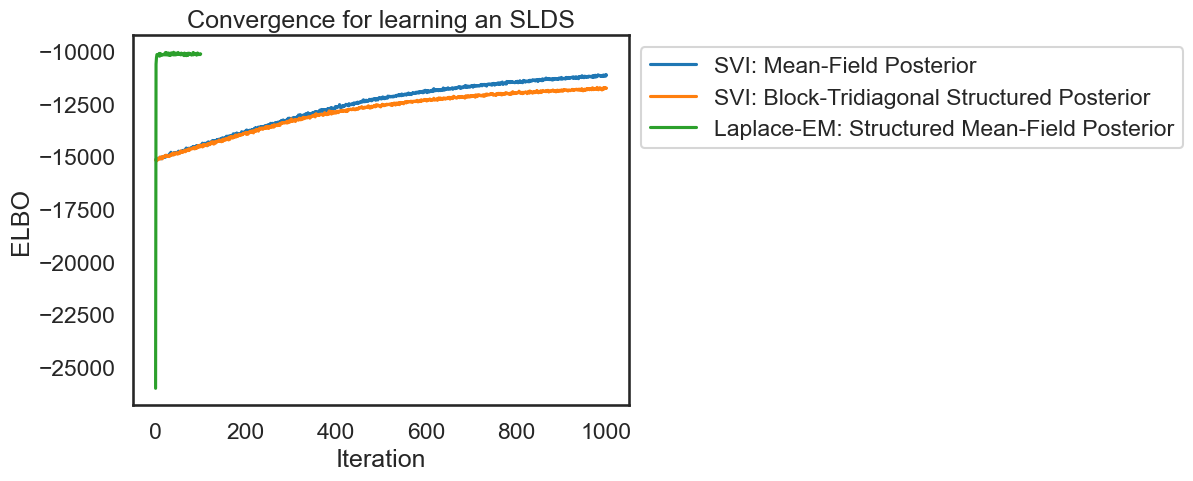

In [10]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="SVI: Mean-Field Posterior")
plt.plot(q_struct_elbos, label="SVI: Block-Tridiagonal Structured Posterior")
plt.plot(q_lem_elbos, label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an SLDS")
plt.show()

### 3.2 Exercise: The Evidence Lower Bound (ELBO)
In the SLDS model (and even in the LDS case with non-Gaussian observations), we can't optimize the log-likelihood directly. Instead, we optimize a lower bound on the log likelihood called the Evidence Lower Bound (ELBO). 

We denote the parameters of the model as $\Theta$, which are considered fixed for the purposes of this exercise. Concretely, we need to find a lower bound on $\log(P(Y \mid \Theta))$ where $Y=[y_1,\ldots,y_T]$. Can you use Jensen's inequality to derive a lower bound on this likelihood?

## 4. Visualize True and Inferred Latent States
Below, we compare how well each fitting algorithm recovers the discrete latent states. We then inspect the true vs. inferred continuos latent states.

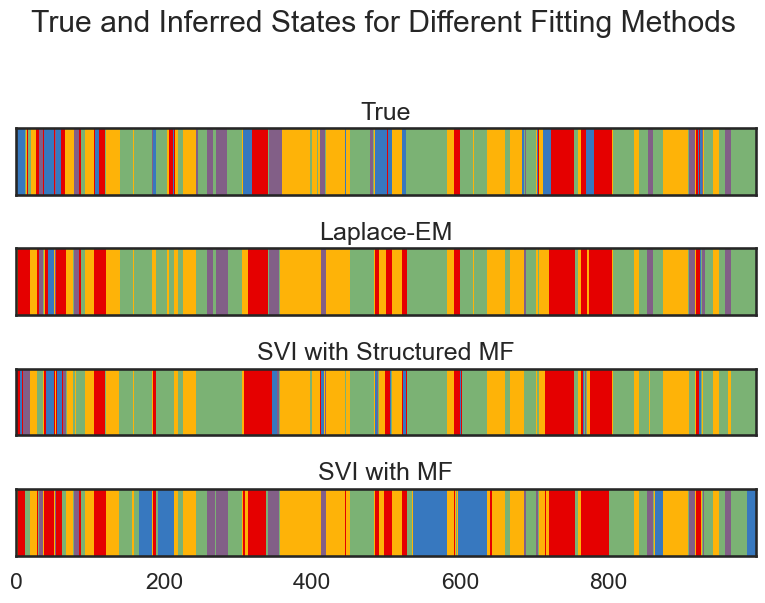

In [11]:
# Plot the true and inferred states
titles = ["True", "Laplace-EM", "SVI with Structured MF", "SVI with MF"]
states_list = [states_z, q_lem_z, q_struct_z, q_mf_z]
fig, axs = plt.subplots(4,1, figsize=(8,6))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

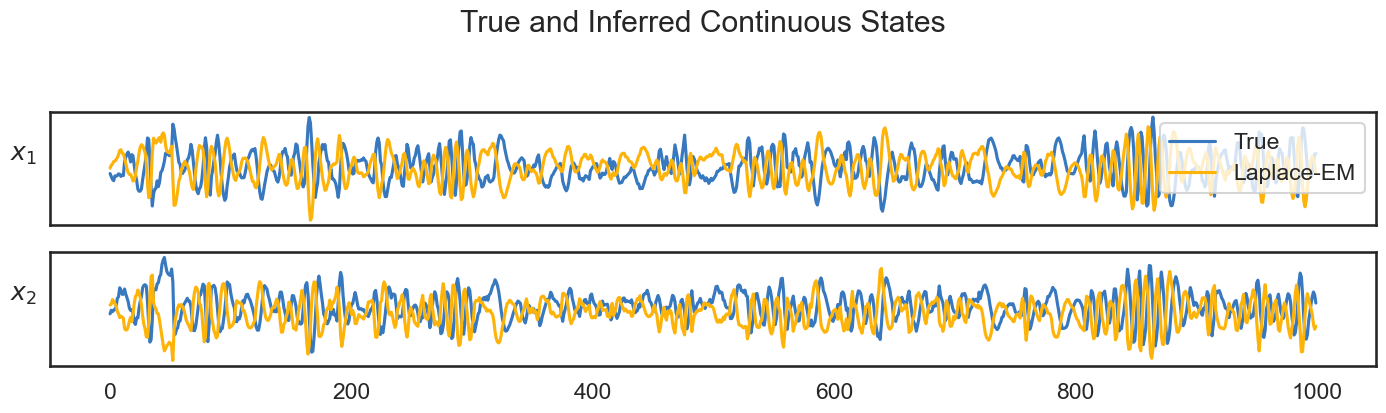

In [12]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(states_x[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(q_lem_x[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Inferred Continuous States", va="bottom")
plt.tight_layout()

### 4.2 Exercise: Fitting with fewer datapoints
From the above plots, it seems we were able to match the discrete states quite well using our learned model. Try reducing the number of time-bins used for fitting from 1000 to 500 or 100. At what point do we begin to fit badly?

## 5. Inference on unseen data
After learning a model from data, a common use-case is to compute the distribution over latent states given some new observations. For example, in the case of a simple LDS, we could use the Kalman Smoother to estimate the latent state trajectory given a set of observations. 

In the case of an SLDS (or Recurrent SLDS), the posterior over latent states can't be computed exactly. Instead, we need to live with a variational approximation to the true posterior. SSM allows us to compute this approximation using the `SLDS.approximate_posterior()` method. 

In the below example, we generate some new data from the true model. We then use the `approximate_posterior()` function to estimate the continuous and discrete states.

  0%|                                                                                                              | 0/50 [00:00<?, ?it/s]

ELBO: -3437801.3:   0%|                                                                                            | 0/50 [00:00<?, ?it/s]

ELBO: -1066.8:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1041.6:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1032.4:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1040.1:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1039.1:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1023.4:   0%|                                                                                               | 0/50 [00:00<?, ?it/s]

ELBO: -1023.4:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1058.3:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1019.1:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1024.5:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1018.6:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1031.7:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1017.1:  12%|██████████▍                                                                            | 6/50 [00:00<00:00, 58.32it/s]

ELBO: -1017.1:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1031.0:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1017.1:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1034.4:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1022.7:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1030.3:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1018.0:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:00, 58.71it/s]

ELBO: -1018.0:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1026.0:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1017.0:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1036.6:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1025.9:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1043.1:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1037.4:  36%|██████████████████████████████▉                                                       | 18/50 [00:00<00:00, 58.71it/s]

ELBO: -1037.4:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1050.5:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1045.7:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1030.3:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1021.9:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1024.8:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1021.6:  48%|█████████████████████████████████████████▎                                            | 24/50 [00:00<00:00, 58.68it/s]

ELBO: -1021.6:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1026.7:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1039.6:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1024.6:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1023.7:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1018.7:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1025.2:  60%|███████████████████████████████████████████████████▌                                  | 30/50 [00:00<00:00, 58.67it/s]

ELBO: -1025.2:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1039.8:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1033.7:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1028.1:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1016.4:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1041.1:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1045.1:  72%|█████████████████████████████████████████████████████████████▉                        | 36/50 [00:00<00:00, 58.60it/s]

ELBO: -1045.1:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1029.0:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1054.2:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1004.2:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1027.0:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1026.3:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1033.8:  84%|████████████████████████████████████████████████████████████████████████▏             | 42/50 [00:00<00:00, 58.80it/s]

ELBO: -1033.8:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 48/50 [00:00<00:00, 58.94it/s]

ELBO: -1024.7:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 48/50 [00:00<00:00, 58.94it/s]

ELBO: -1029.9:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 48/50 [00:00<00:00, 58.94it/s]

ELBO: -1029.9: 100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.82it/s]

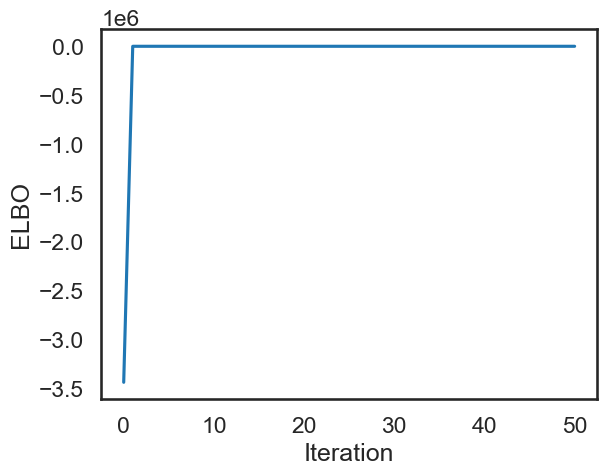

In [13]:
# Generate data which was not used for fitting
time_bins = 100
data_z, data_x, data = true_slds.sample(time_bins)

# Compute the approximate posterior over latent and continuous
# states for the new data under the current model parameters.
elbos, posterior = slds.approximate_posterior(data,
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=50)

# Verify that the ELBO increases during fitting. We don't expect a substantial increase:
# we are updating the estimate of the latent states but we are not changing model params.
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

**Estimating Latent States**  
  
`posterior` is now an `ssm.variational.SLDSStructuredMeanFieldVariationalPosterior` object. Using this object, we can estimate the continuous and discrete states just like we did after calling the fit function.

In the below cell, we get the estimated continuous states as follows:
```python
posterior_x = posterior.mean_continuous_states[0]
```
This line uses the `mean_continuous_states` property of the posterior object, which returns a list, where each entry of the list corresponds to a single trial of data. Since we have only passed in a single trial the list will have length 1, and we take the first entry.

We then permute the discrete and continuous states to best match the ground truth. This is for aesthetic purposes when plotting. The following lines compute the best permutation which match the predicted states (`most_likely`) to the ground truth discrete states (`data_z`). We then permute the states of the SLDS accordingly:
```python

most_likely = slds.most_likely_states(posterior_x, data)
perm = find_permutation(data_z, most_likely)
slds.permute(perm)
z_est = slds.most_likely_states(posterior_x, data)

```

In [14]:
# Get the posterior mean of the continuous states
posterior_x = posterior.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
most_likely = slds.most_likely_states(posterior_x, data)
perm = find_permutation(data_z, most_likely)
slds.permute(perm)
z_est = slds.most_likely_states(posterior_x, data)

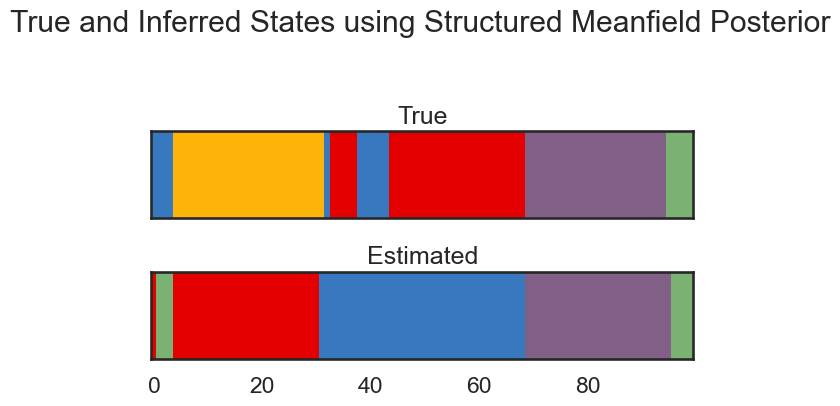

In [15]:
# Plot the true and inferred states
titles = ["True", "Estimated"]
states_list = [data_z, z_est]
fig, axs = plt.subplots(2,1, figsize=(6,4))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States using Structured Meanfield Posterior", va="baseline")
plt.tight_layout()

In [16]:
x_est = posterior.mean_continuous_states[0]

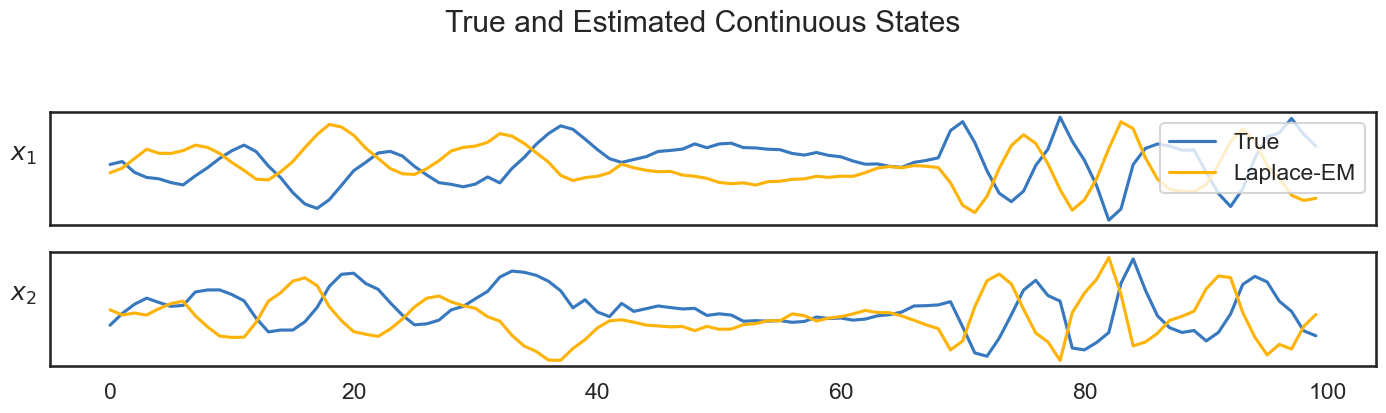

In [17]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(data_x[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(x_est[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Estimated Continuous States", va="bottom")
plt.tight_layout()